In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import math

In [2]:
#US_ratings should be loaded directly from the data made in the pipeline.py

BA_merged = pd.read_csv('../../minimizedData/BA_ratings_small_plus.csv')
US_ratings = BA_merged.dropna(subset=['beer_location','user_location','rating'])
US_ratings = US_ratings[US_ratings['user_location'].str.startswith('United States,')]
US_ratings = US_ratings[US_ratings['beer_location'].str.startswith('United States,')]

US_ratings['user_state'] = US_ratings['user_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings['beer_state'] = US_ratings['beer_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings = US_ratings.drop(['user_location','beer_location'], axis=1)

US_ratings = US_ratings[(US_ratings['user_state'] != 'United States') & (US_ratings['beer_state'] != 'United States')]

US_ratings.head(3)

beer_name   beer_id                  brewery_name  brewery_id  \
1008809     Kupfer Kolsch  289320.0  Copper State Brewing Company     49595.0   
1008810  Northwestern Alt  289321.0  Copper State Brewing Company     49595.0   
1008811    One Cent Wheat  289319.0  Copper State Brewing Company     49595.0   

           style       user_id  appearance  aroma  palate  taste  overall  \
1008809   Kölsch  n2185.211743        2.50   4.00    4.00   3.75     3.75   
1008810  Altbier  n2185.211743        3.00   3.75    4.00   3.50     3.50   
1008811  Witbier  n2185.211743        3.75   3.25    3.75   3.50     3.50   

         rating   avg      user_state beer_state  
1008809    3.76  3.76  North Carolina  Wisconsin  
1008810    3.58  3.58  North Carolina  Wisconsin  
1008811    3.48  3.48  North Carolina  Wisconsin

In [4]:
#csv file containing all the states and their neighbouring states
#empty list for states that have no neighbours (e.g Alazka, Hawaii)
neighbours_df = pd.read_csv('../../additionalData/bordering_states.csv', dtype={'state':'string', 
                                                                          'neighbours': 'string'})
neighbours_df["neighbours"] = neighbours_df["neighbours"].fillna("").apply(lambda x: x.split(";") if x else [])

neighbours_df.head(3)

state                                        neighbours  nb_neighbours
0  Alabama        [Florida, Georgia, Mississippi, Tennessee]              4
1   Alaska                                                []              0
2  Arizona  [California, Colorado, Nevada, New Mexico, Utah]              5

In [5]:
def gather_region_ratings(state, US_ratings, neighbours_df):
    neighbours = neighbours_df.loc[neighbours_df['state'] == state, 'neighbours'].values[0]
    
    region_states = [state] + neighbours    
    region_ratings = US_ratings[US_ratings['beer_state'].isin(region_states)]

    in_region_ratings = region_ratings[region_ratings['user_state'].isin(region_states)]
    not_in_region_ratings = region_ratings[~region_ratings['user_state'].isin(region_states)]
    
    return in_region_ratings, not_in_region_ratings

states = US_ratings['beer_state'].unique()

all_ratings = {'region': [], 'rating': [], 'rating_type': [], 'user_state': []}

for state in states:
    in_region, non_region = gather_region_ratings(state, US_ratings, neighbours_df)

    region_name = f"{state}"
    
    # Add In-Region ratings to the dictionary
    all_ratings['region'].extend([region_name] * len(in_region))
    all_ratings['rating'].extend(in_region['rating'].tolist())
    all_ratings['rating_type'].extend(['In-Region'] * len(in_region))
    all_ratings['user_state'].extend(in_region['user_state'].tolist())
    
    # Add Non-Region ratings to the dictionary
    all_ratings['region'].extend([region_name] * len(non_region))
    all_ratings['rating'].extend(non_region['rating'].tolist())
    all_ratings['rating_type'].extend(['Non-Region'] * len(non_region))
    all_ratings['user_state'].extend(non_region['user_state'].tolist())

ratings_df = pd.DataFrame(all_ratings)

ratings_df.head()


region  rating rating_type user_state
0  Wisconsin    4.04   In-Region  Wisconsin
1  Wisconsin    4.00   In-Region  Wisconsin
2  Wisconsin    3.75   In-Region  Wisconsin
3  Wisconsin    3.90   In-Region   Illinois
4  Wisconsin    3.25   In-Region  Wisconsin

In [6]:
ratings_df.head(200)

region  rating rating_type user_state
0    Wisconsin    4.04   In-Region  Wisconsin
1    Wisconsin    4.00   In-Region  Wisconsin
2    Wisconsin    3.75   In-Region  Wisconsin
3    Wisconsin    3.90   In-Region   Illinois
4    Wisconsin    3.25   In-Region  Wisconsin
..         ...     ...         ...        ...
195  Wisconsin    3.50   In-Region  Minnesota
196  Wisconsin    4.25   In-Region  Wisconsin
197  Wisconsin    3.75   In-Region  Minnesota
198  Wisconsin    4.15   In-Region  Minnesota
199  Wisconsin    3.25   In-Region  Minnesota

[200 rows x 4 columns]

In [7]:
ratings_df = ratings_df[ratings_df['rating_type'] == 'In-Region']
ratings_df = ratings_df.drop('rating_type', axis=1)
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13278808 entries, 0 to 34011603
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   region      object 
 1   rating      float64
 2   user_state  object 
dtypes: float64(1), object(2)
memory usage: 405.2+ MB


In [8]:
ratings_df['rating_type'] = np.where(ratings_df['region'] == ratings_df['user_state'], 'In-State', 'Non-State')
avg_ratings = ratings_df.groupby(['region', 'rating_type'])['rating'].mean().unstack()
avg_ratings = avg_ratings.reset_index()
avg_ratings.head()


rating_type      region  In-State  Non-State
0               Alabama  3.876441   3.942452
1                Alaska  3.970084        NaN
2               Arizona  3.950191   3.971004
3              Arkansas  3.782575   3.784315
4            California  4.003972   3.970370

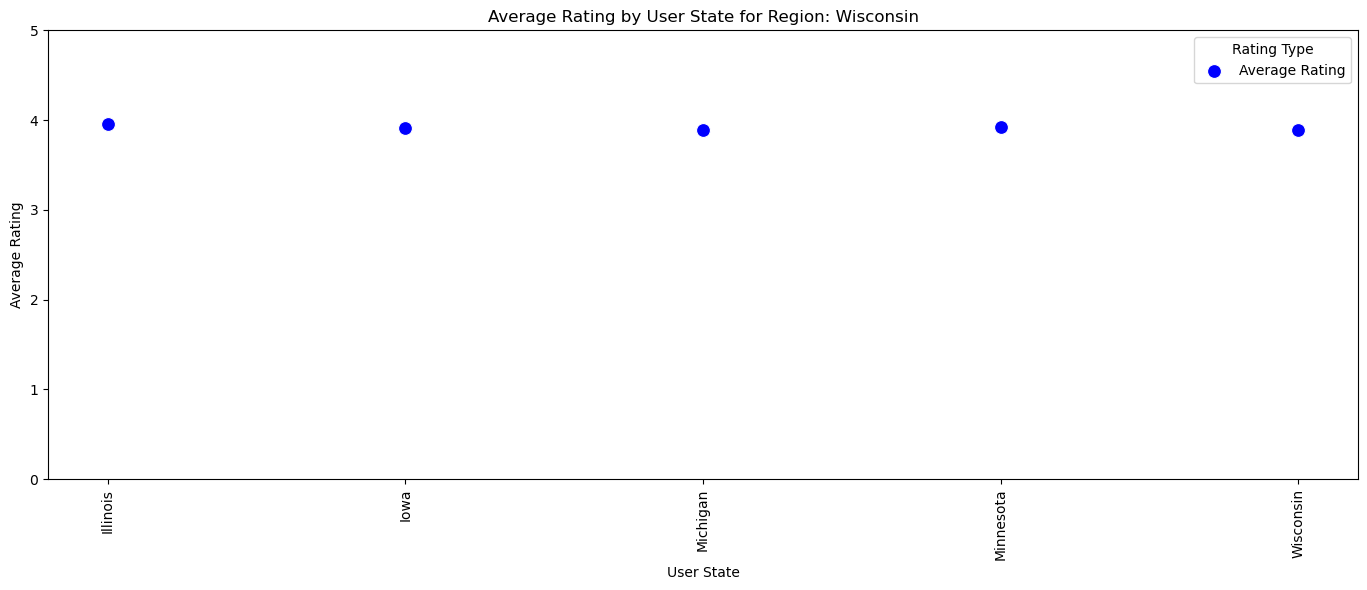

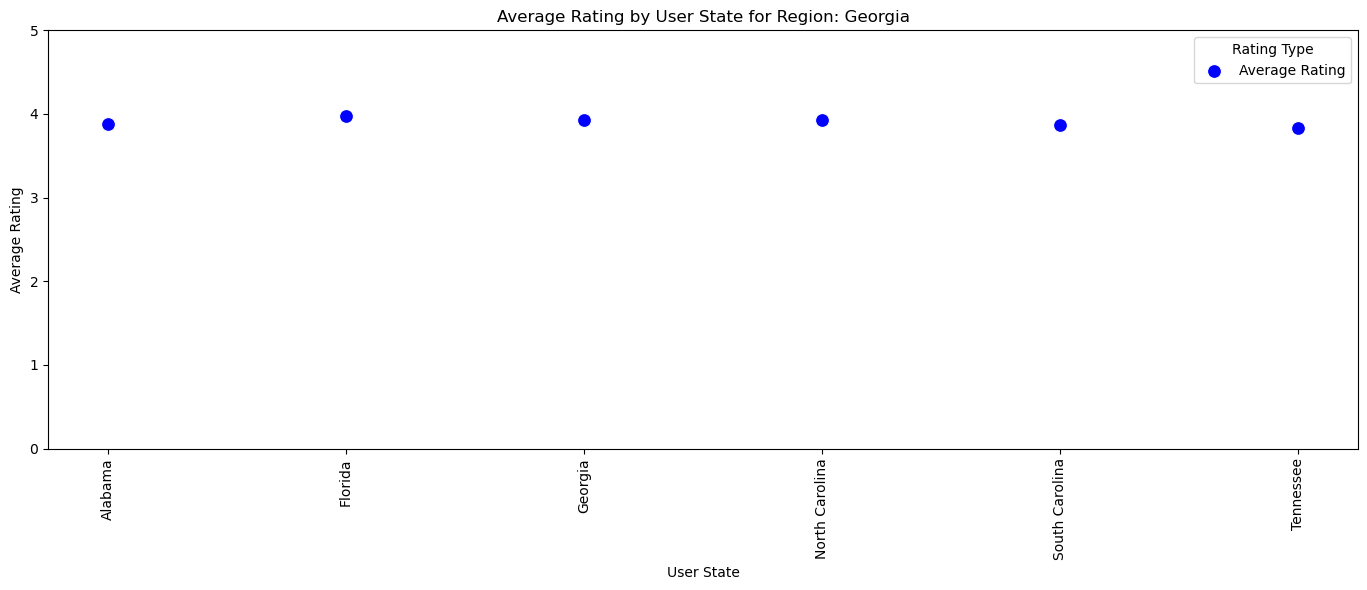

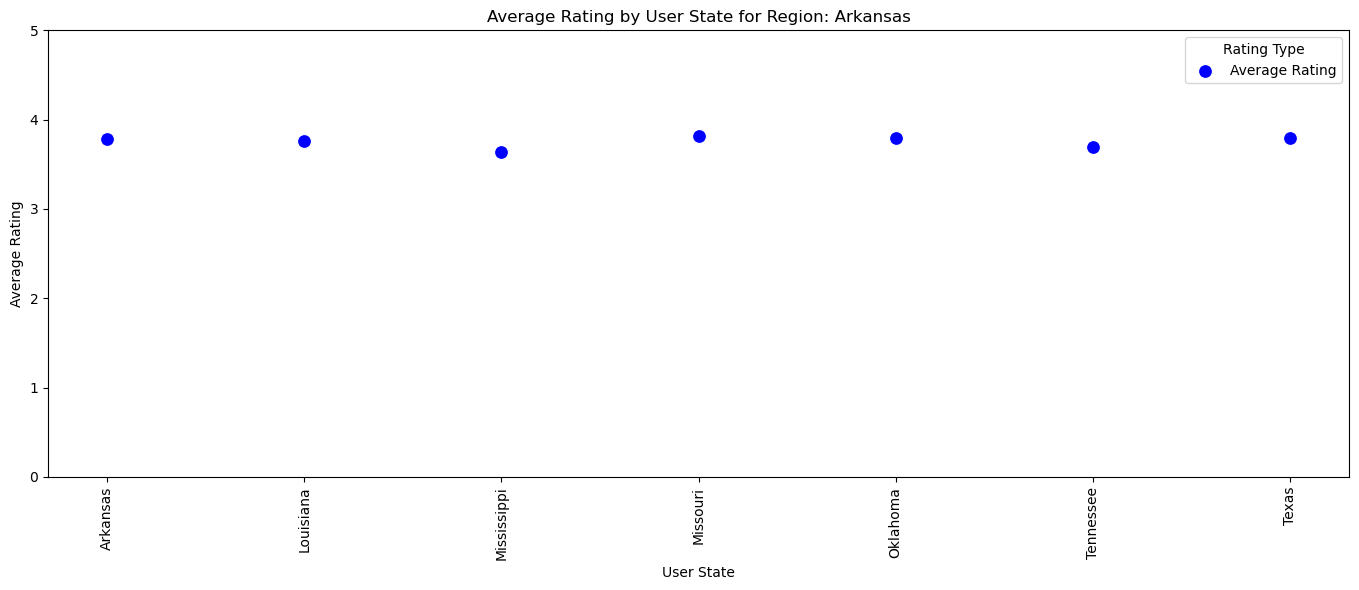

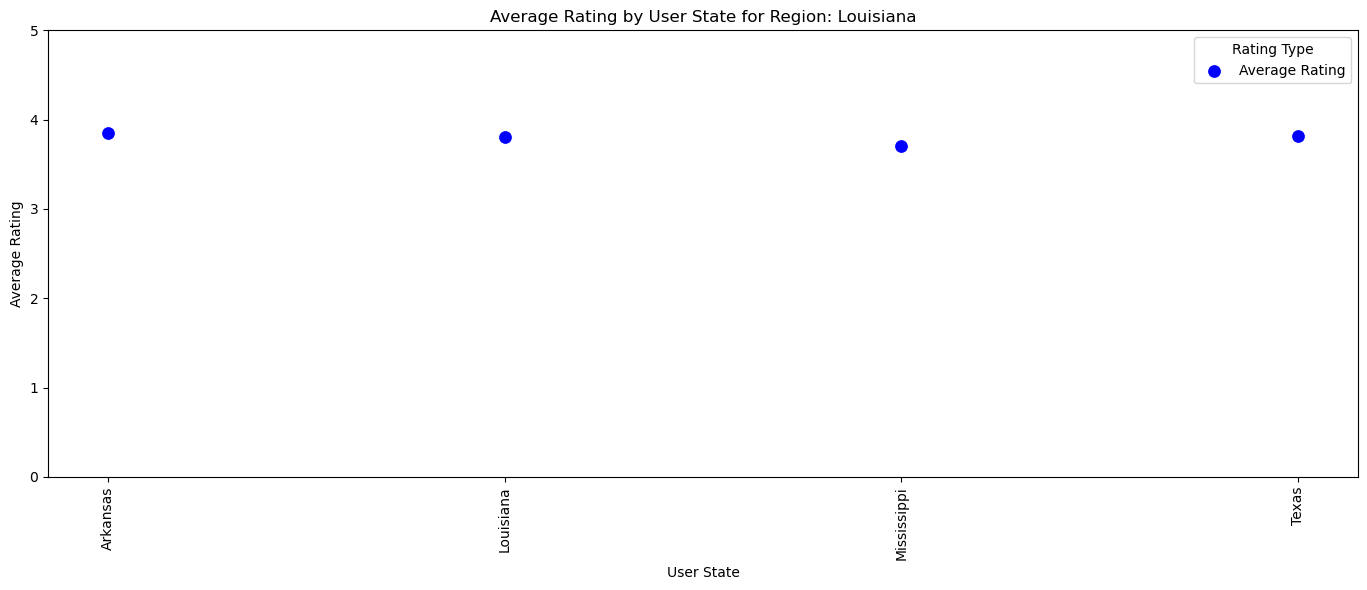

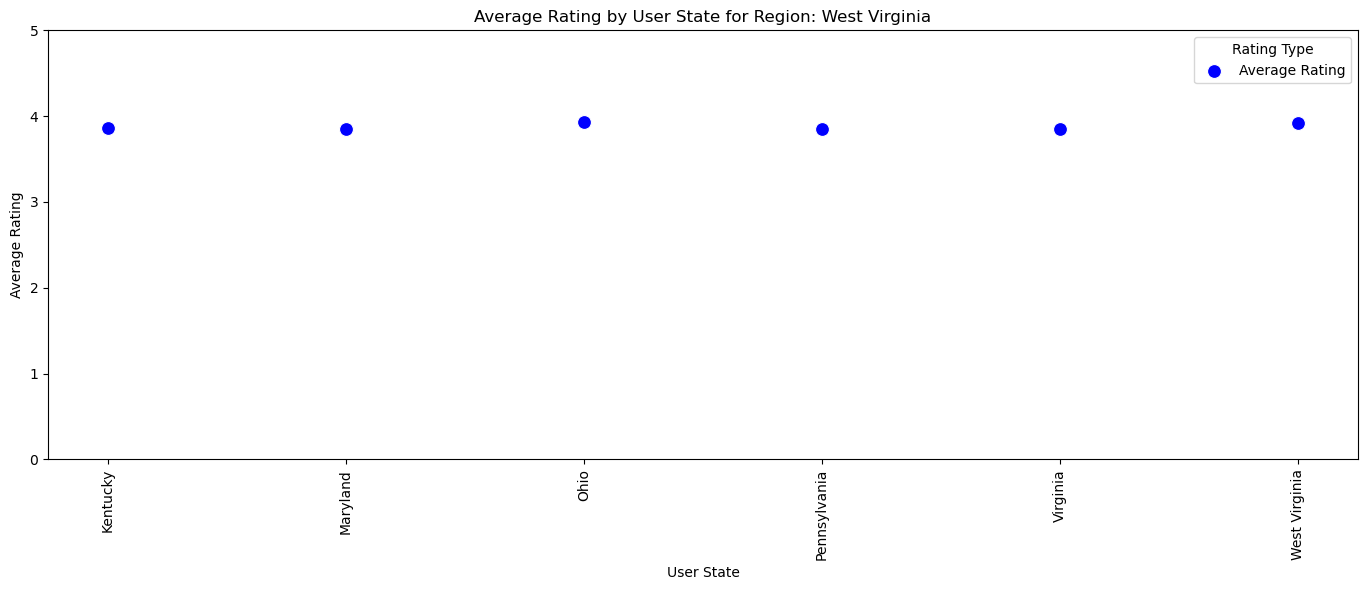

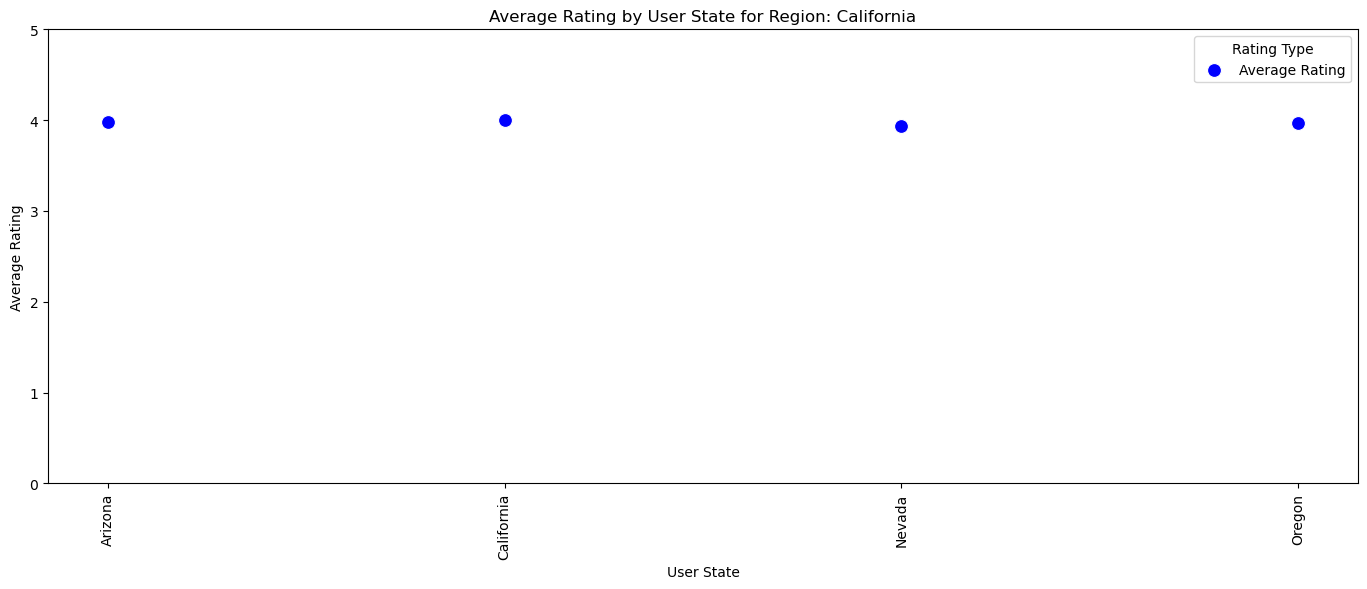

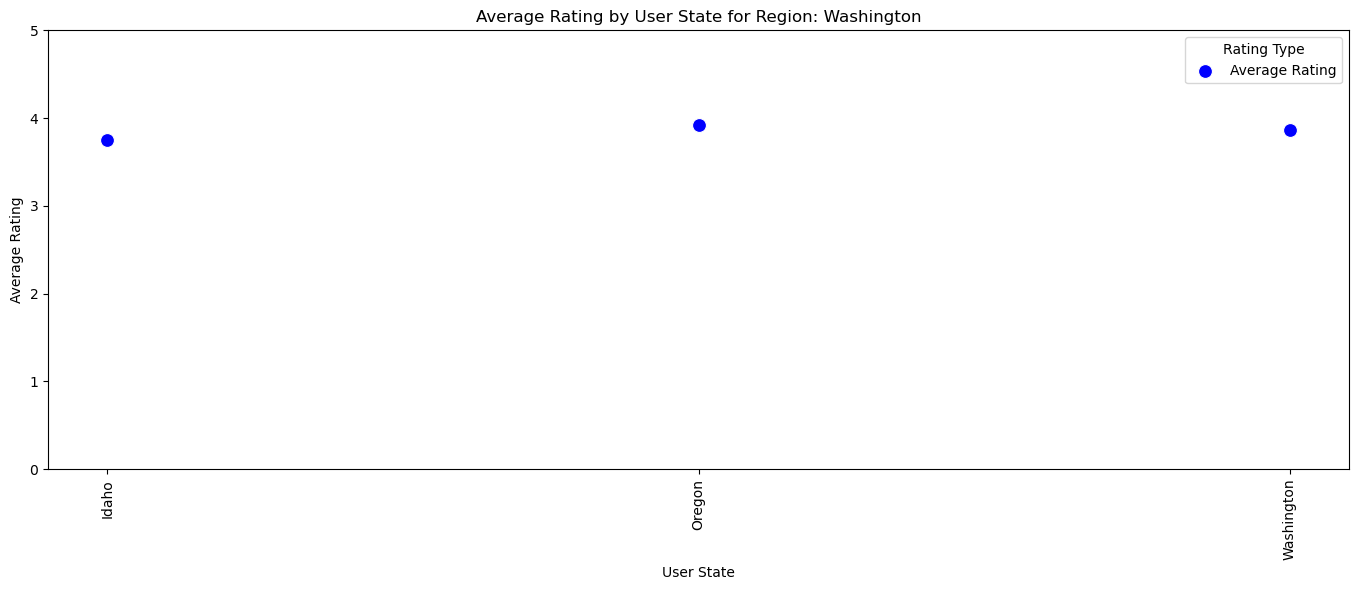

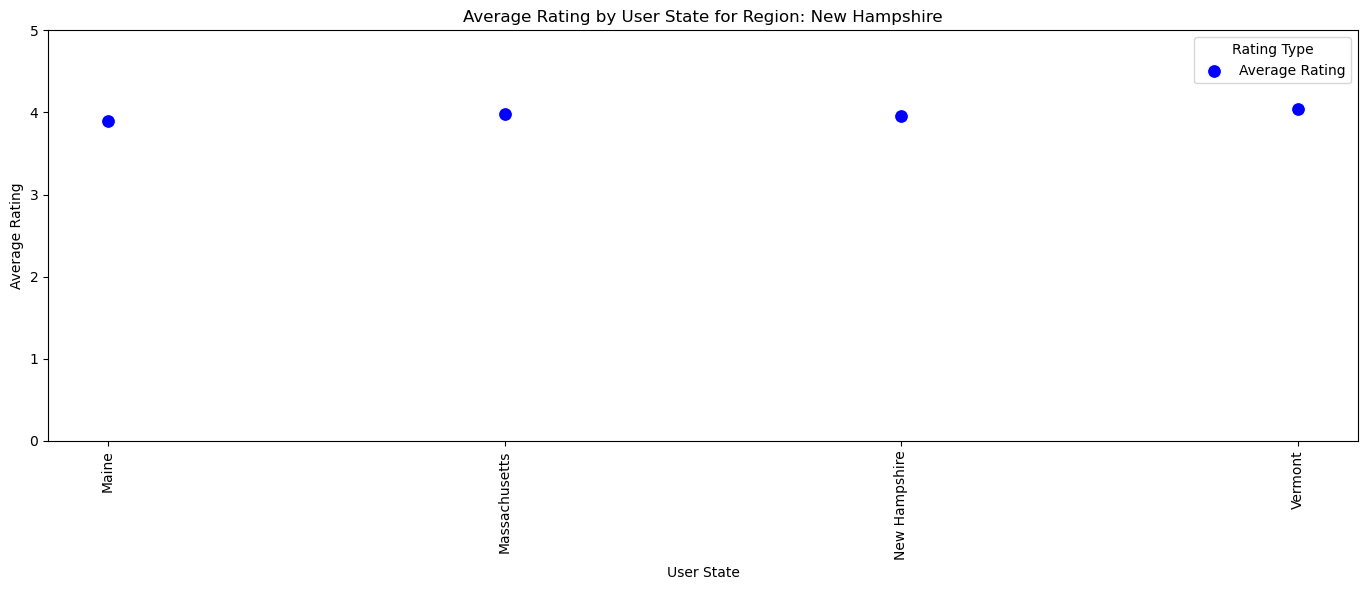

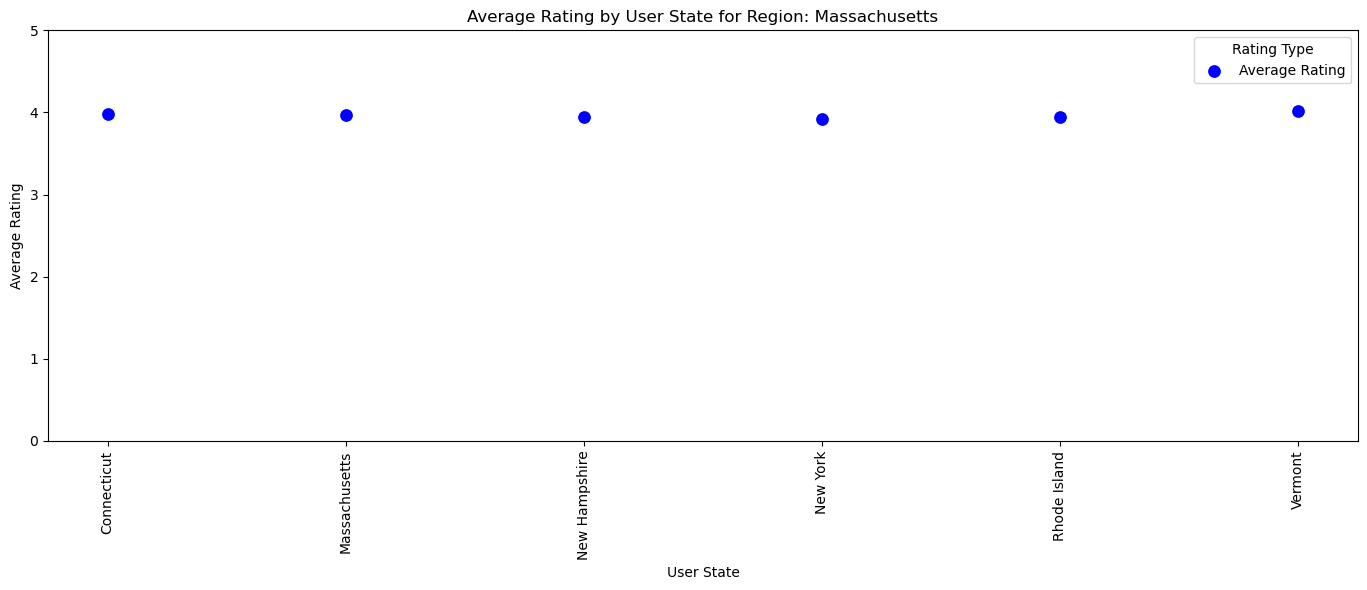

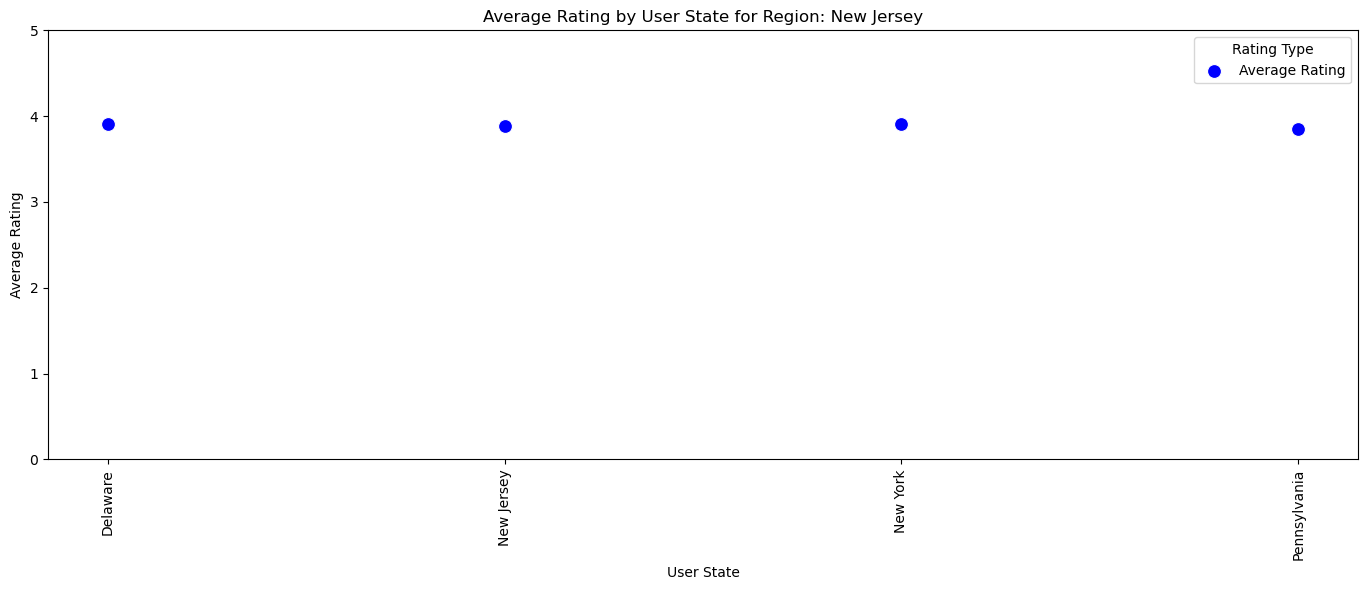

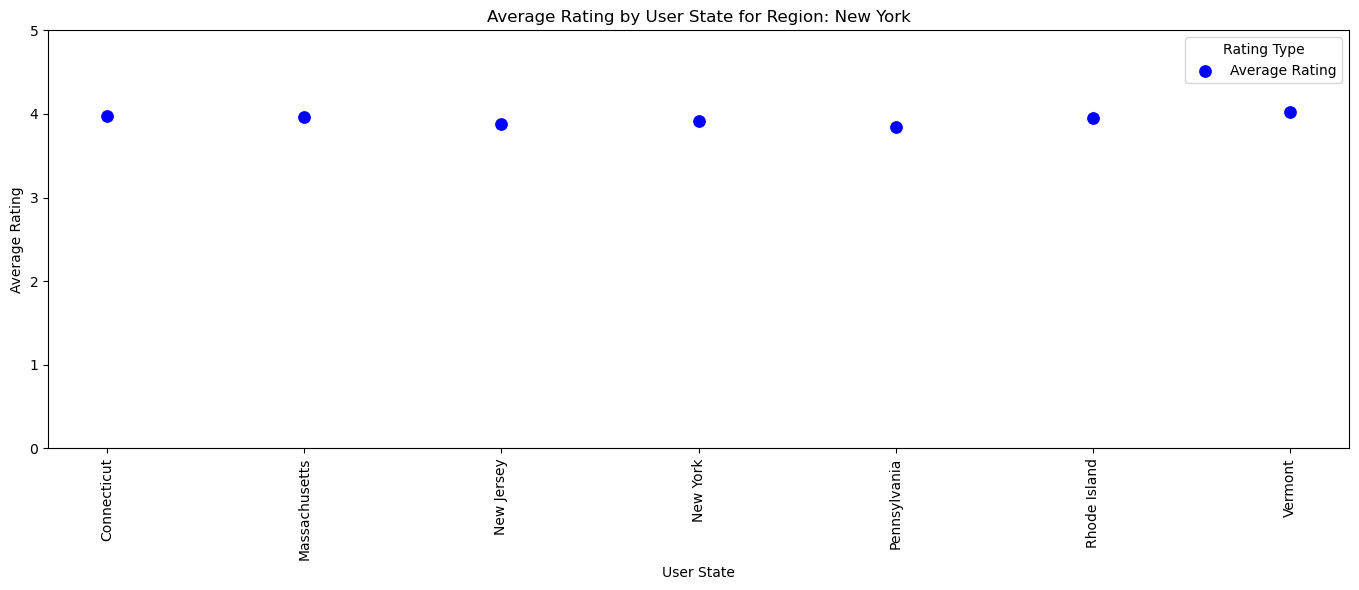

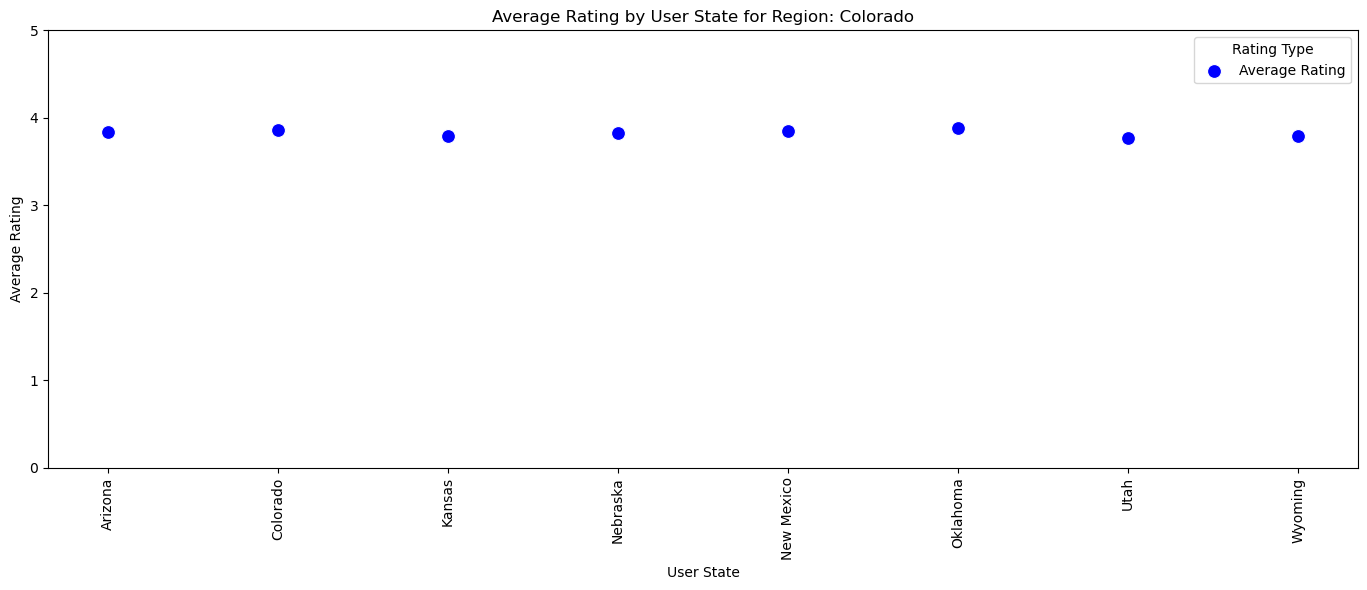

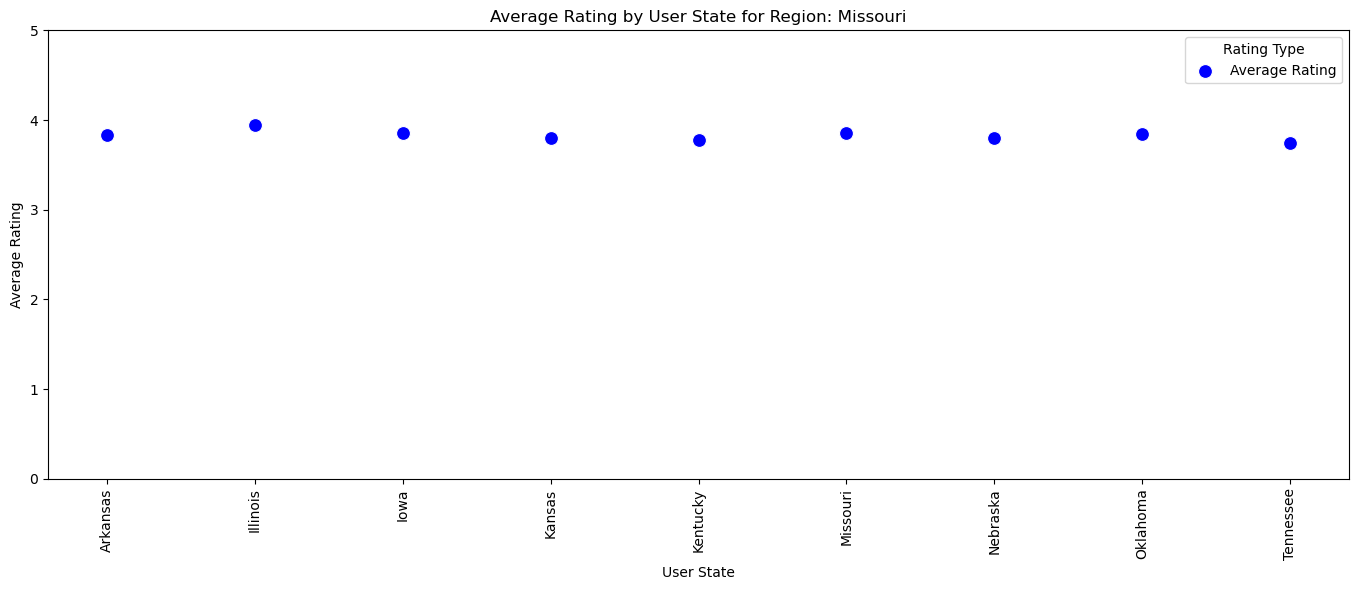

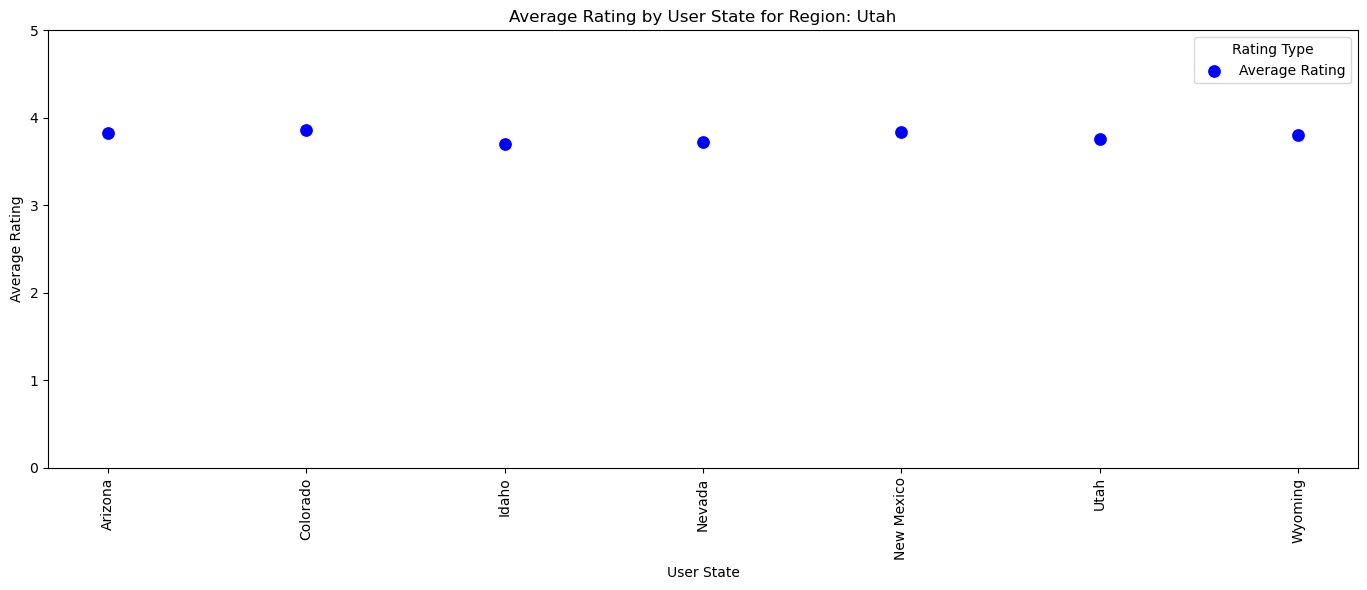

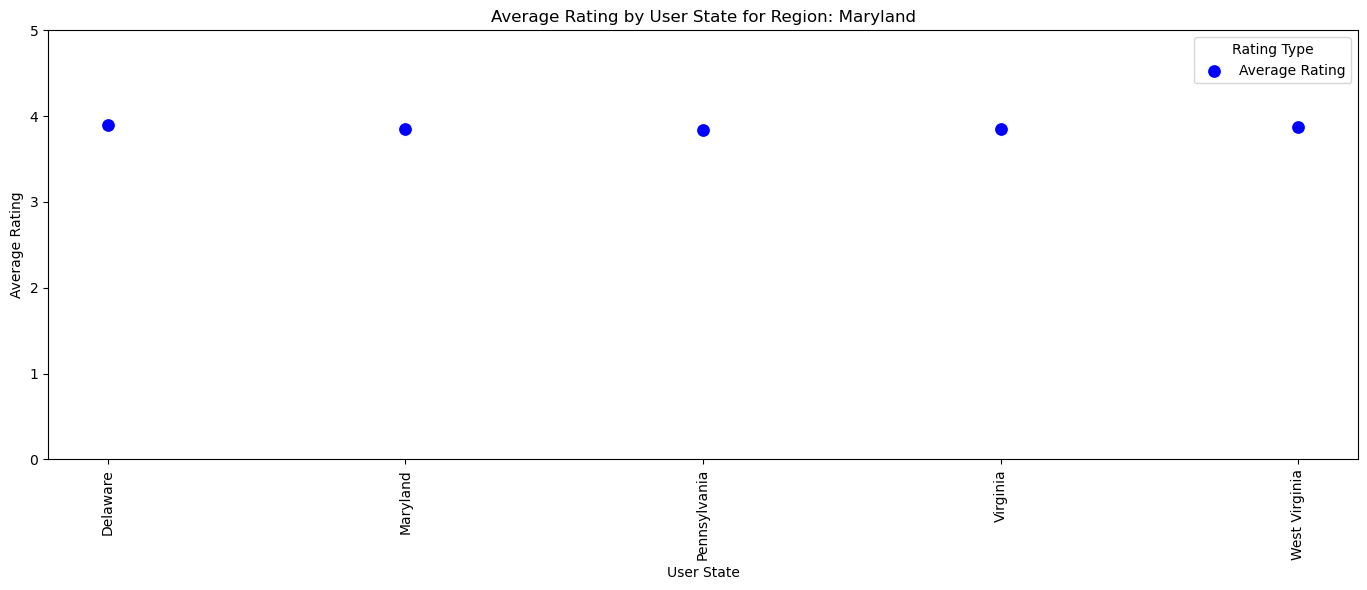

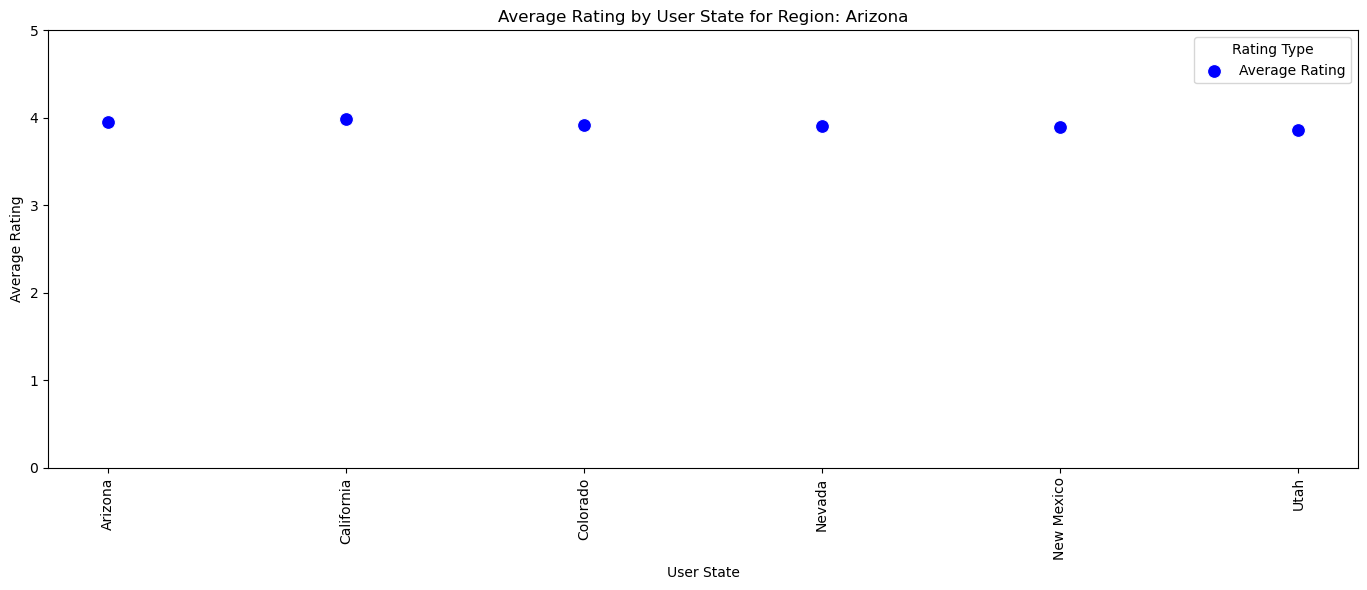

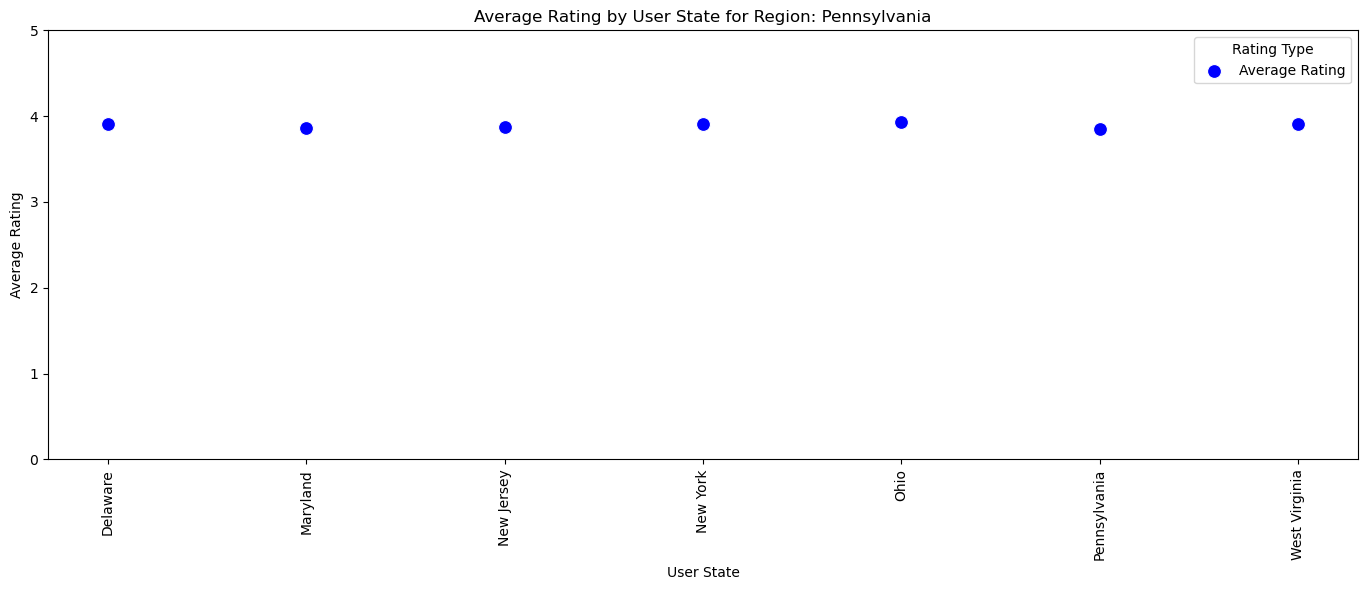

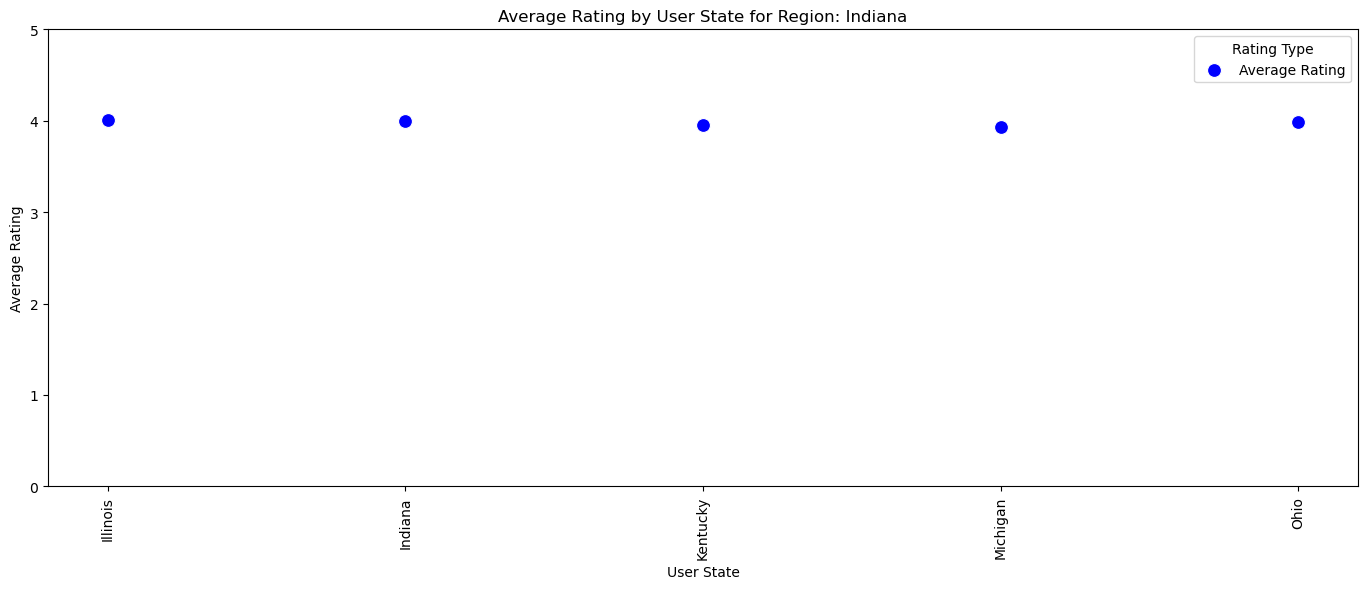

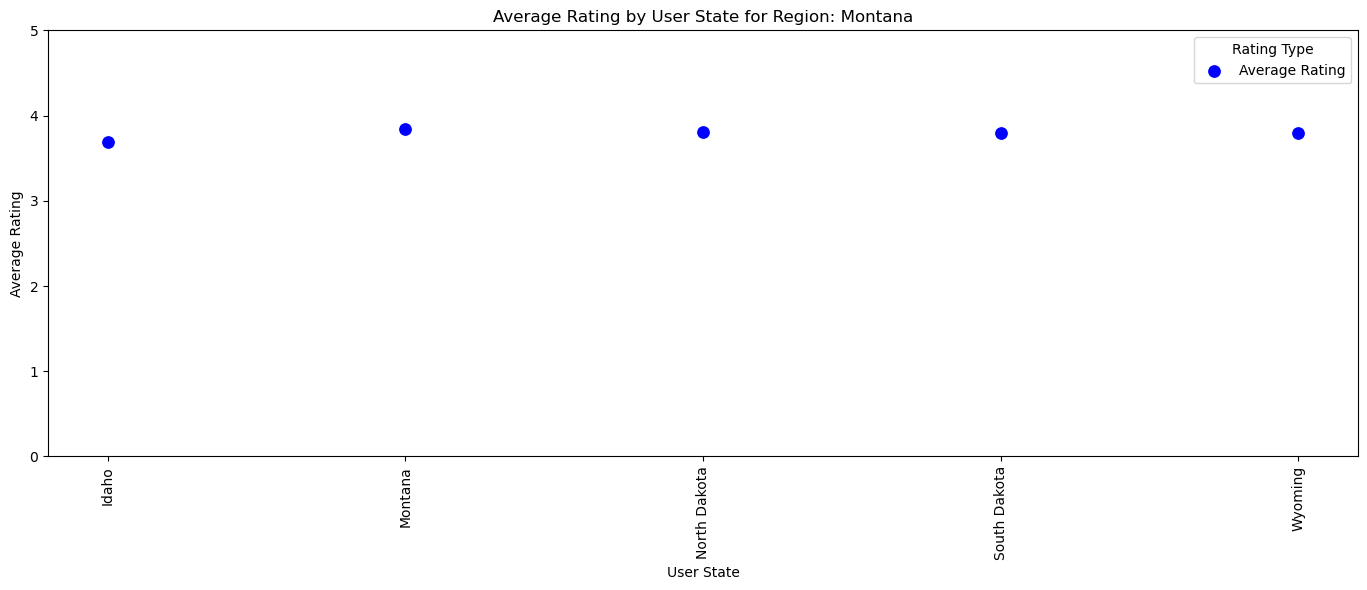

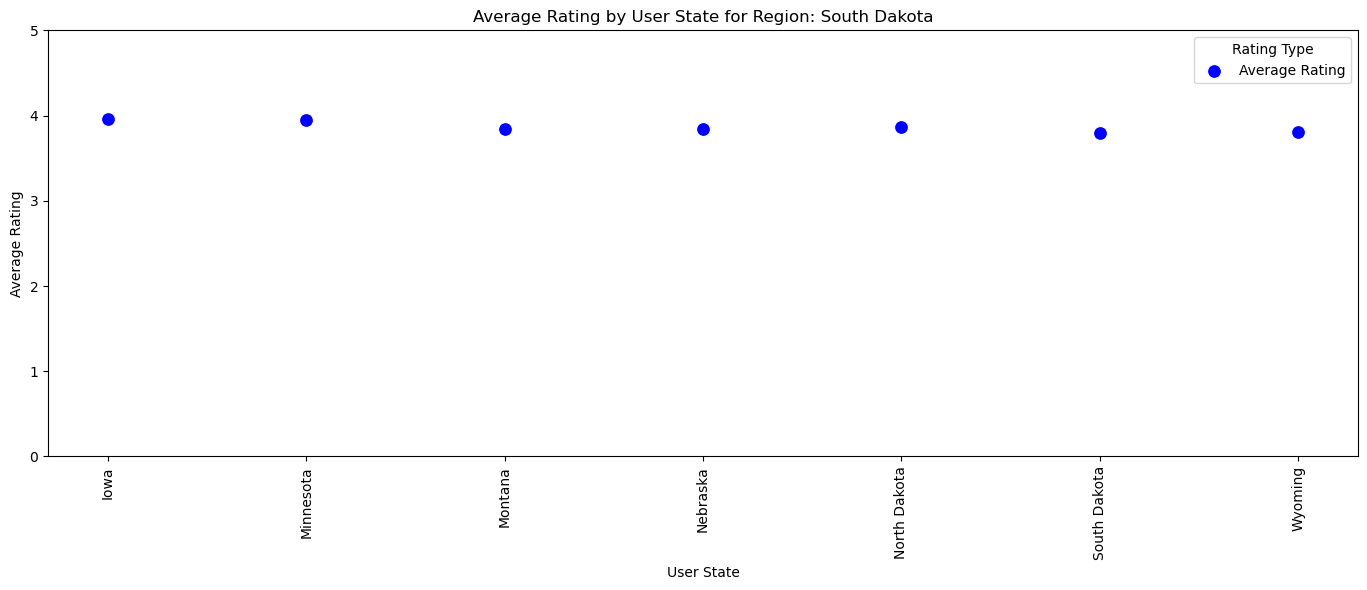

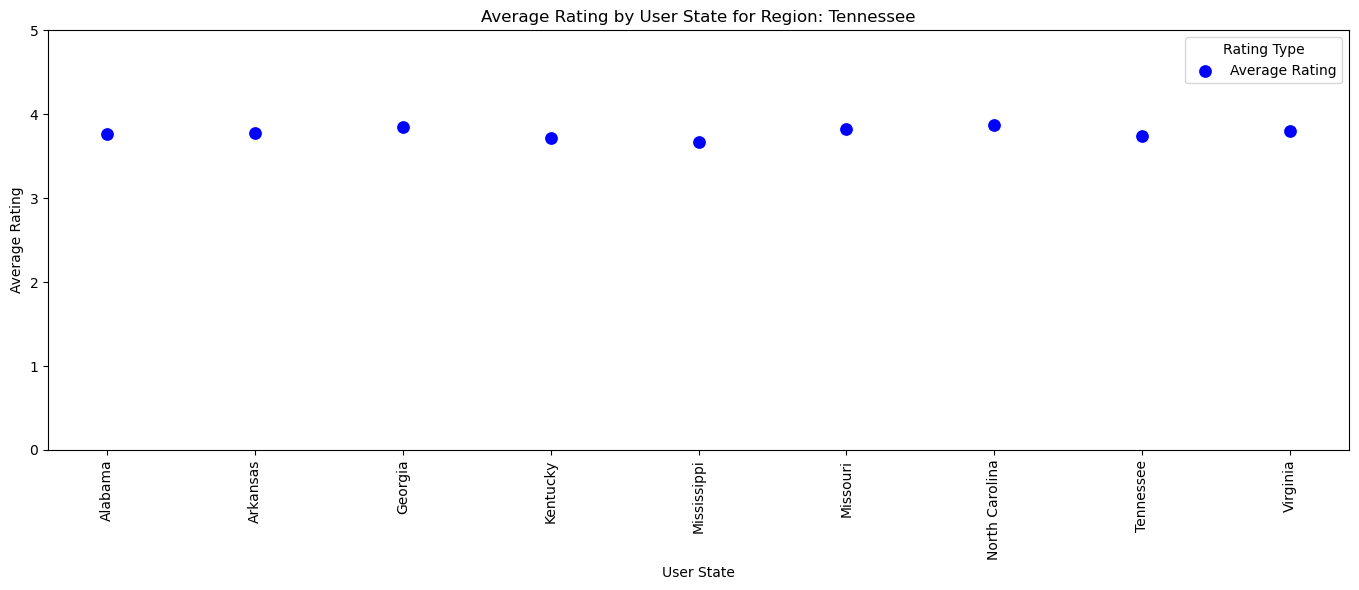

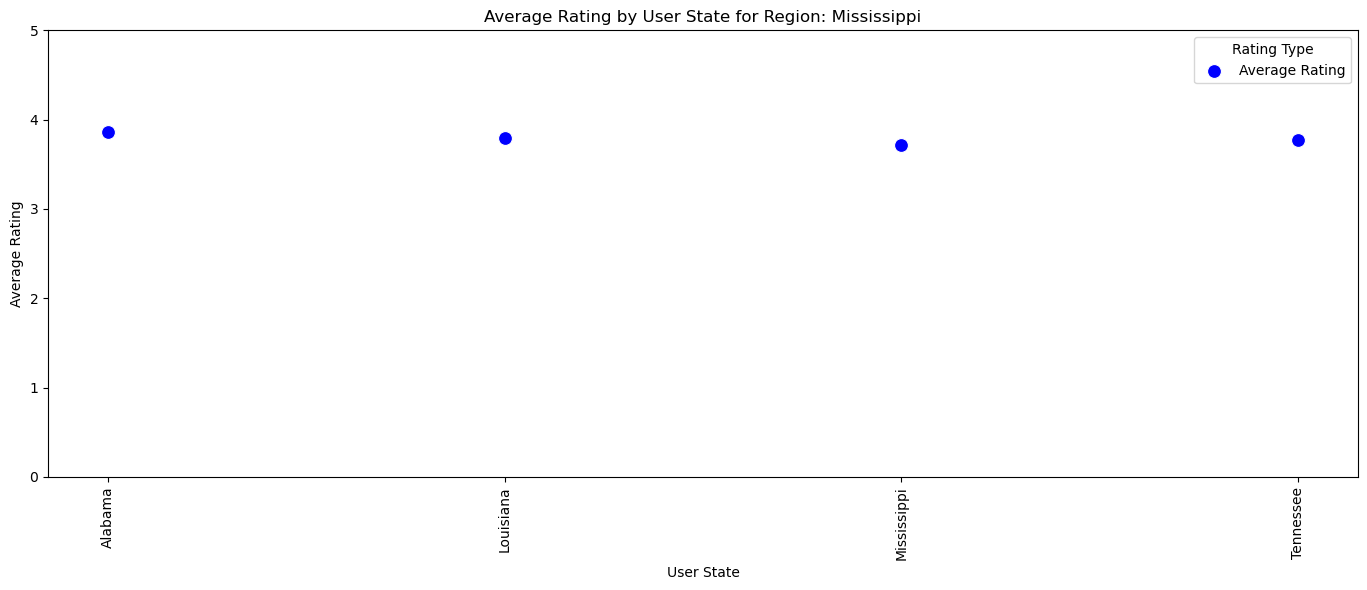

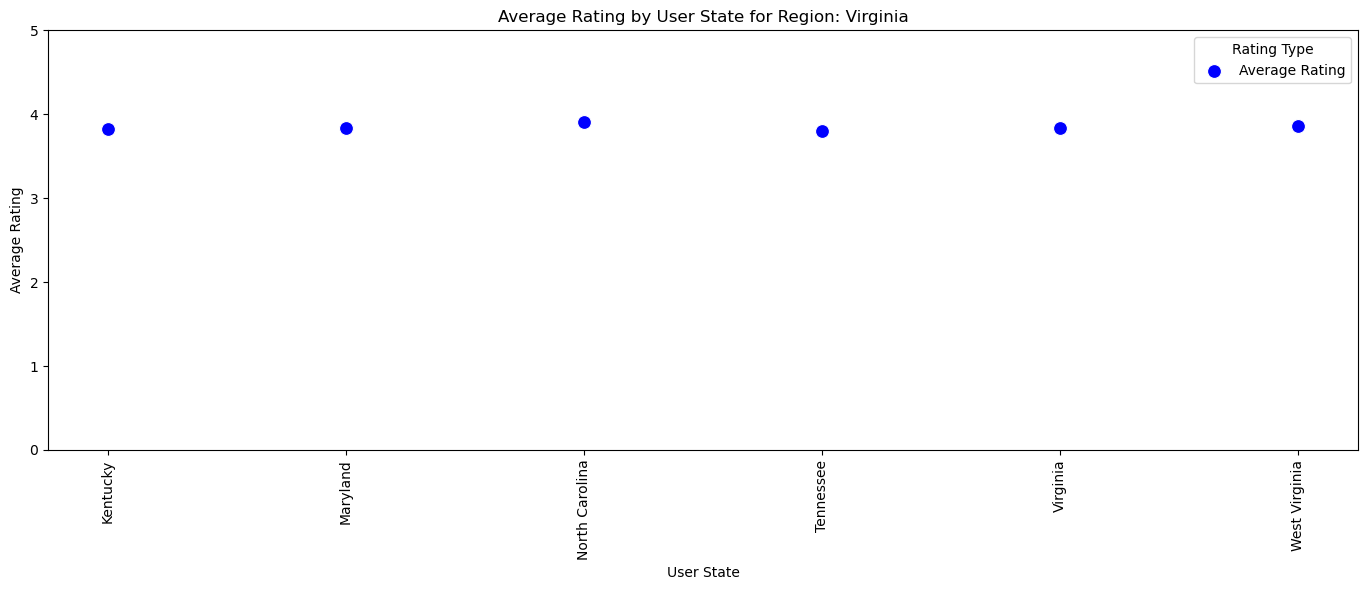

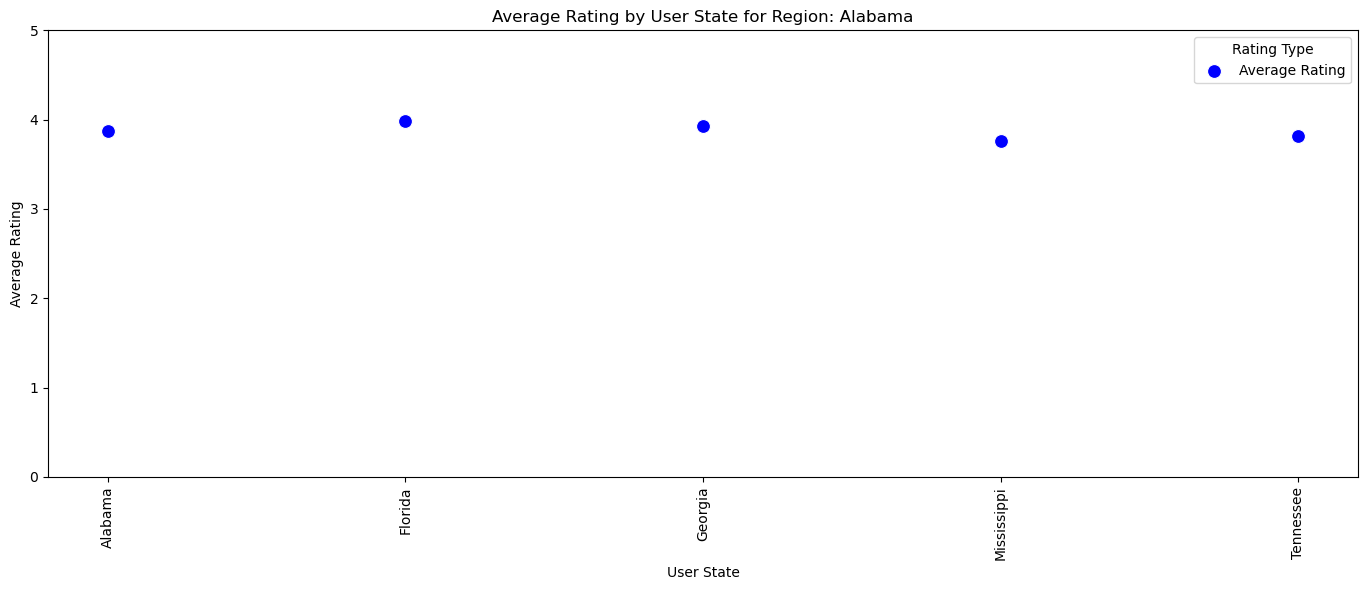

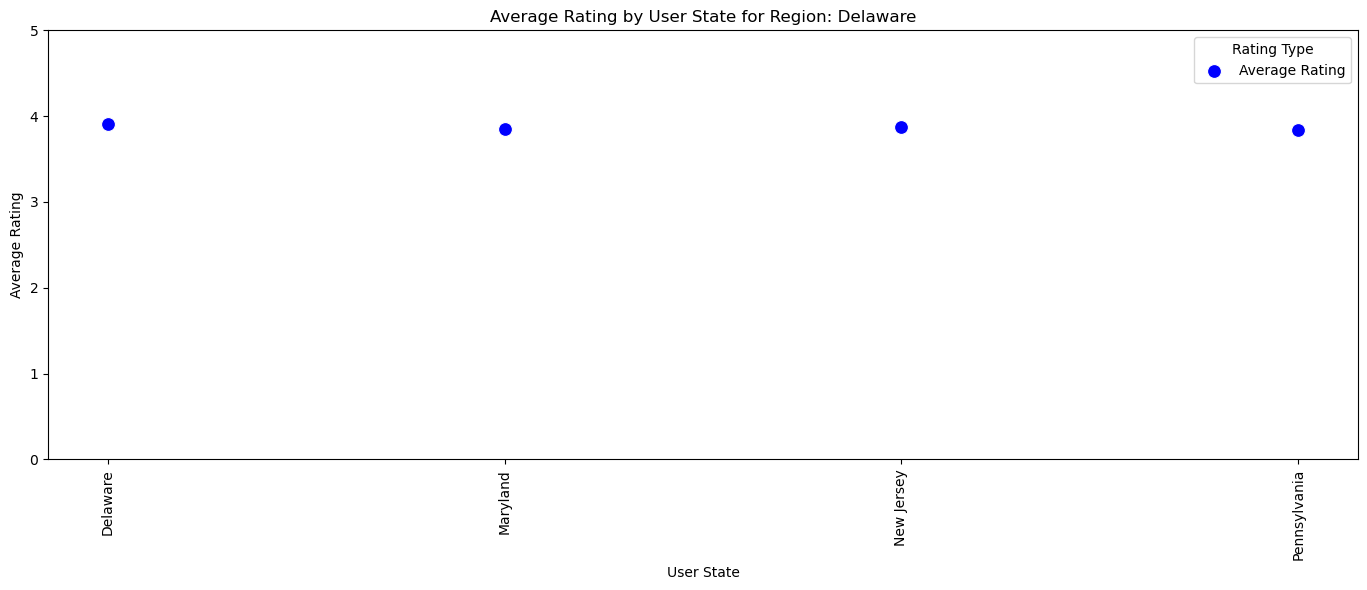

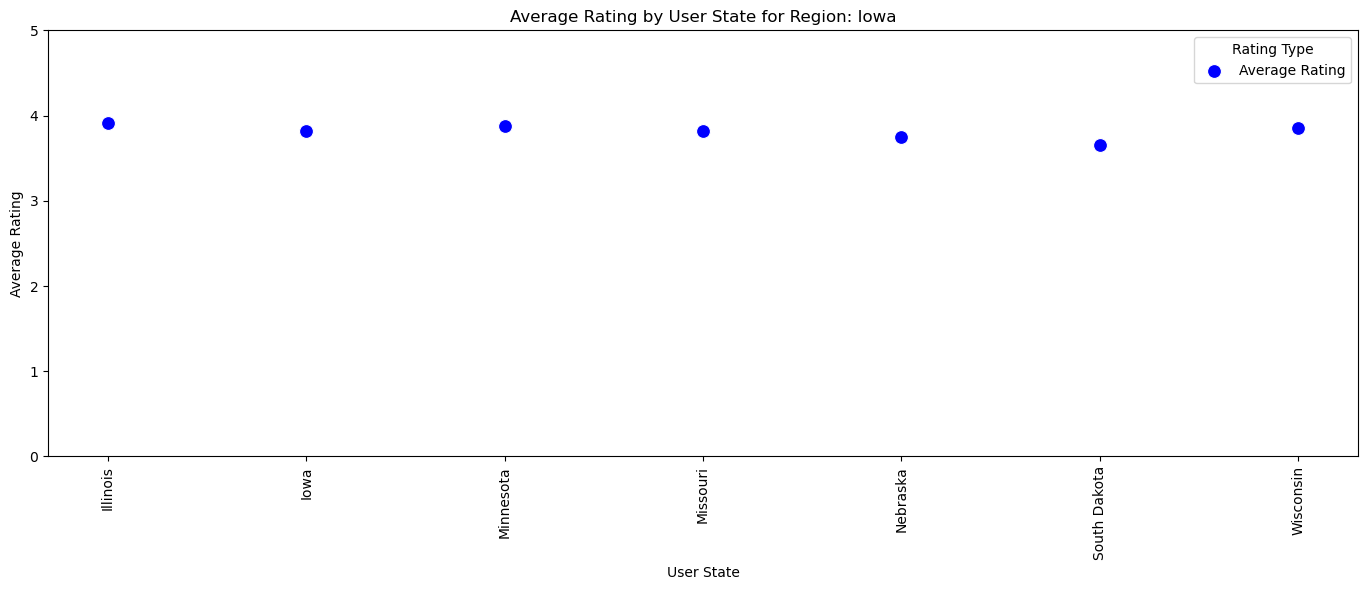

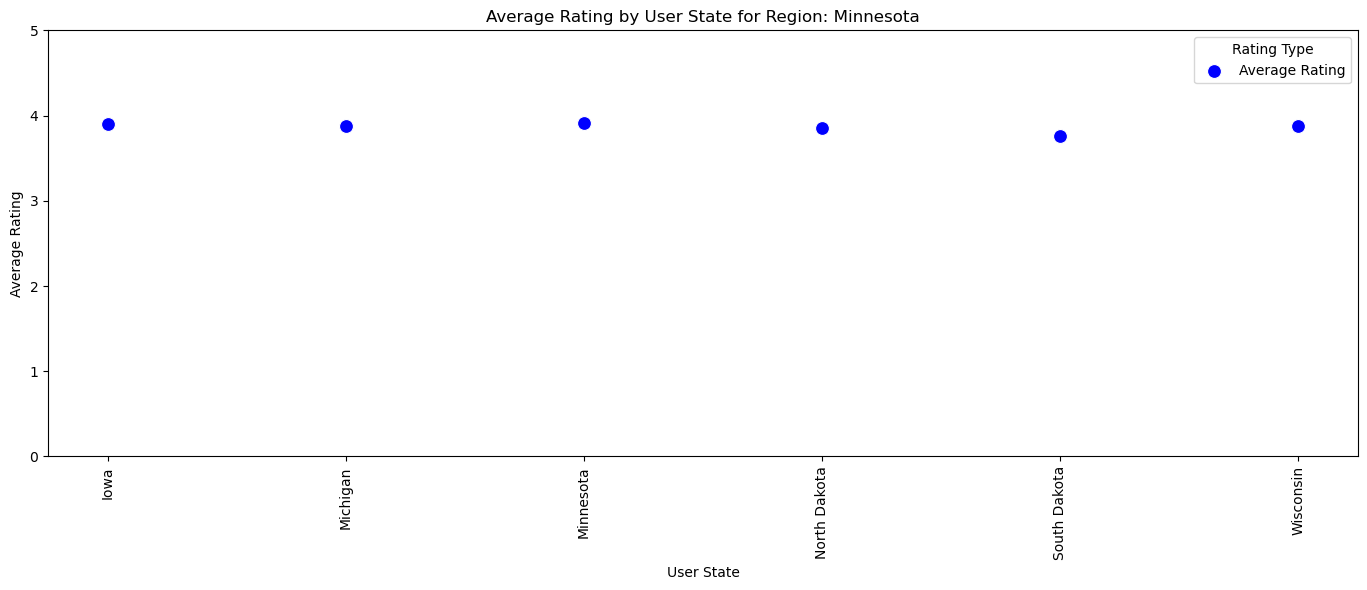

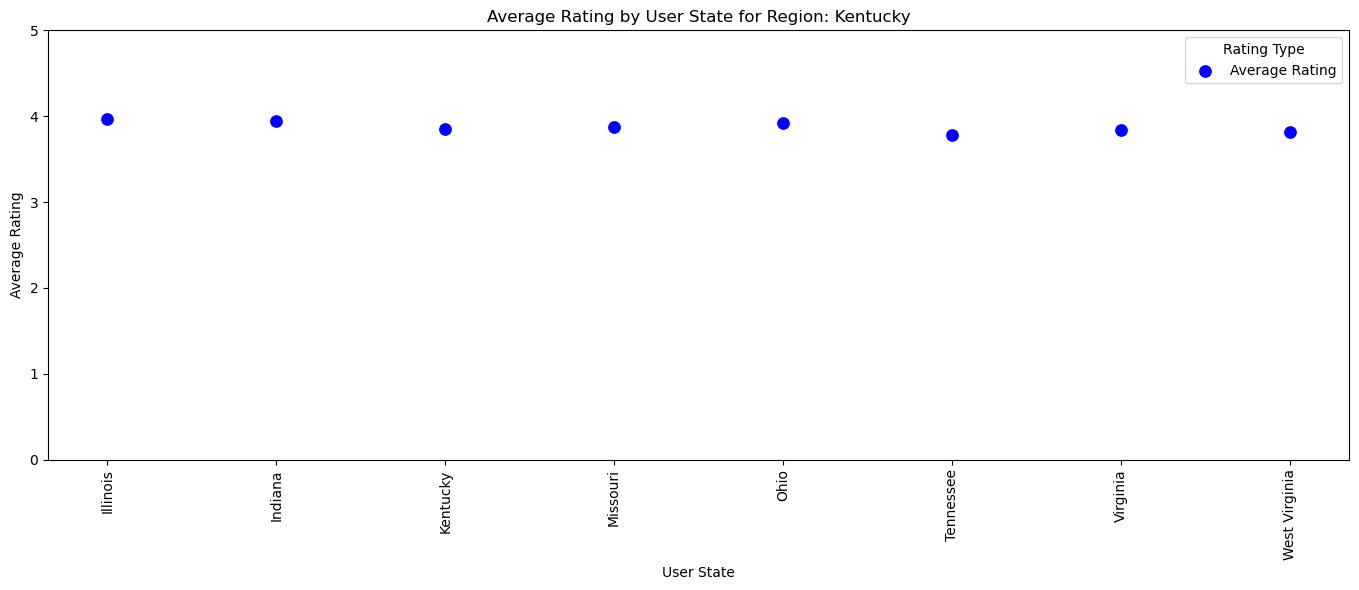

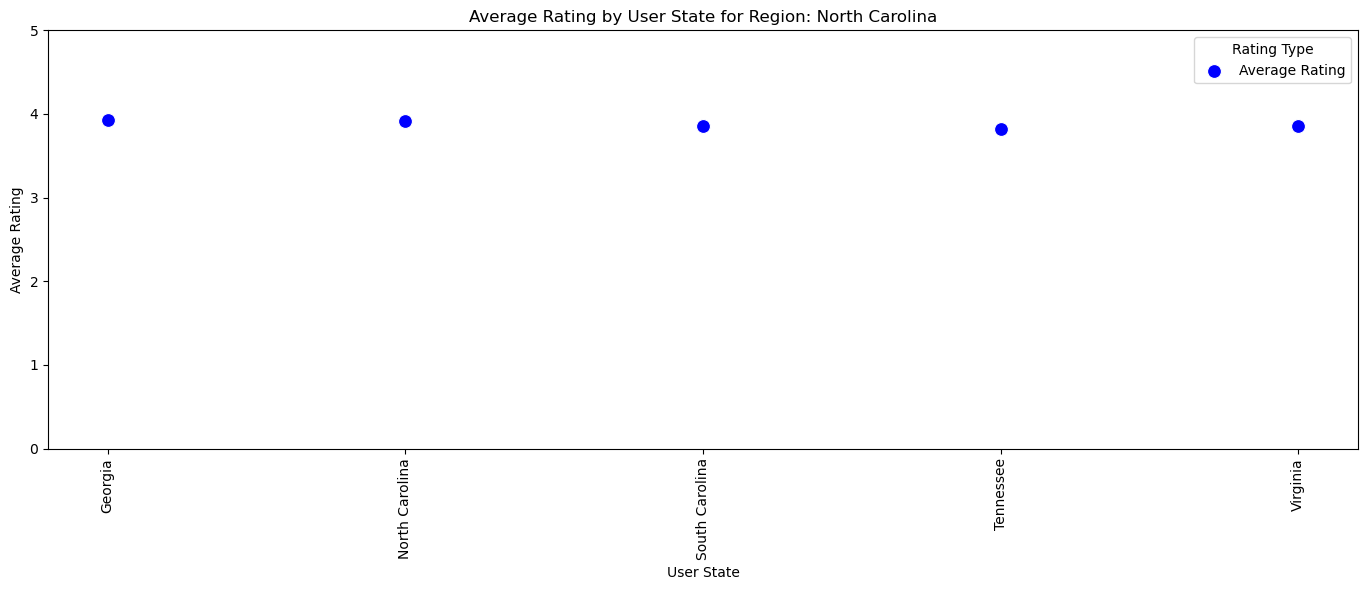

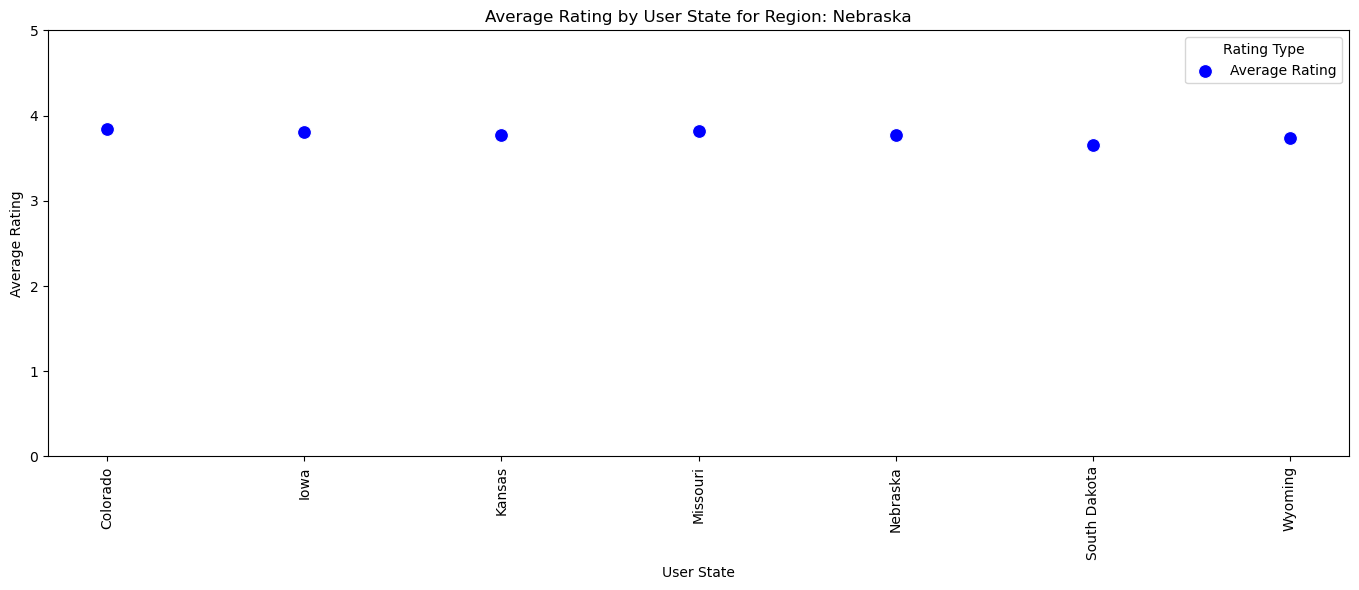

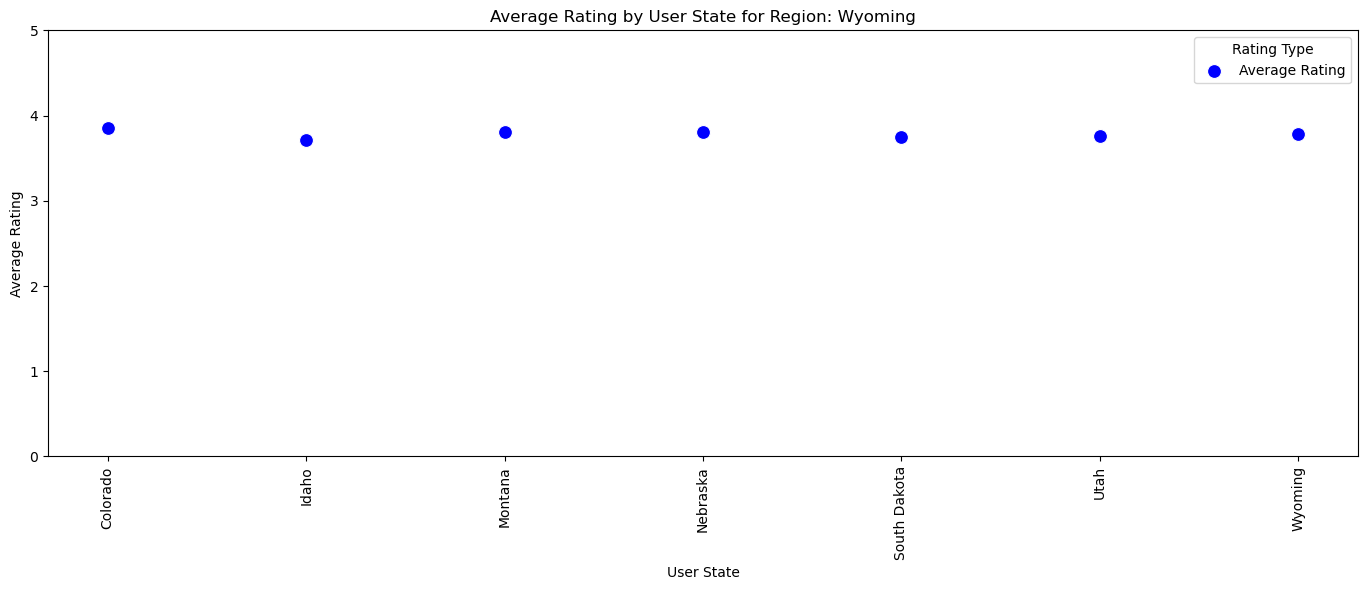

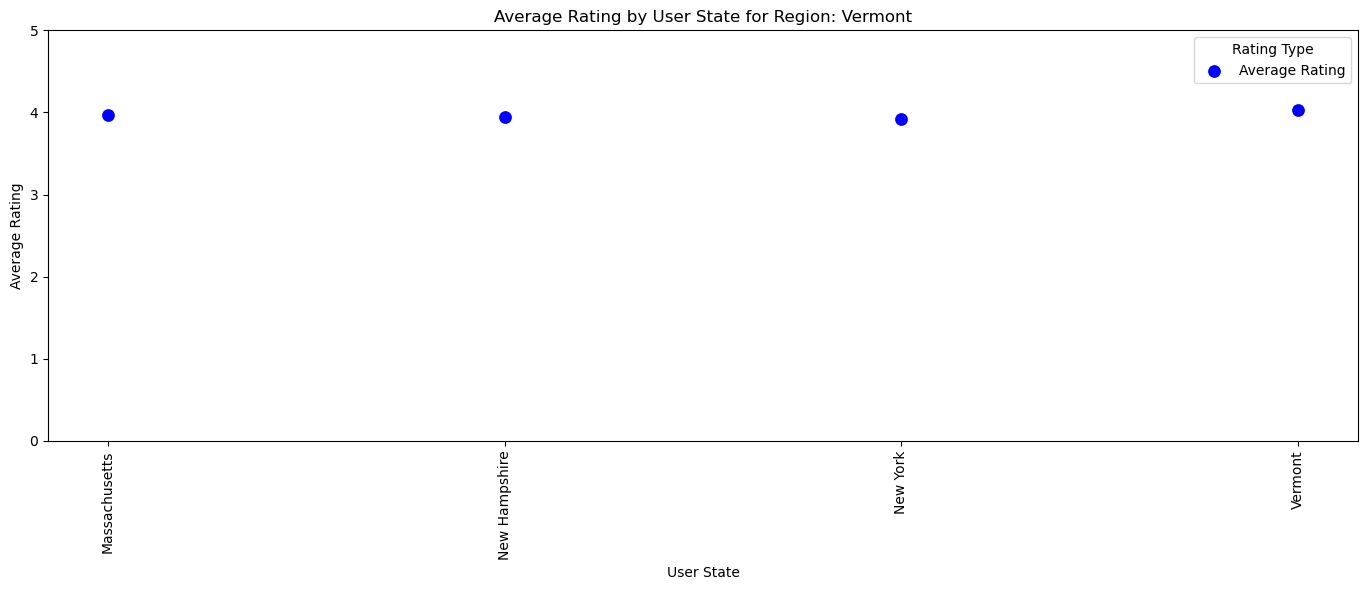

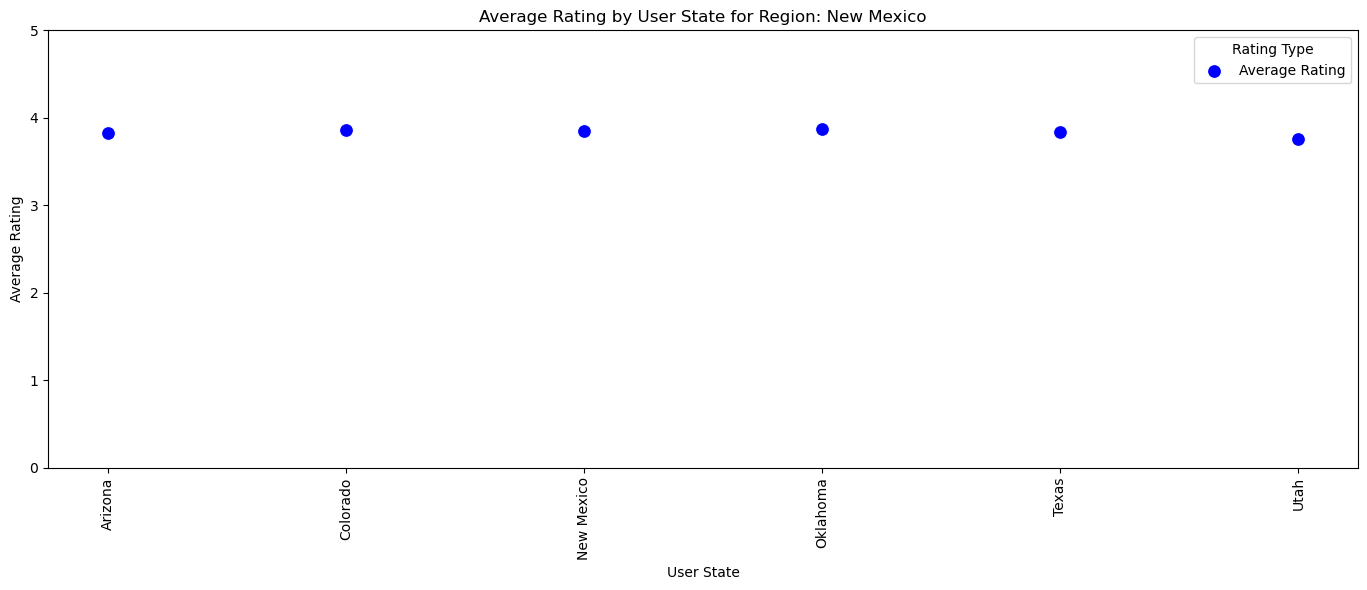

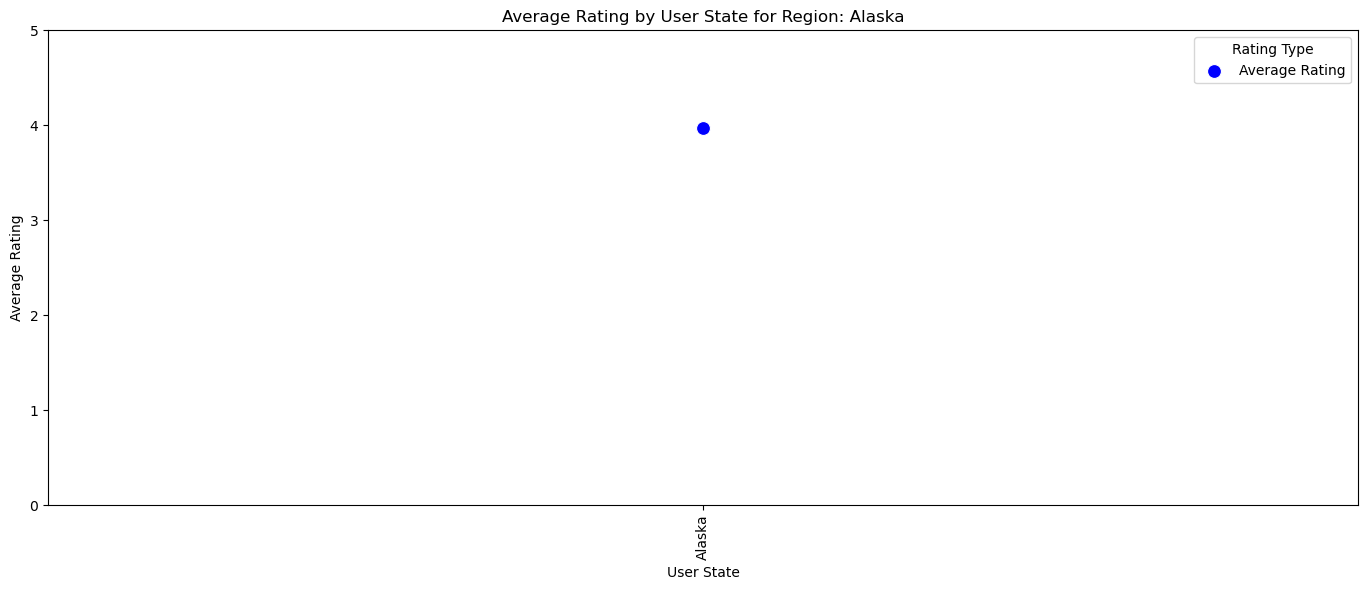

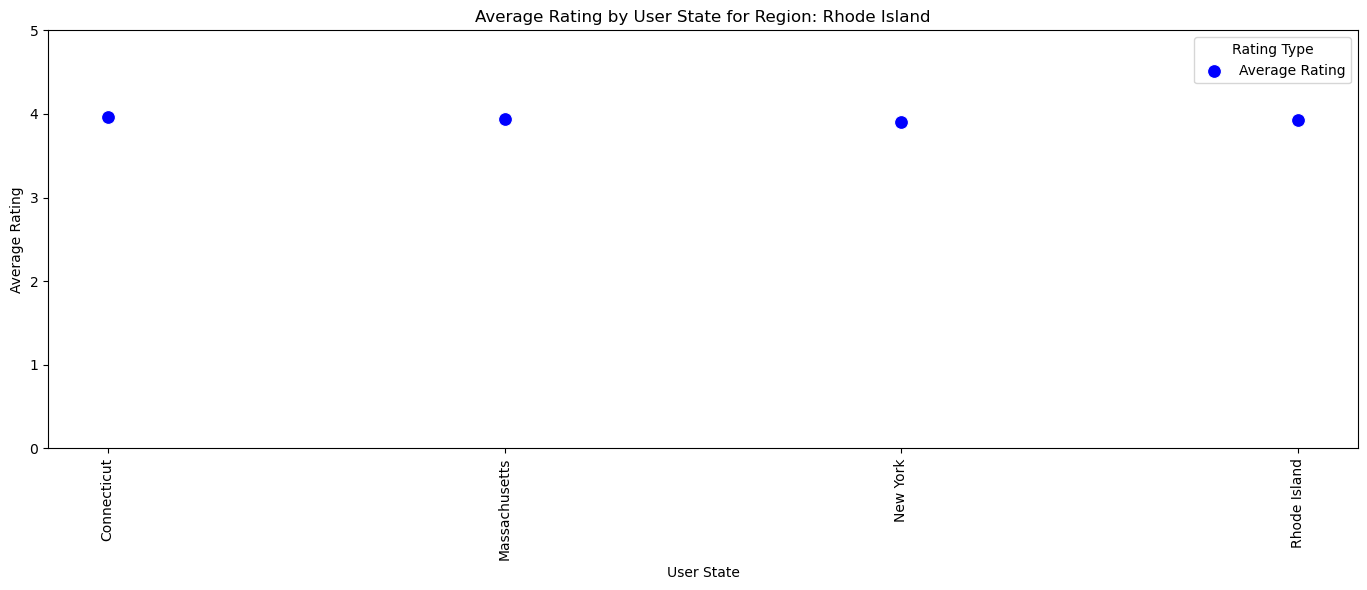

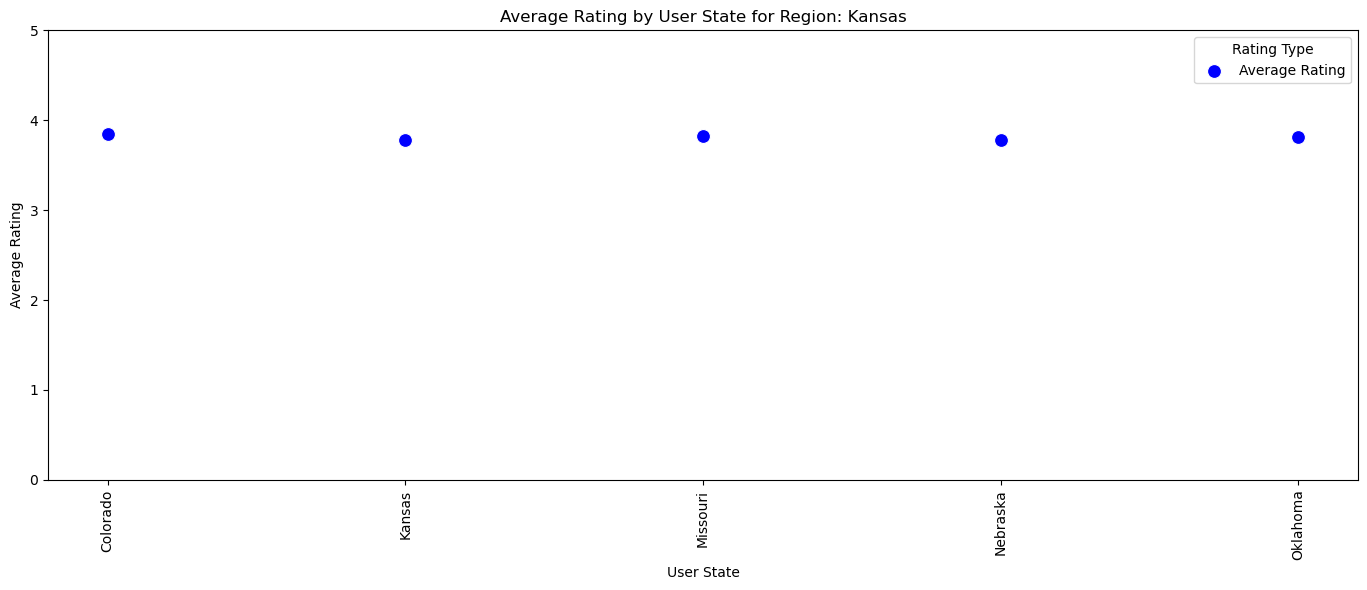

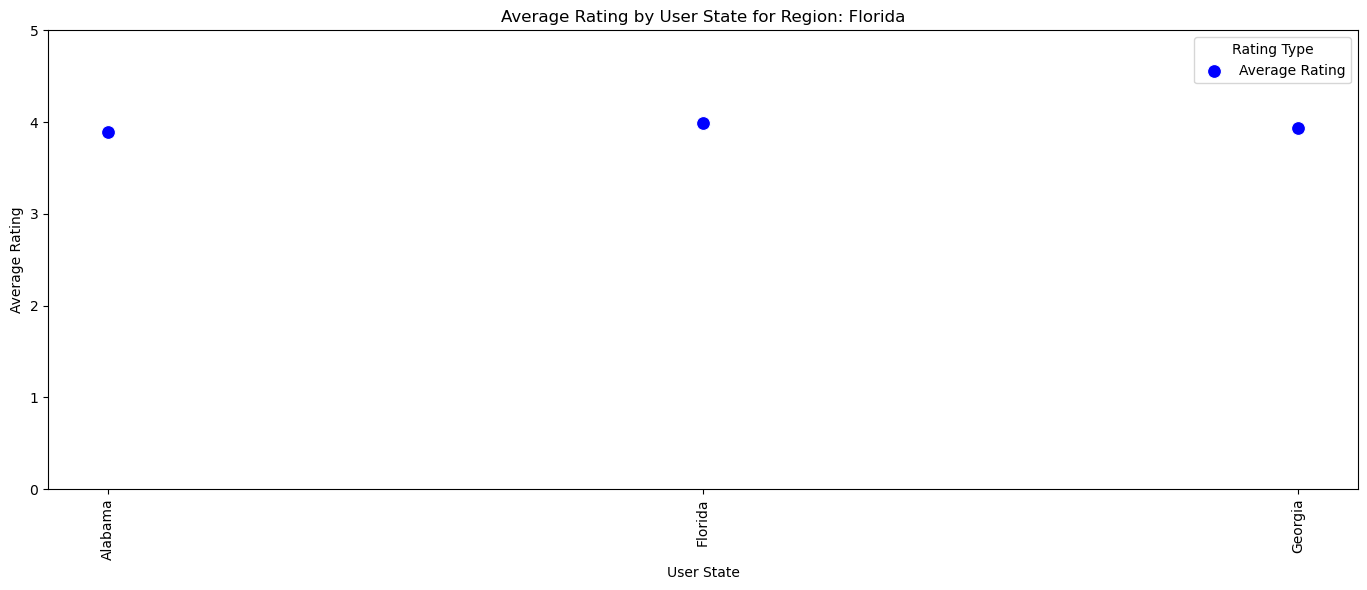

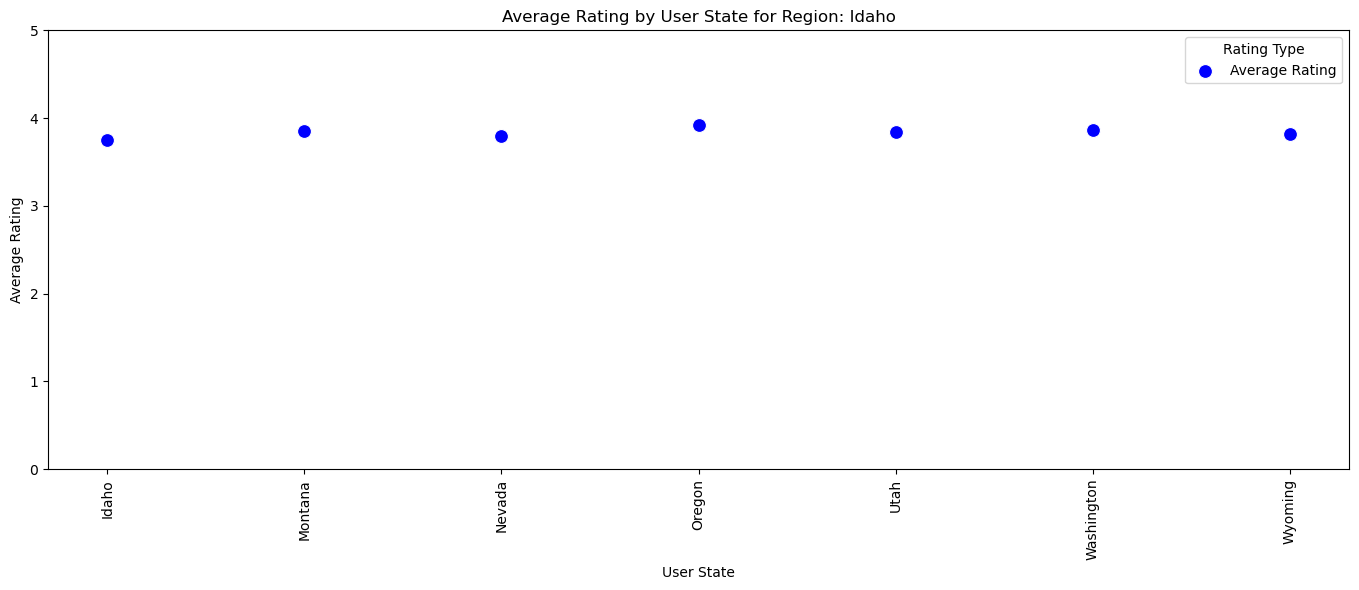

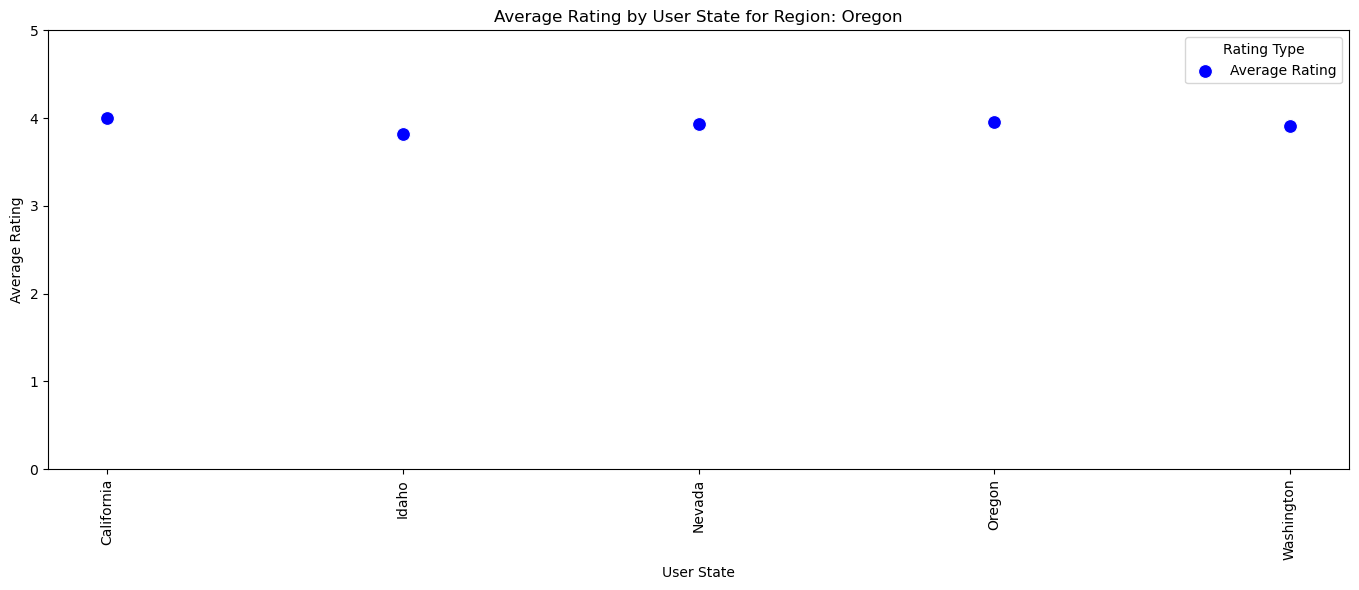

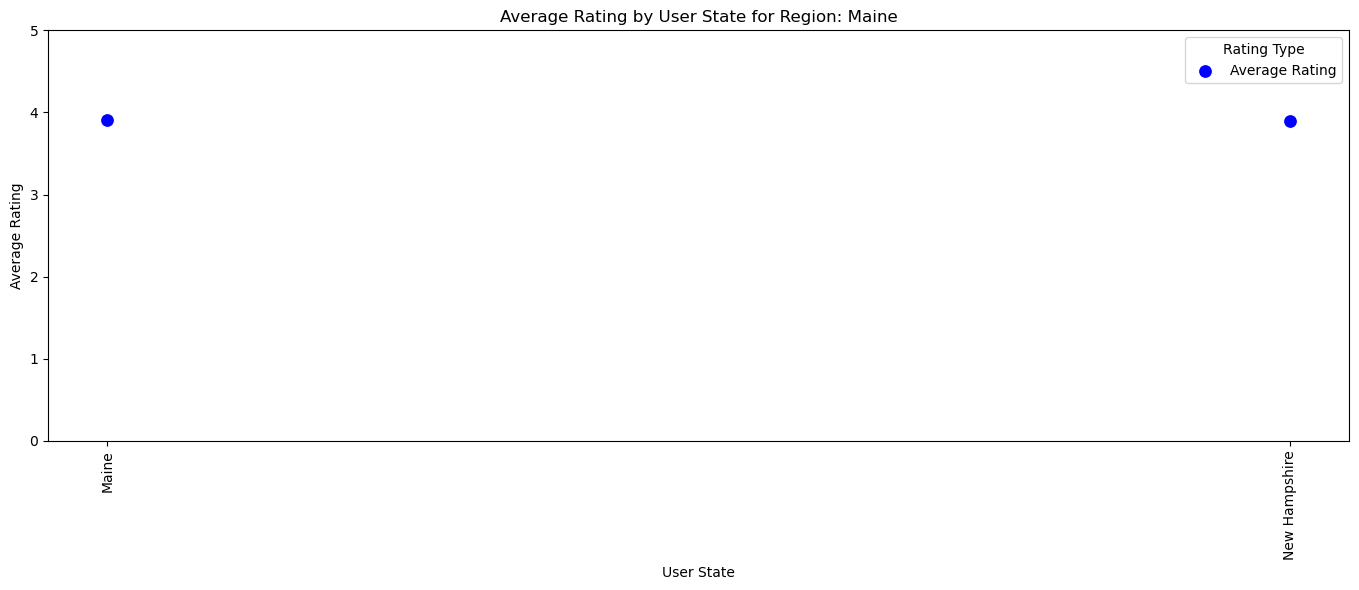

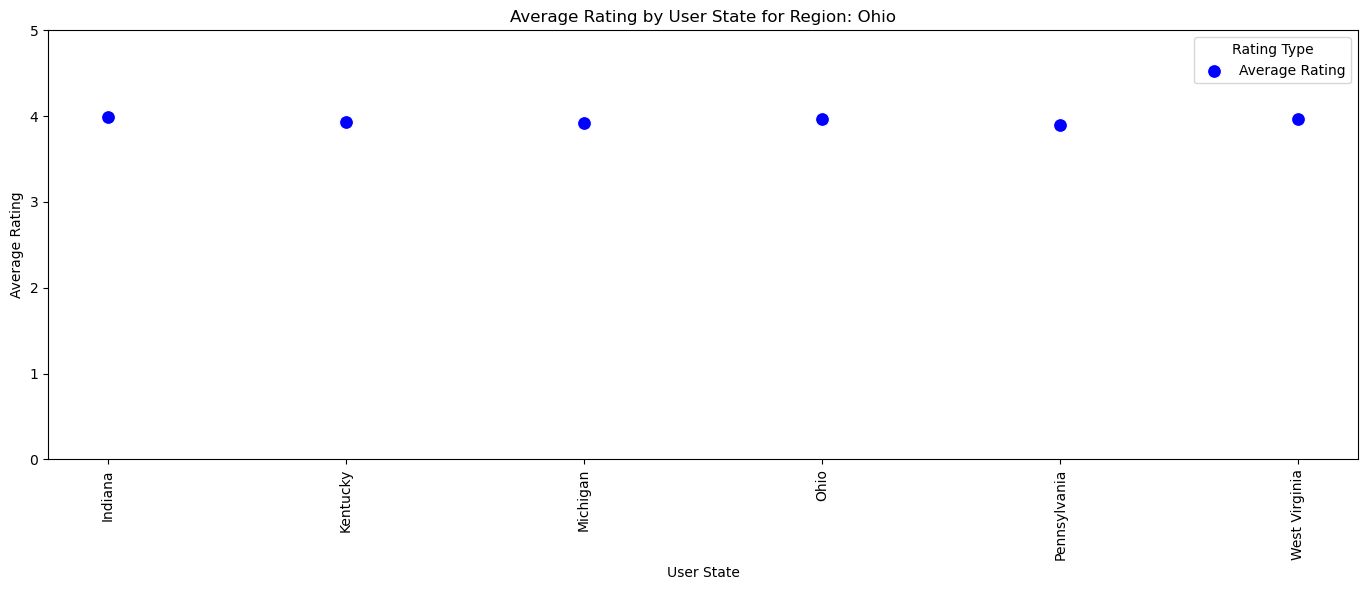

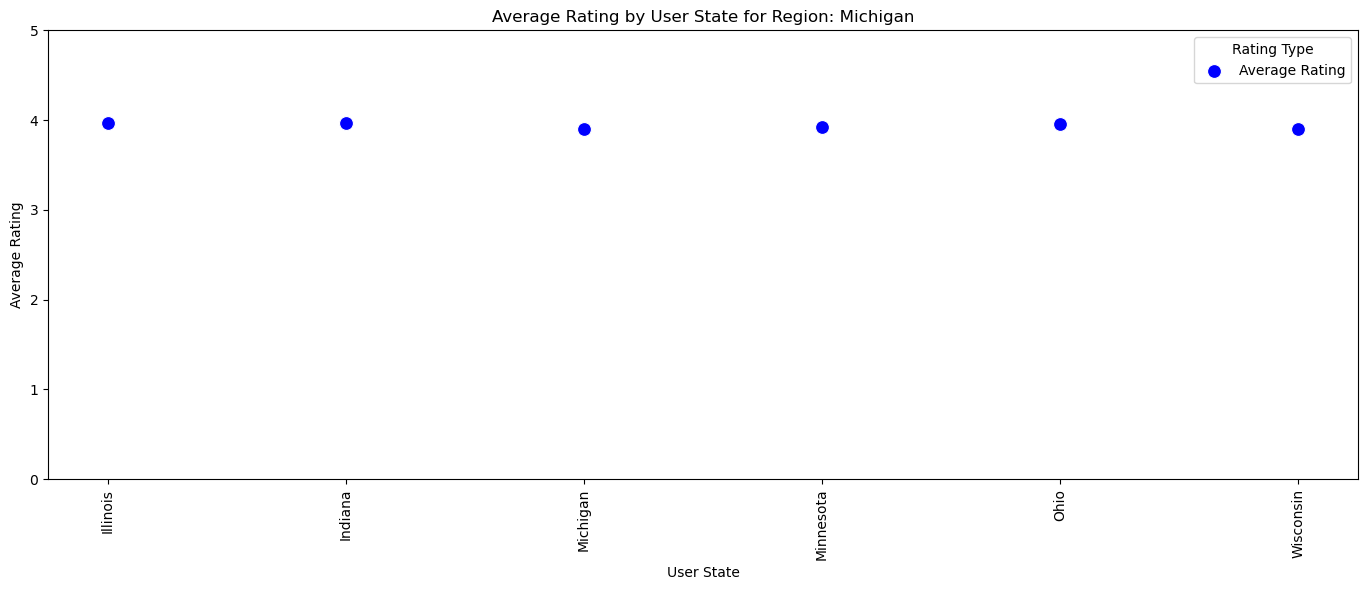

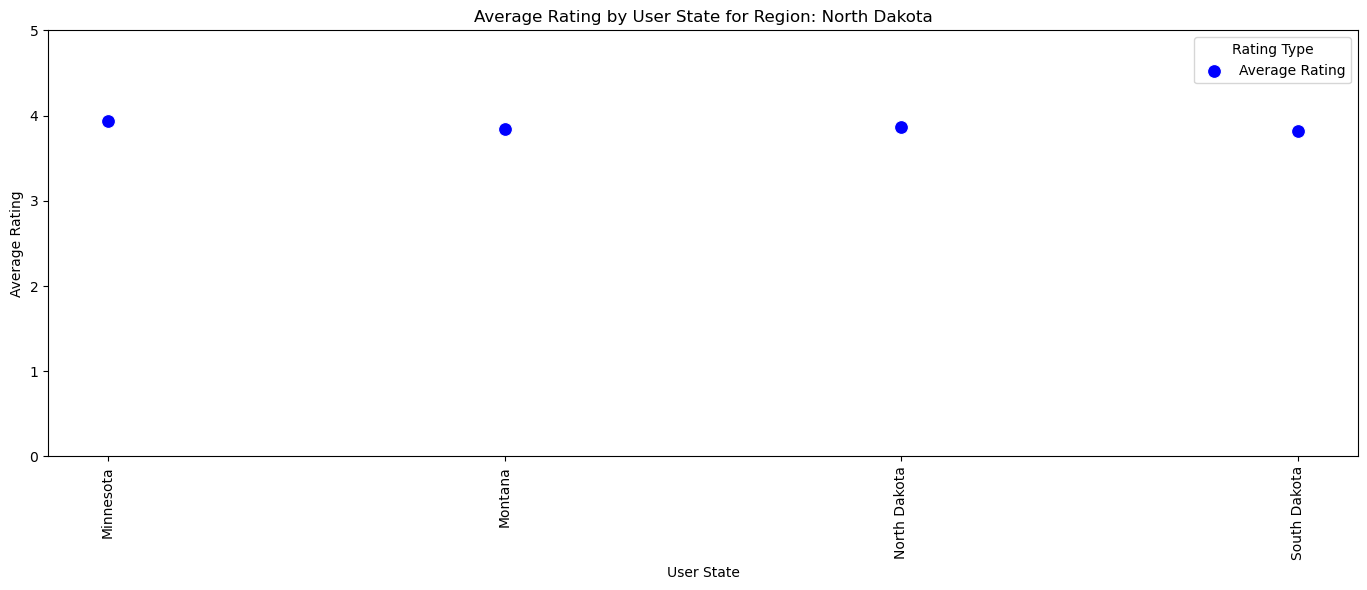

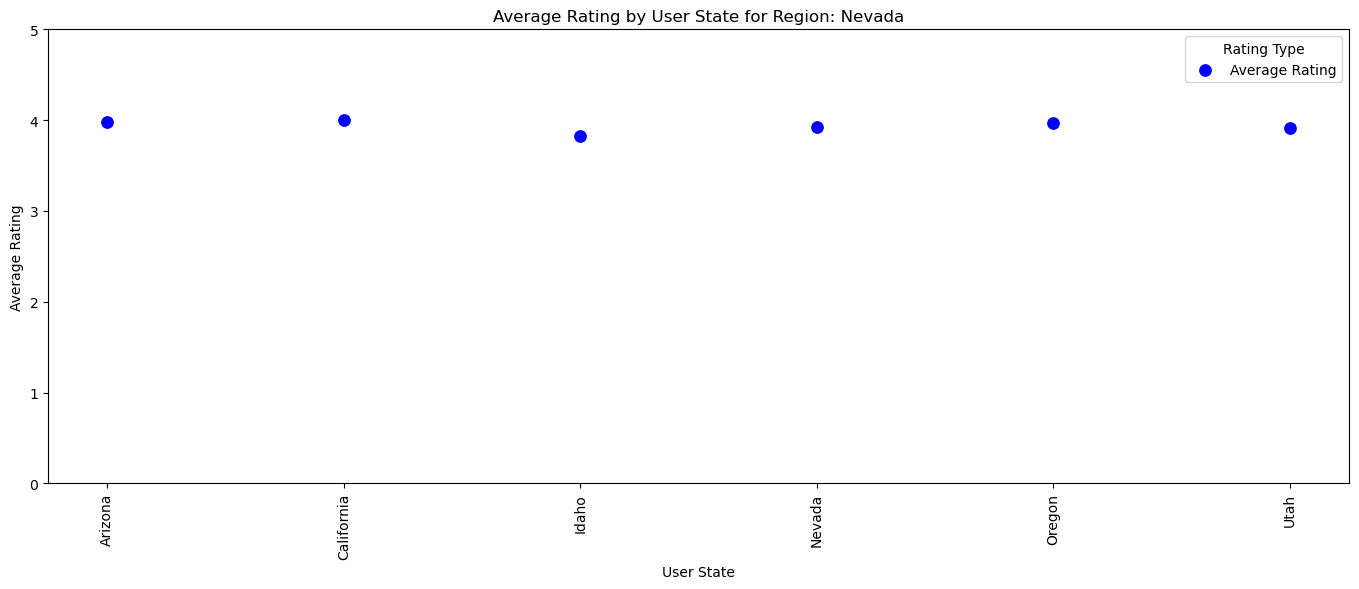

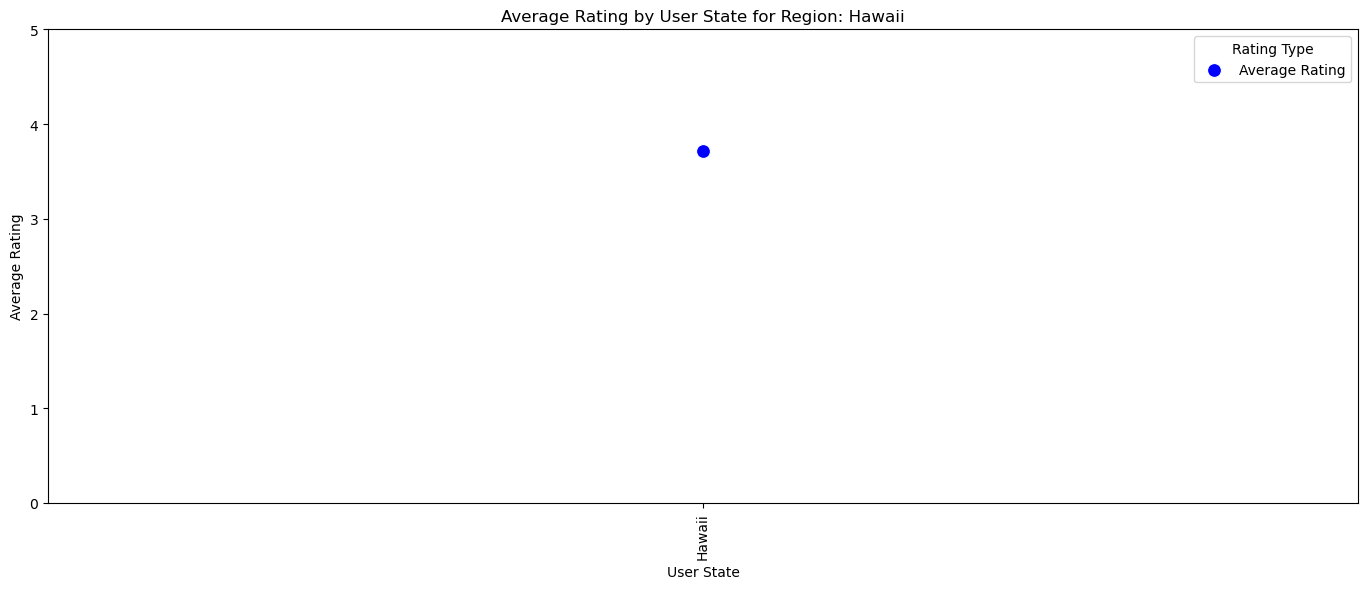

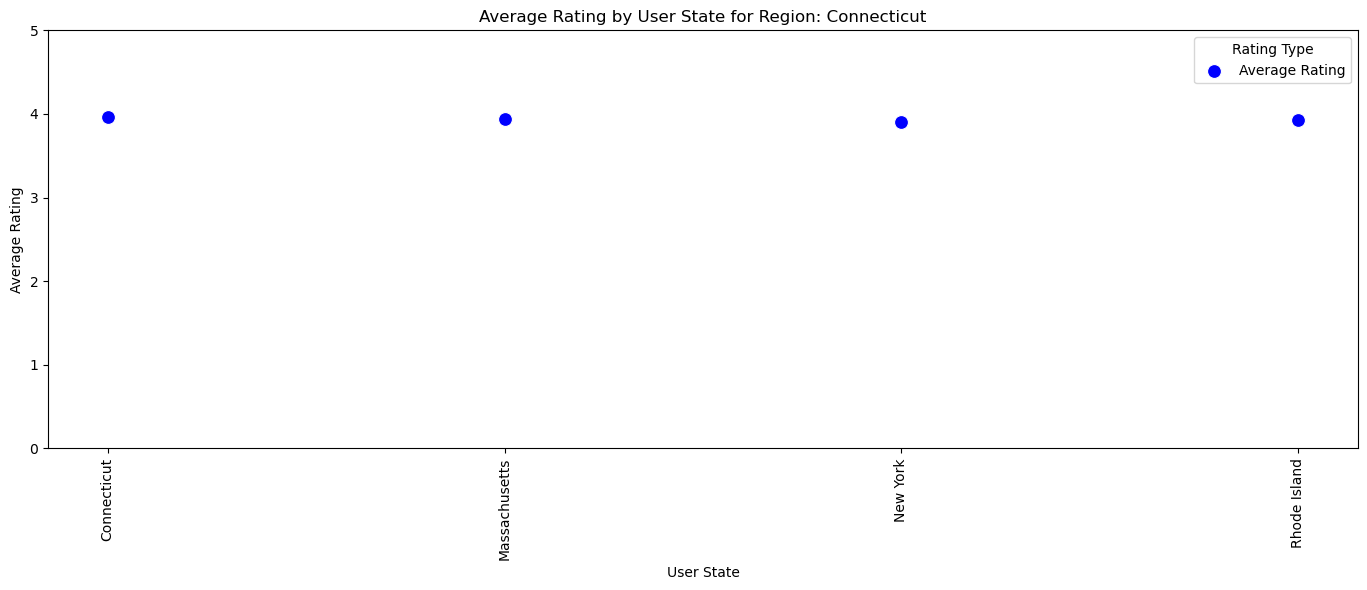

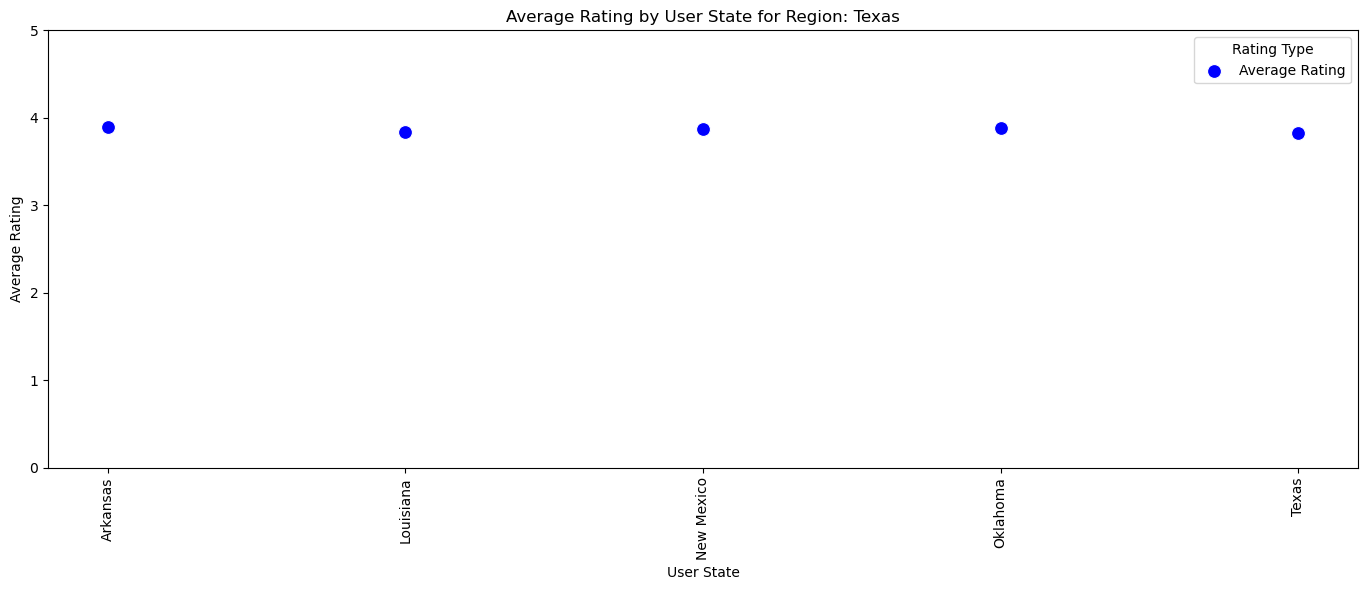

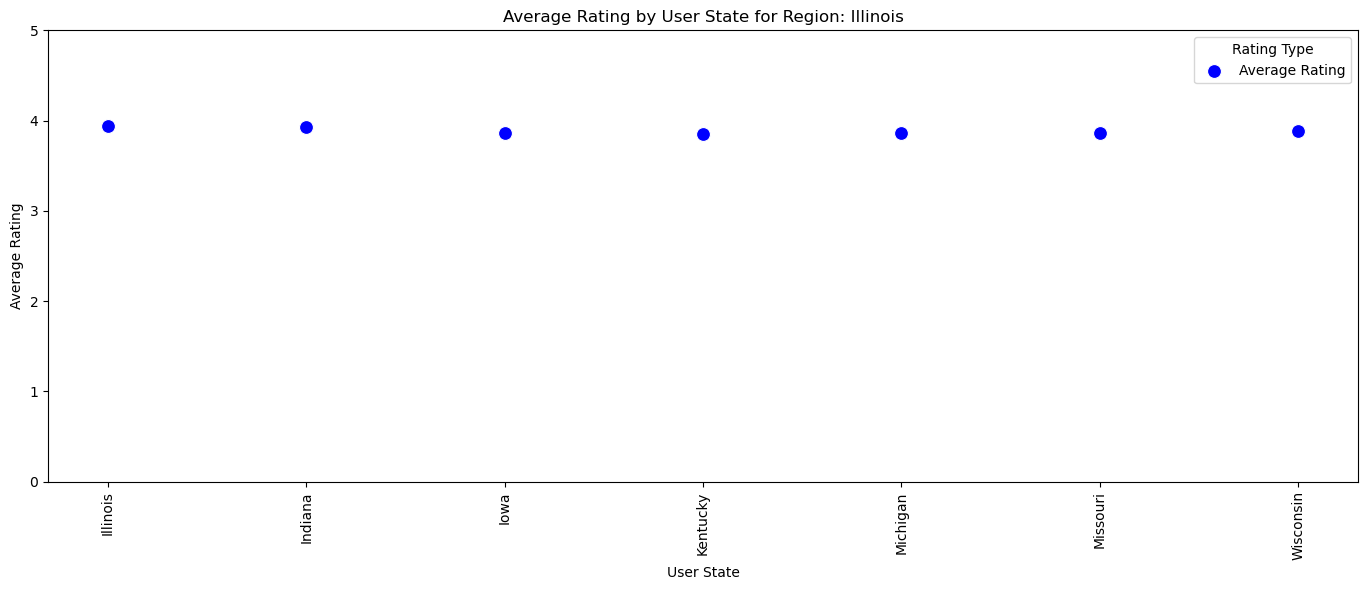

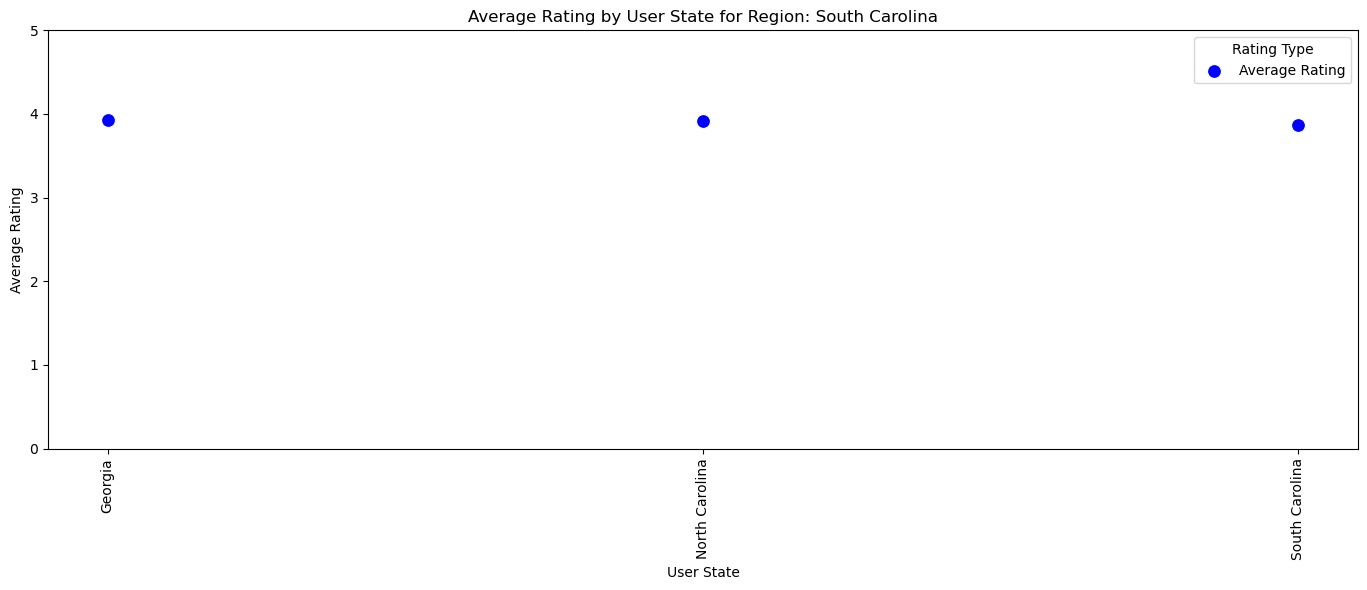

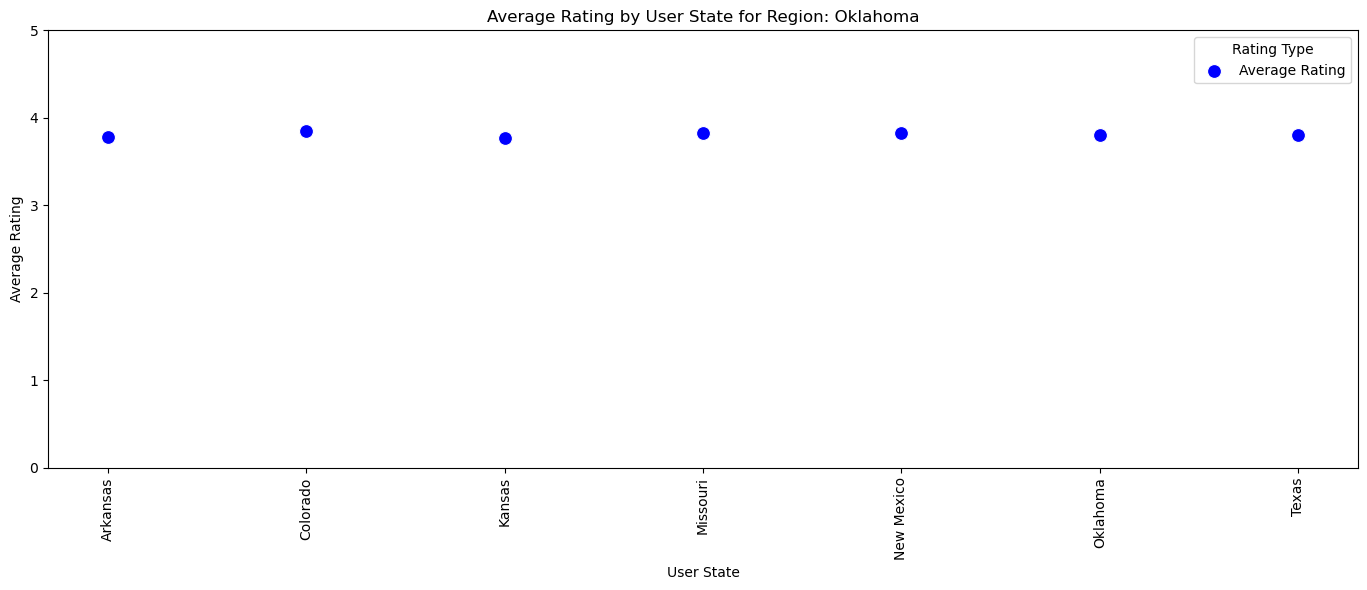

In [9]:
# Creating a scatter plot for each region displaying the average rating for each user state in region
for region in ratings_df['region'].unique():
    subset = ratings_df[ratings_df['region'] == region]
    
    avg_ratings = subset.groupby('user_state')['rating'].mean().reset_index()
    
    plt.figure(figsize=(14, 6))
    
    sns.scatterplot(data=avg_ratings, x='user_state', y='rating', color='blue', s=100, marker='o', label='Average Rating')

    plt.title(f'Average Rating by User State for Region: {region}')
    plt.xlabel('User State')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=90)
    plt.legend(title='Rating Type')
    plt.tight_layout()
    plt.ylim(0,5)

    plt.show()


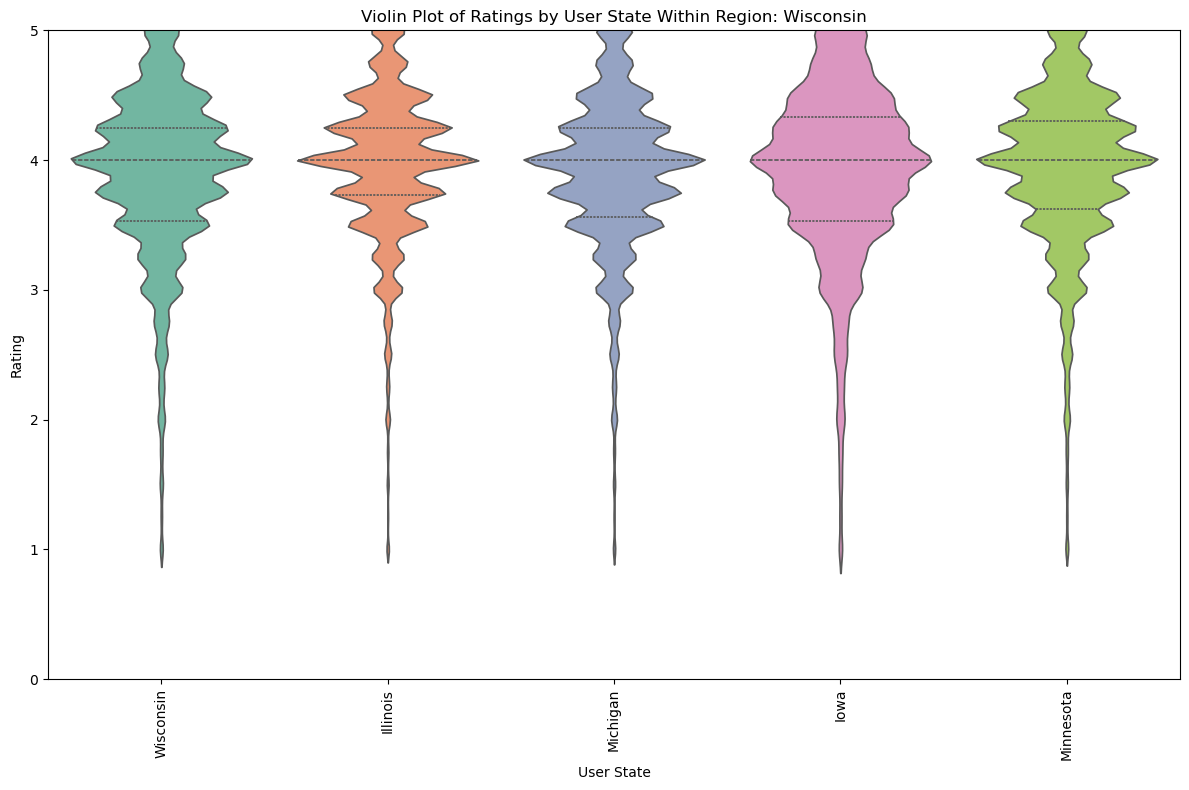

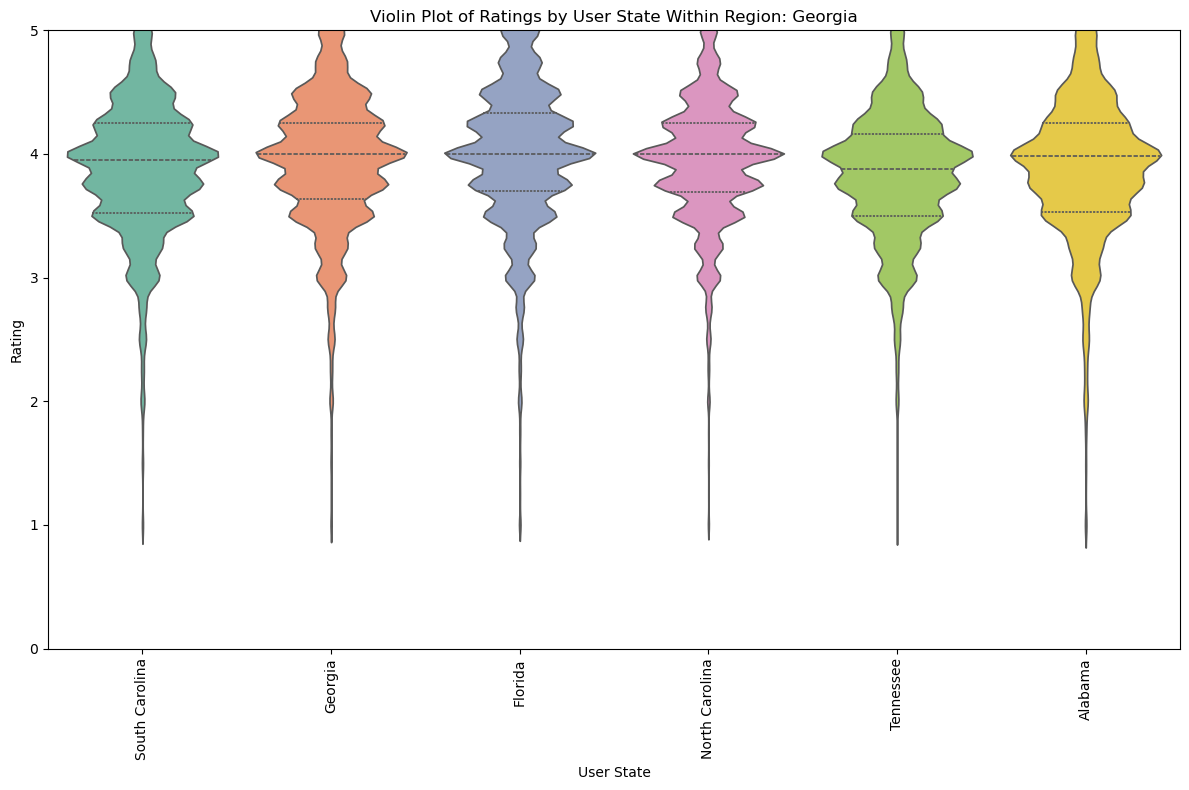

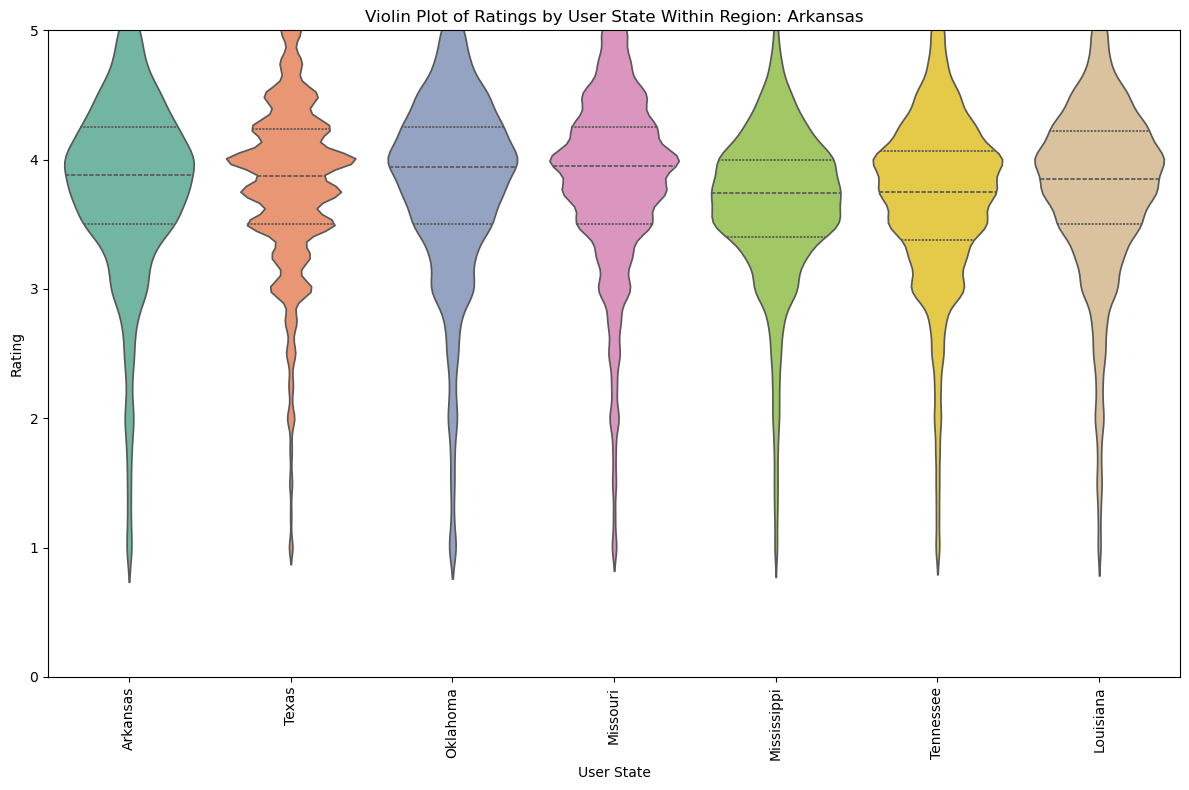

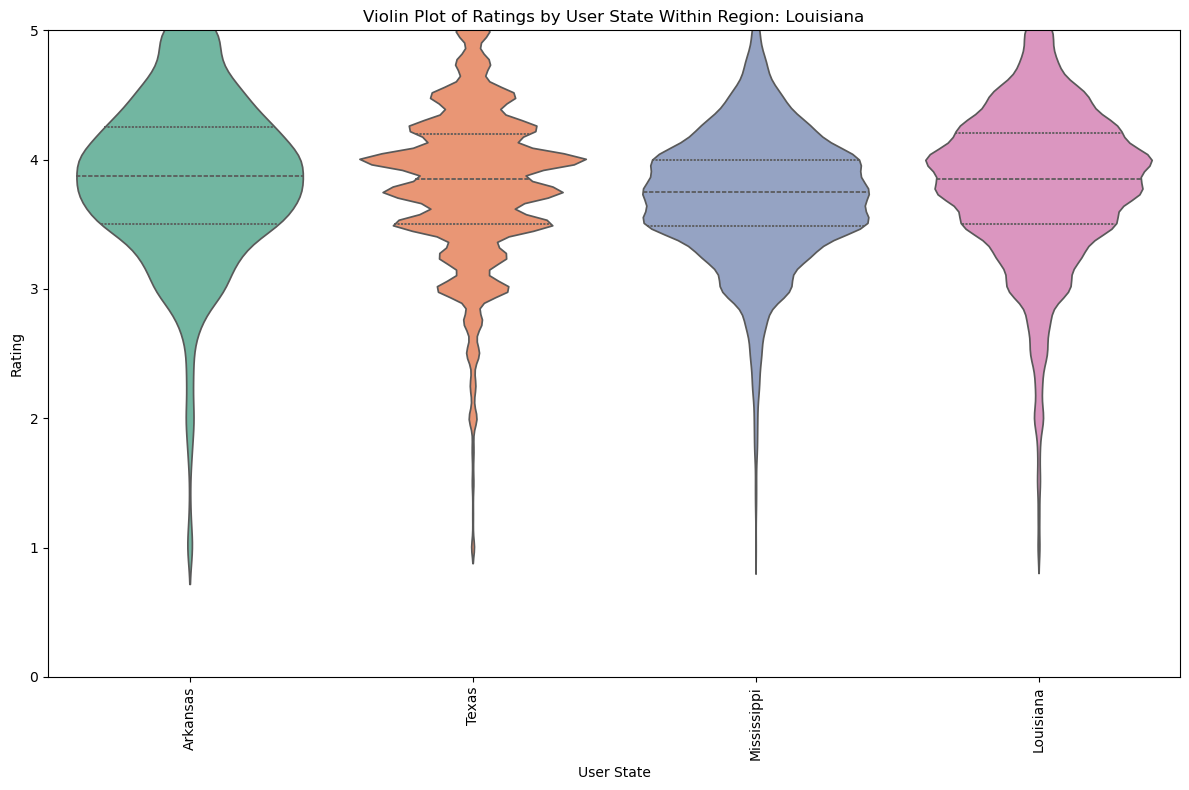

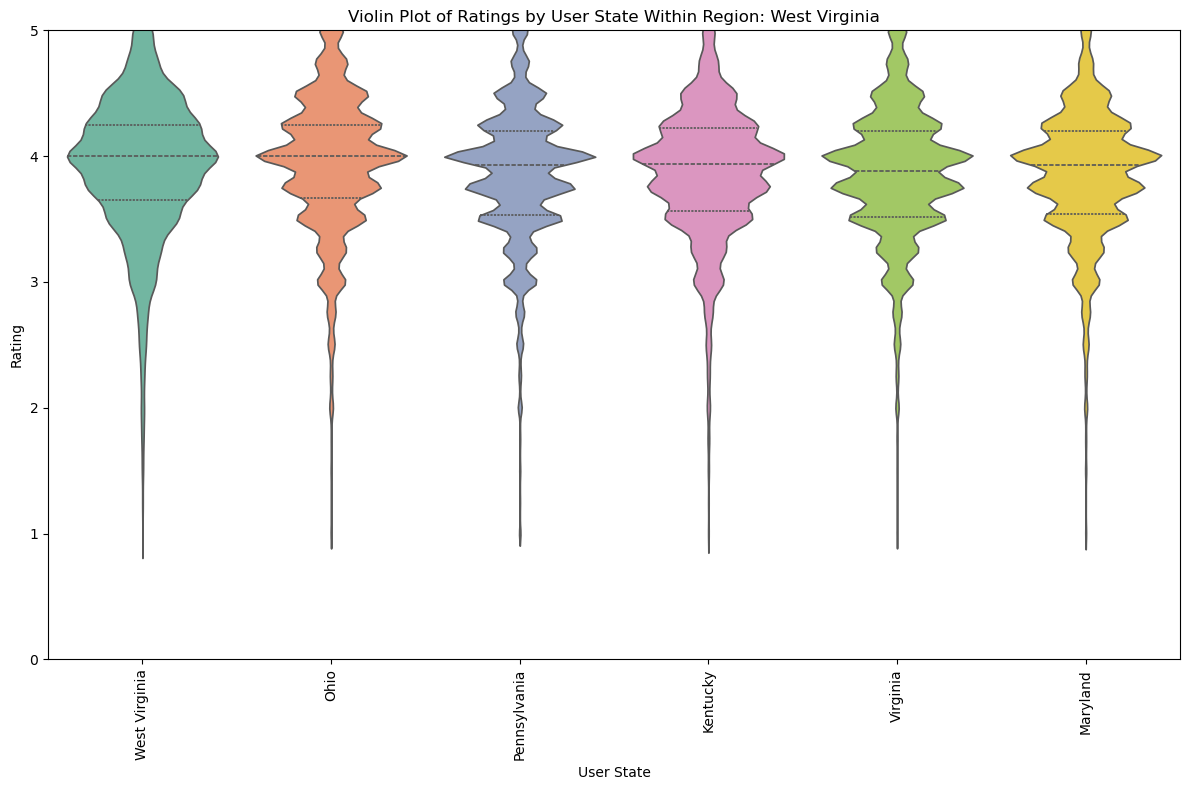

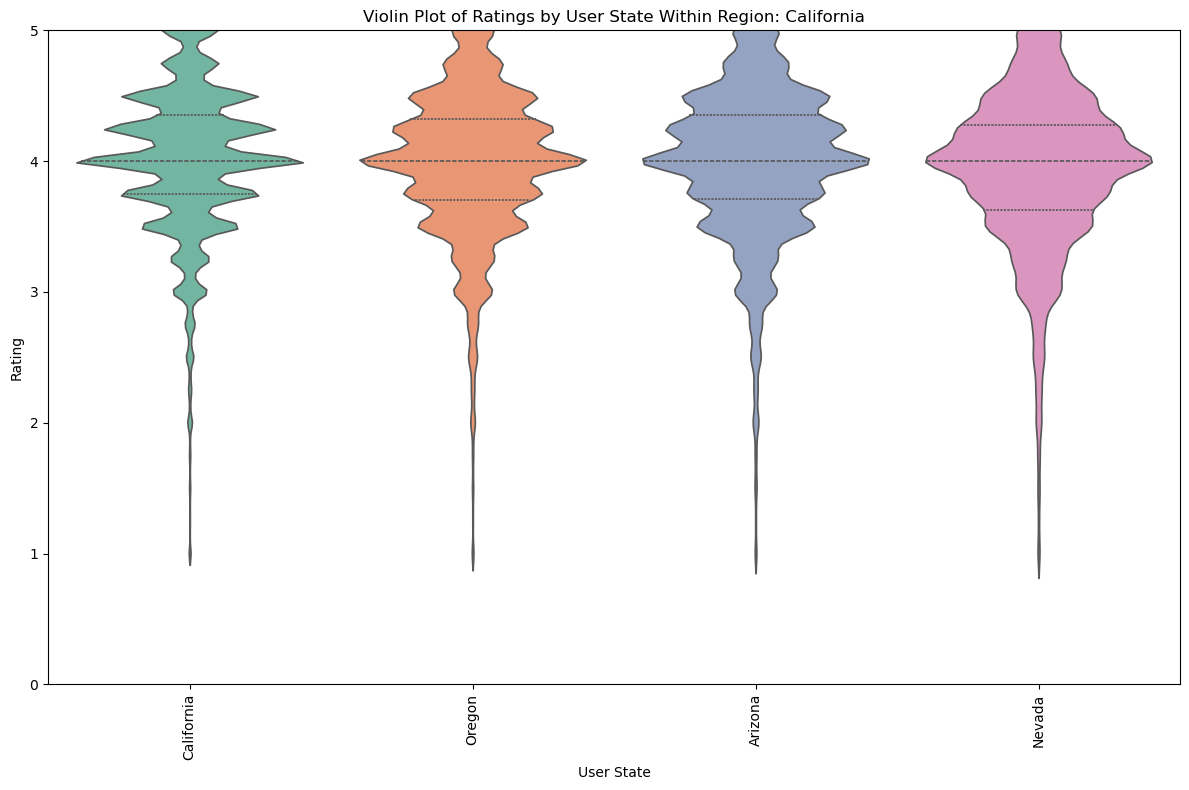

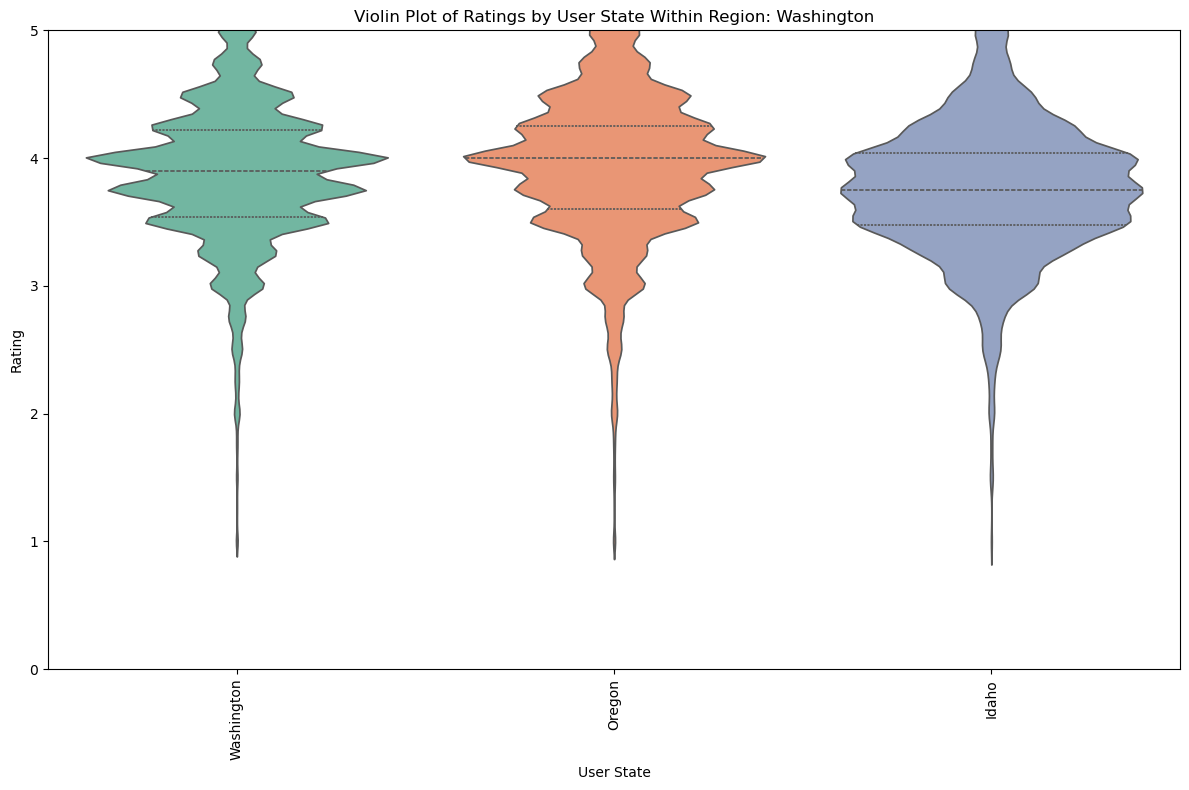

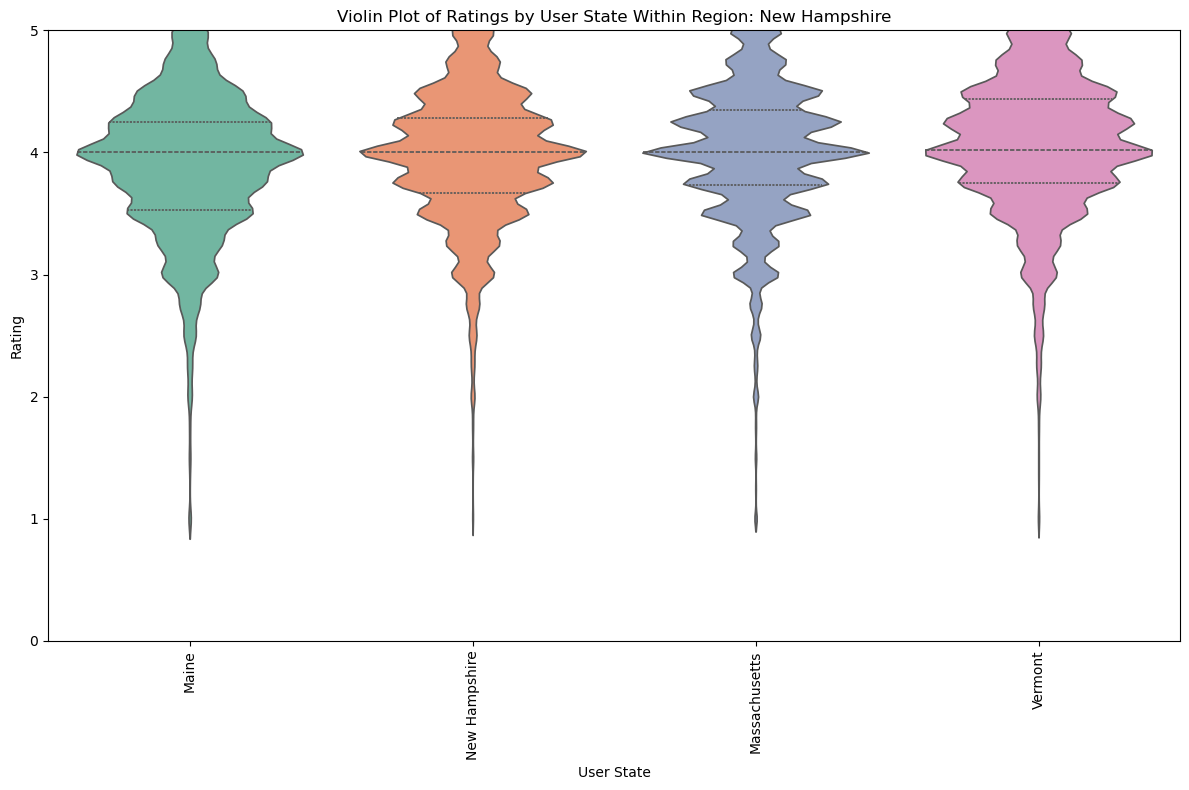

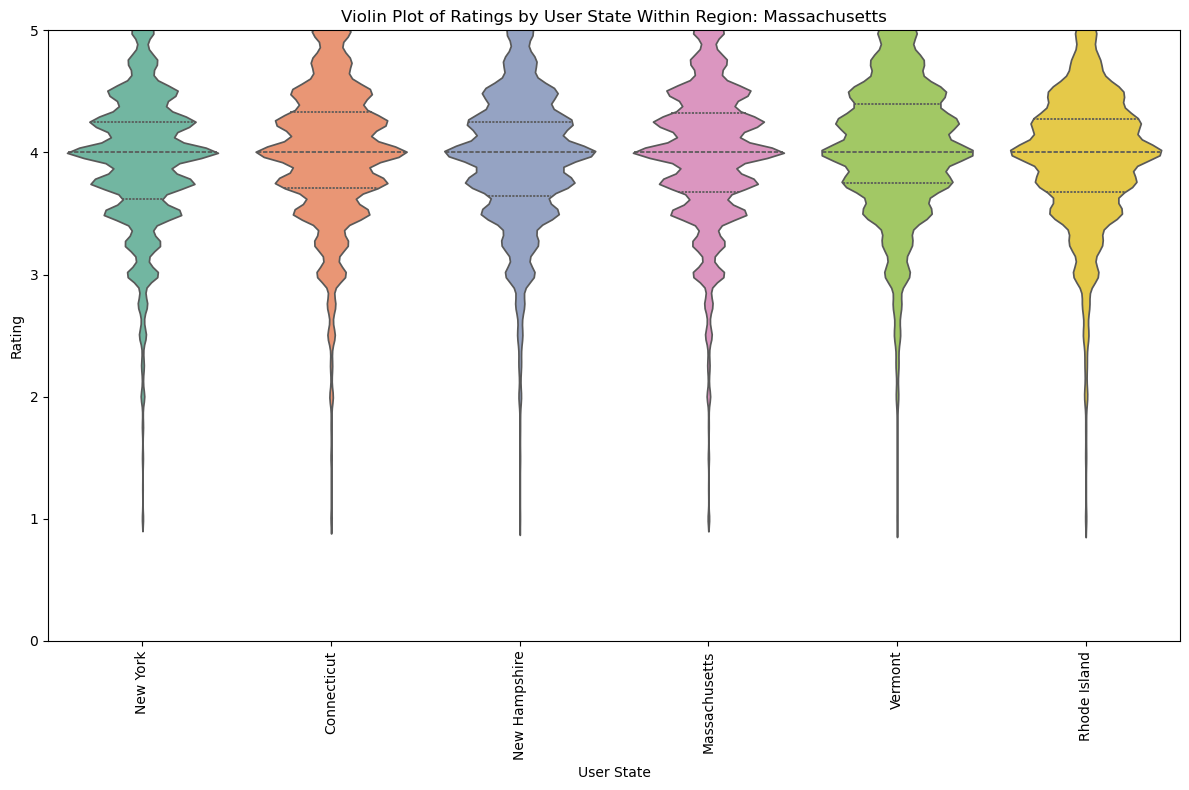

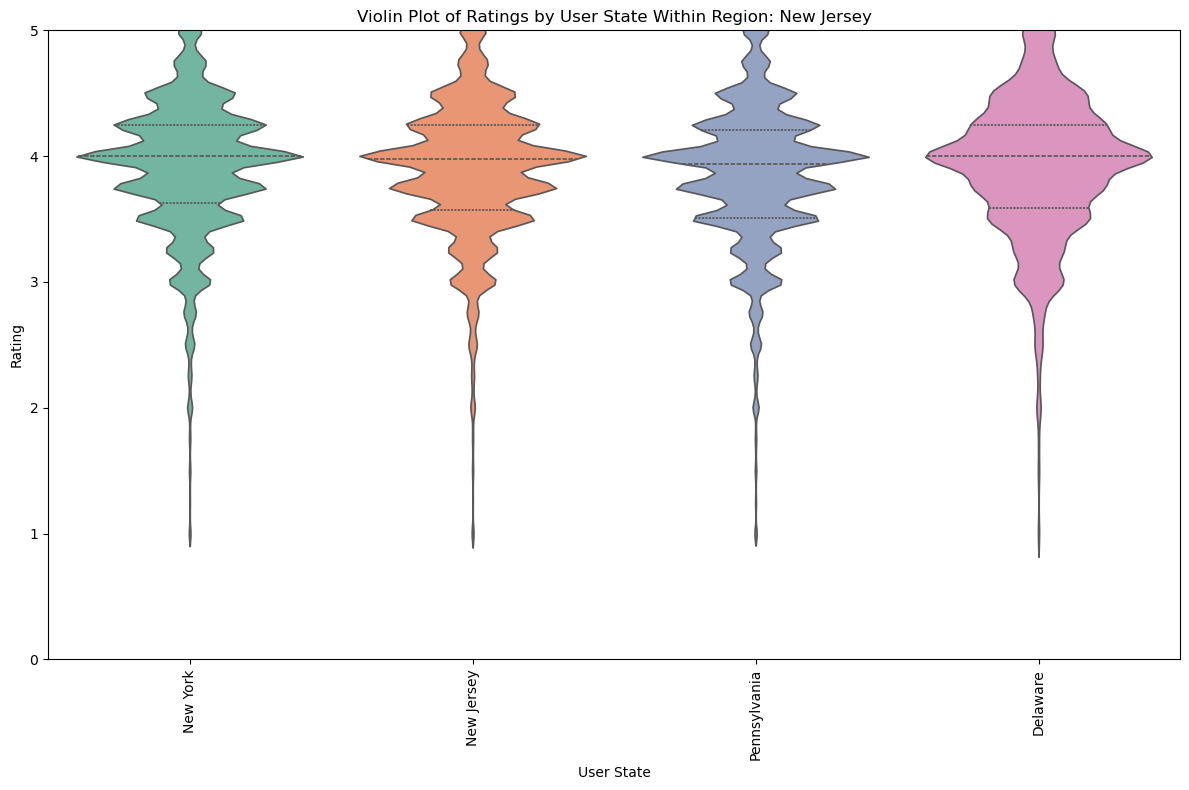

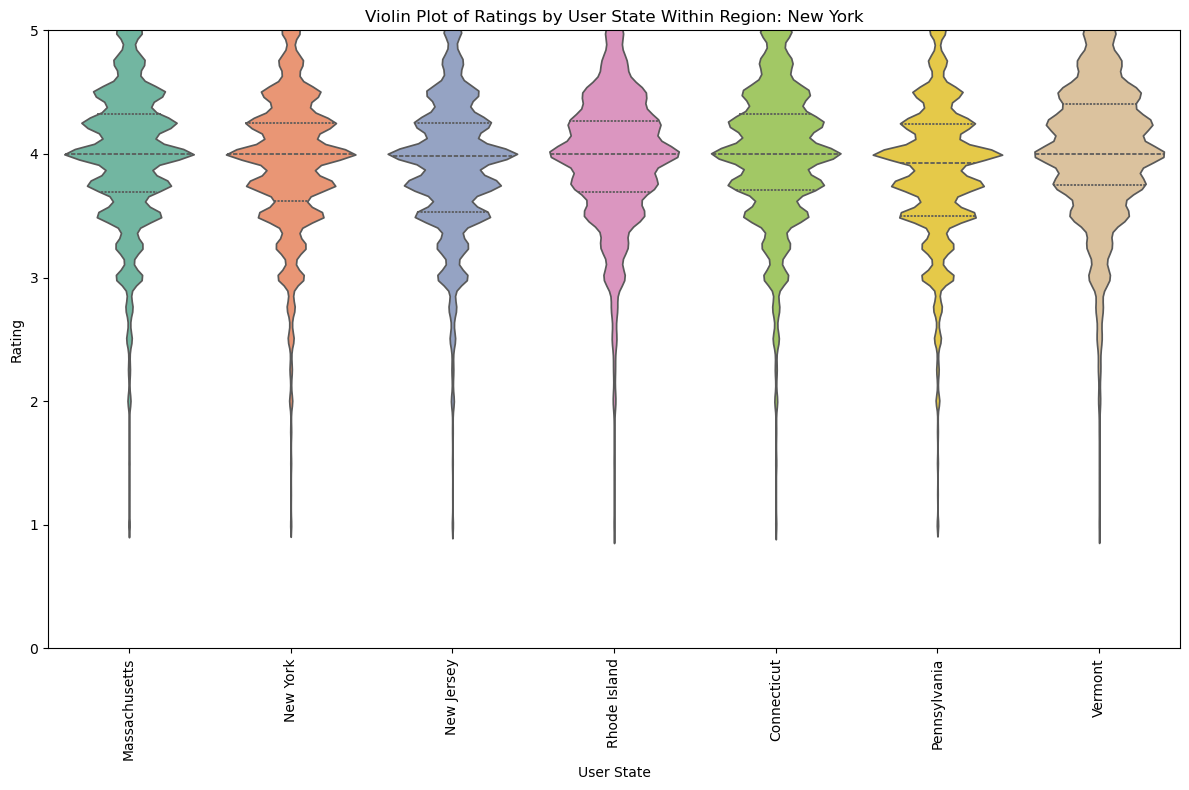

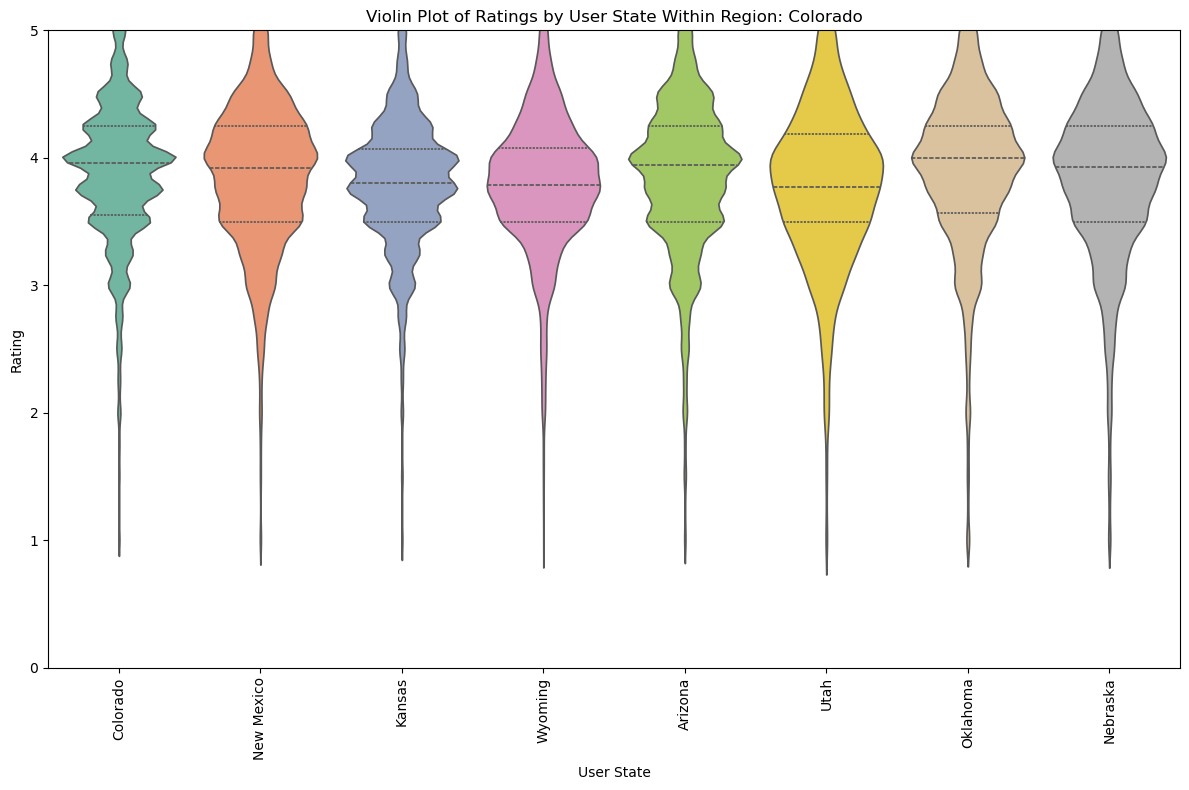

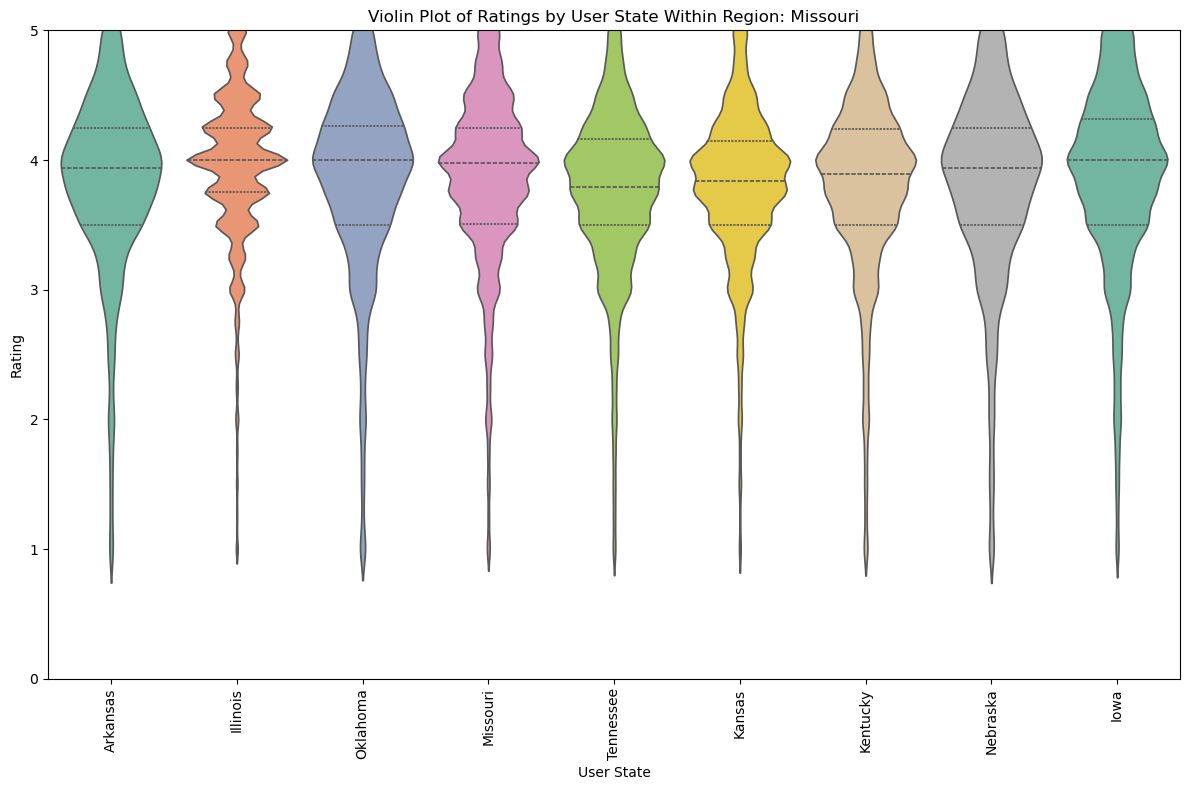

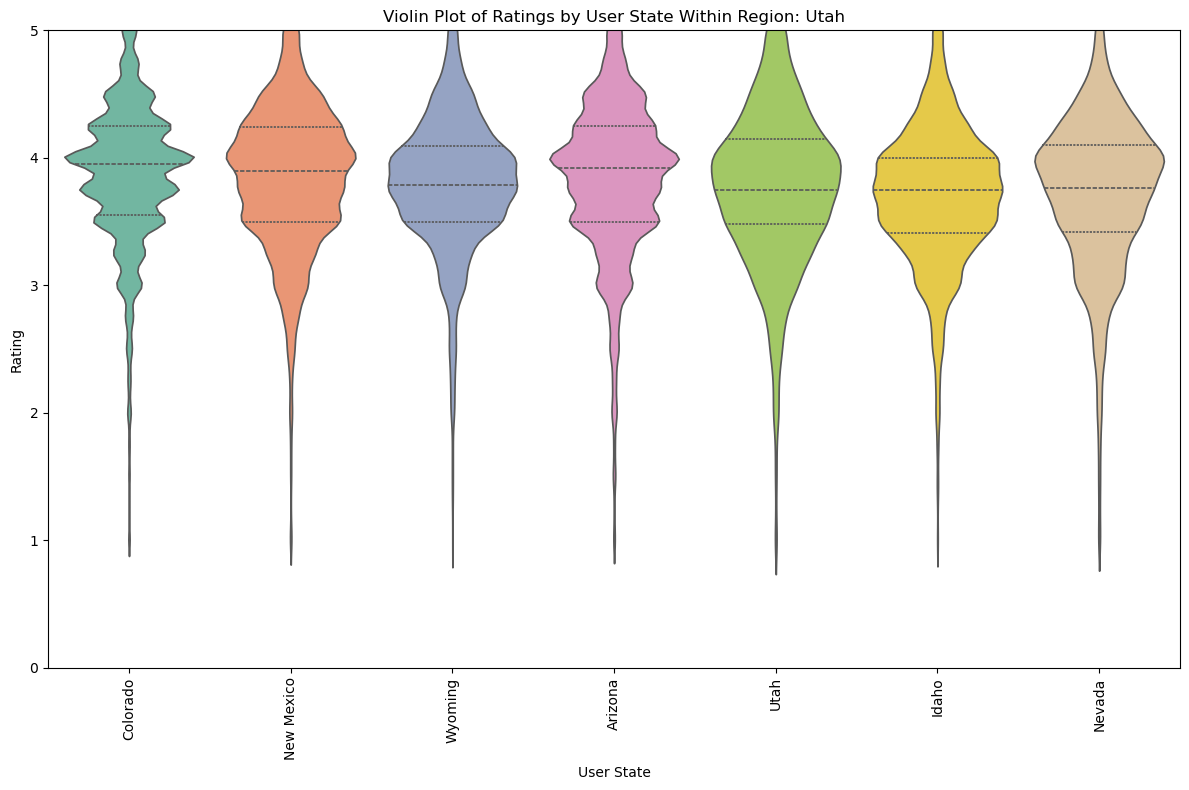

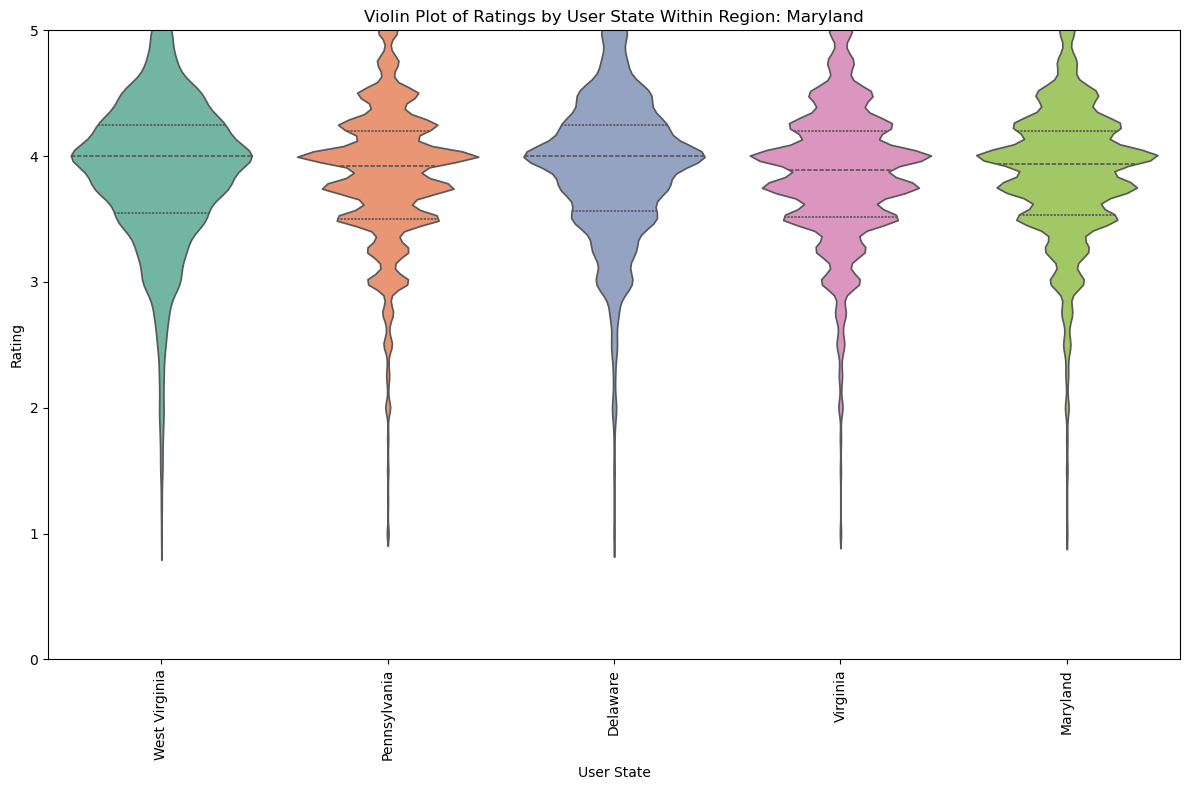

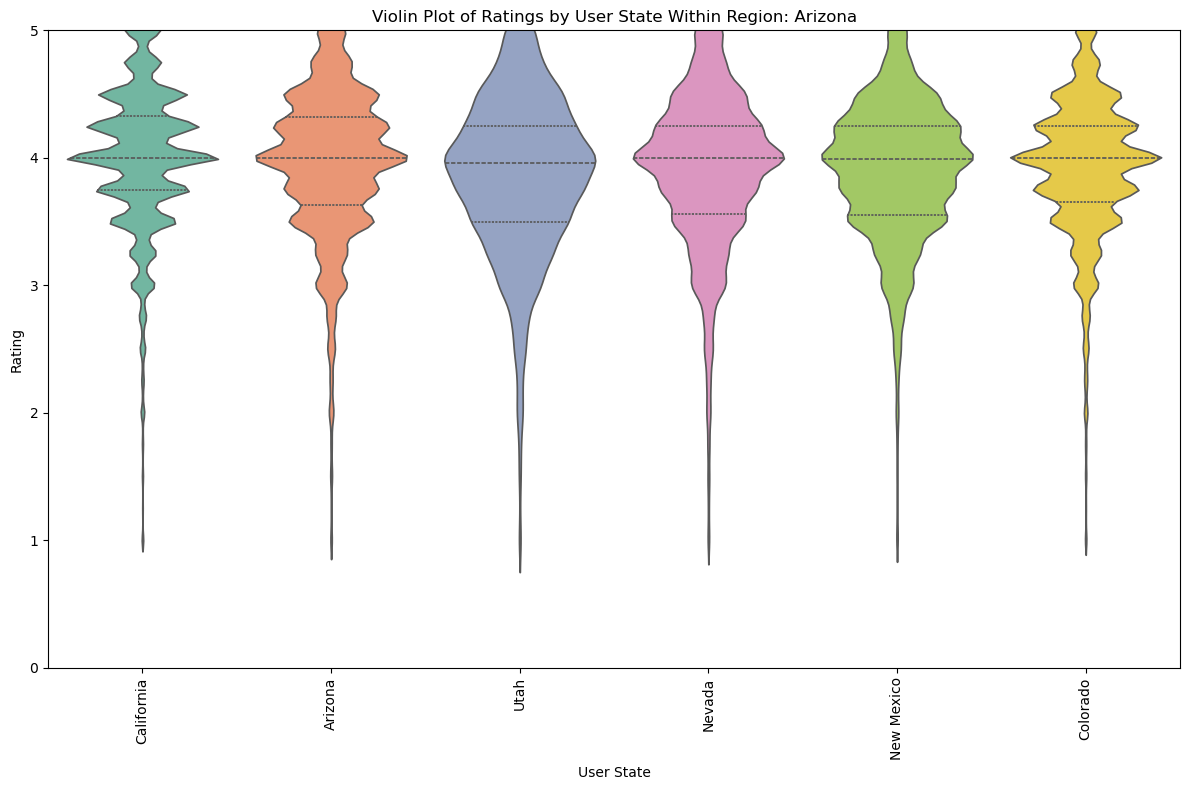

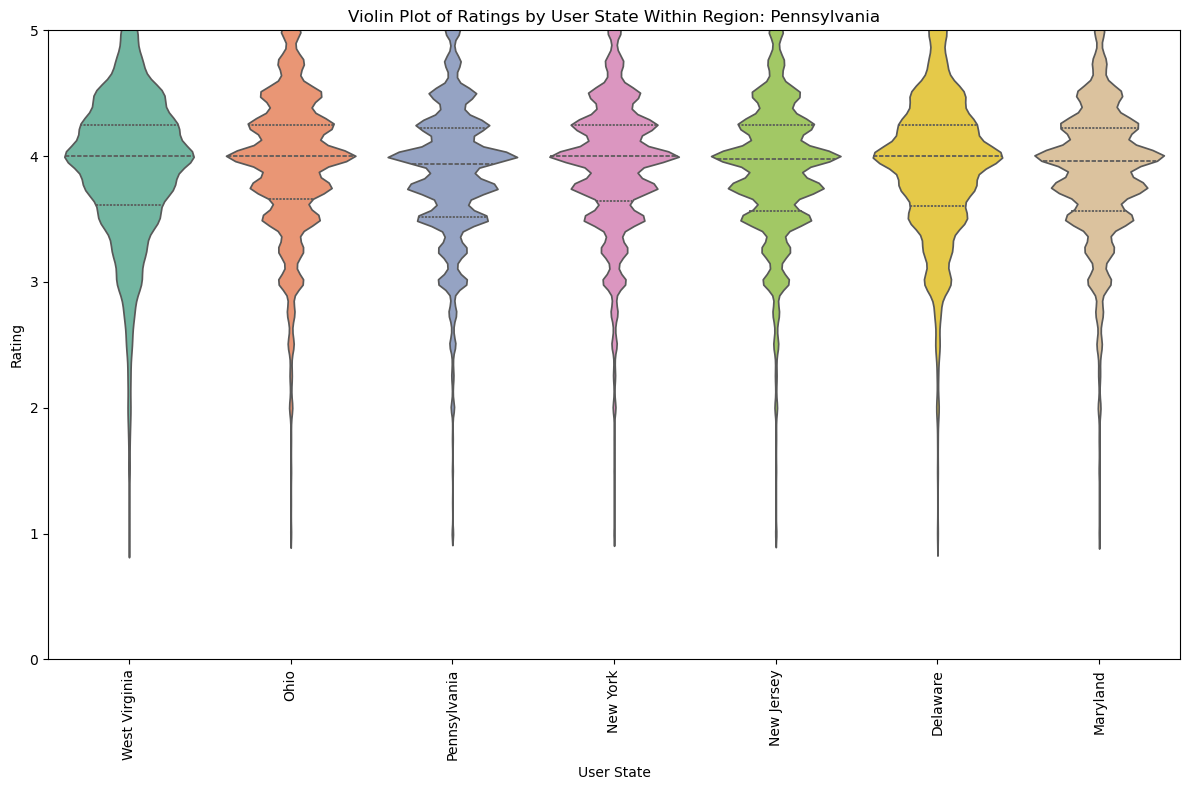

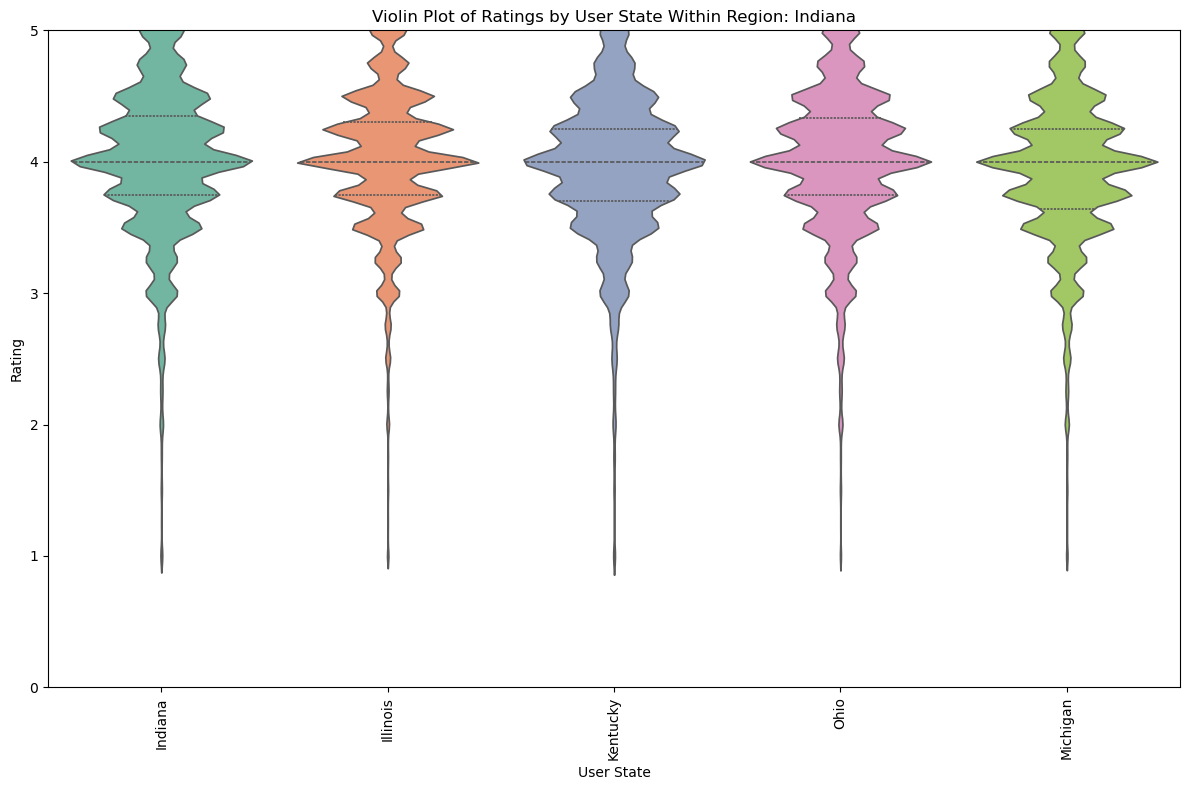

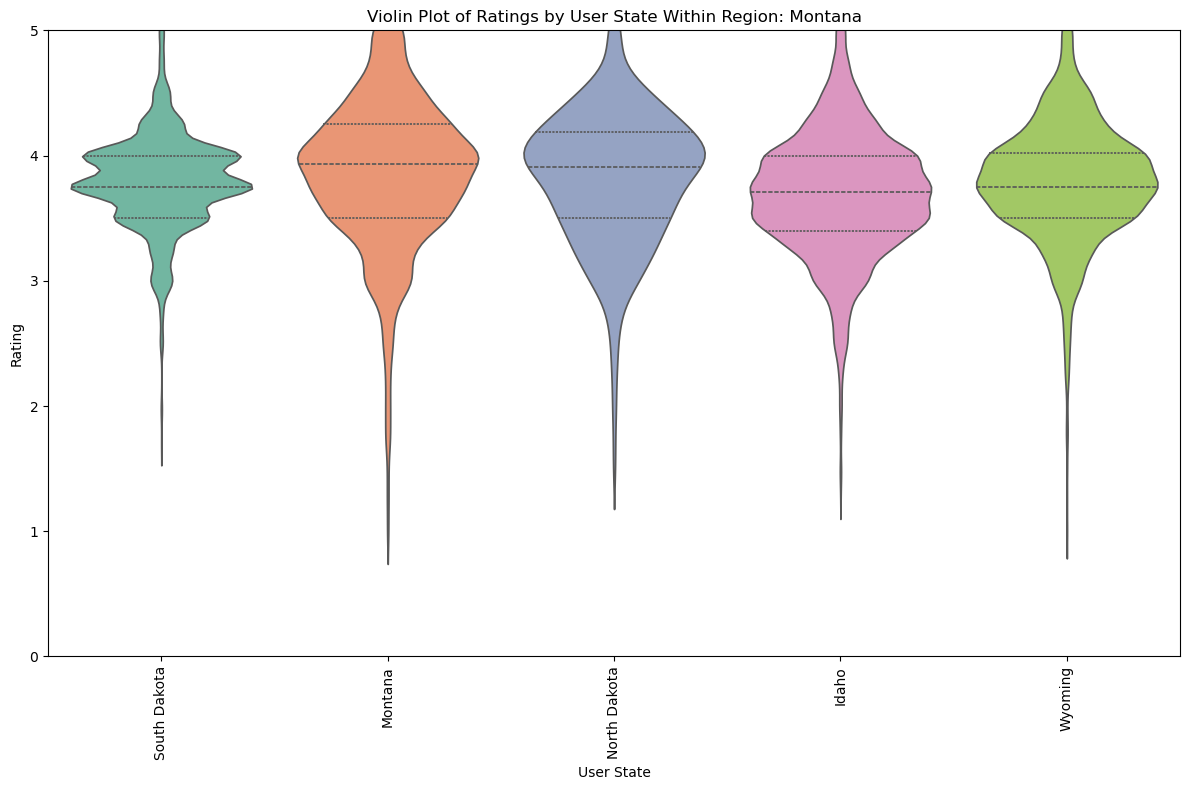

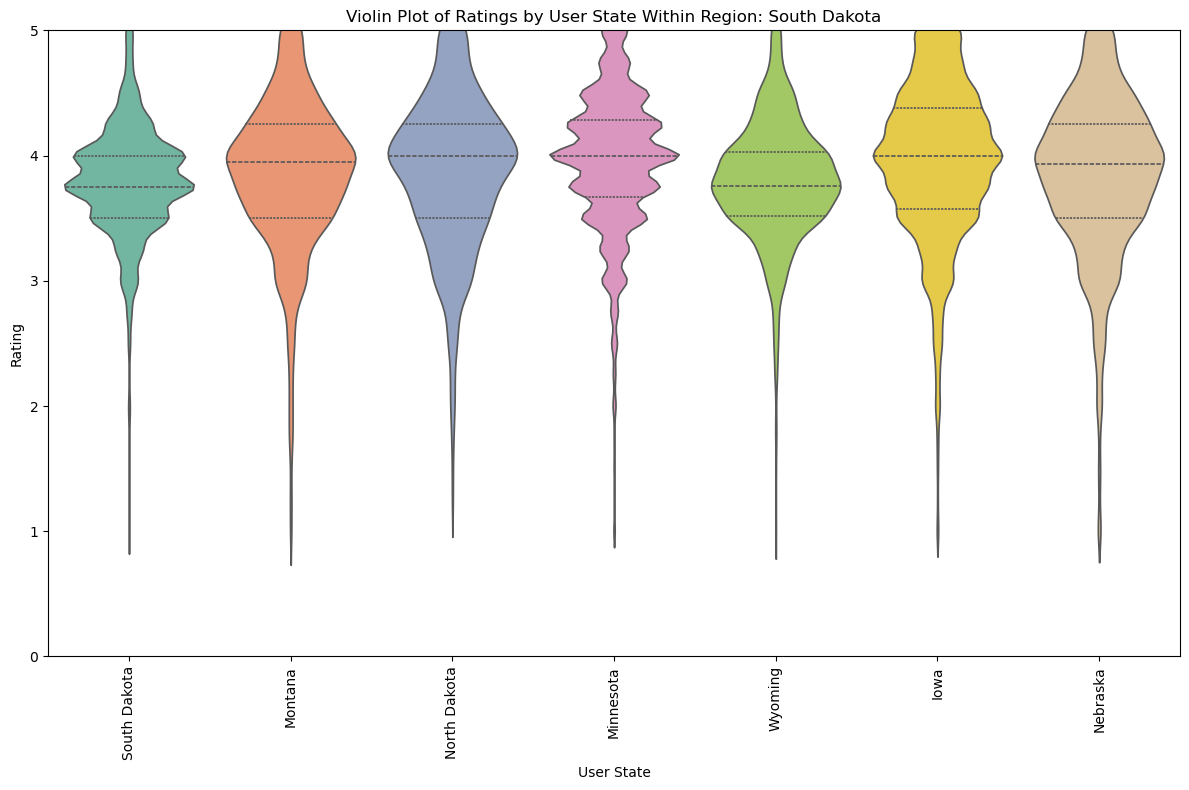

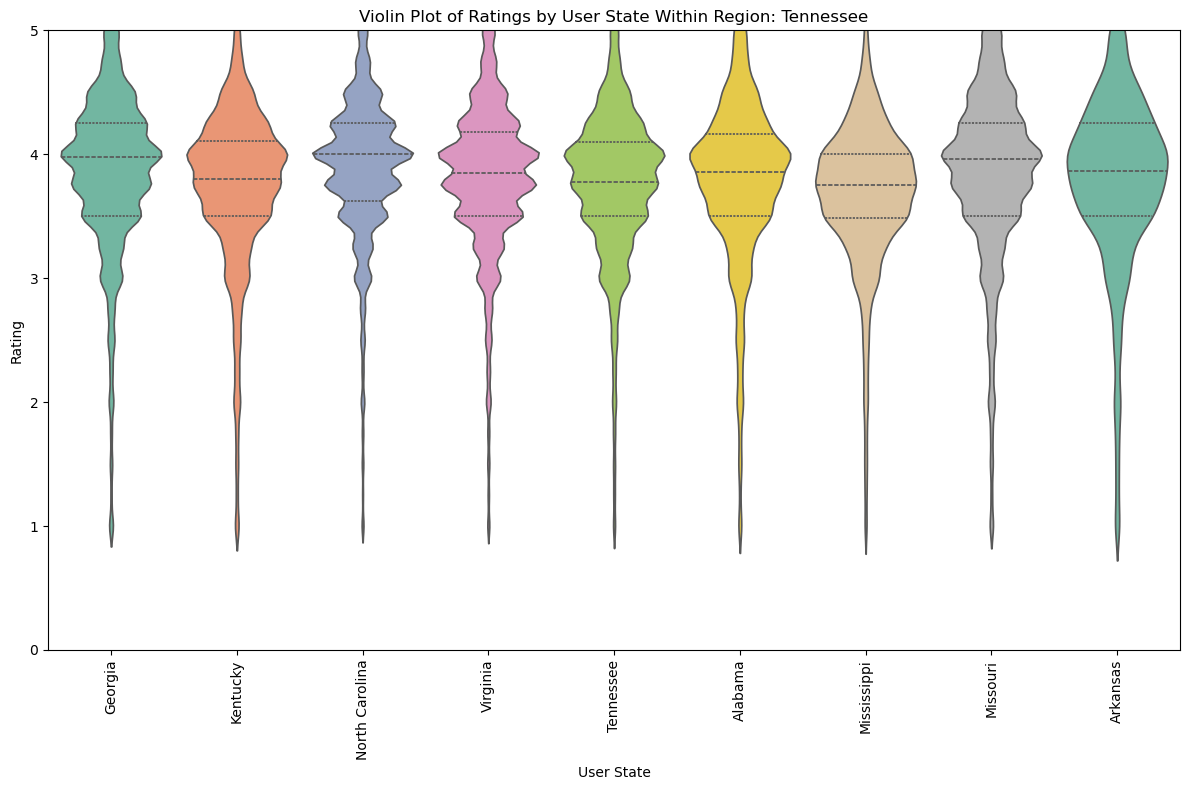

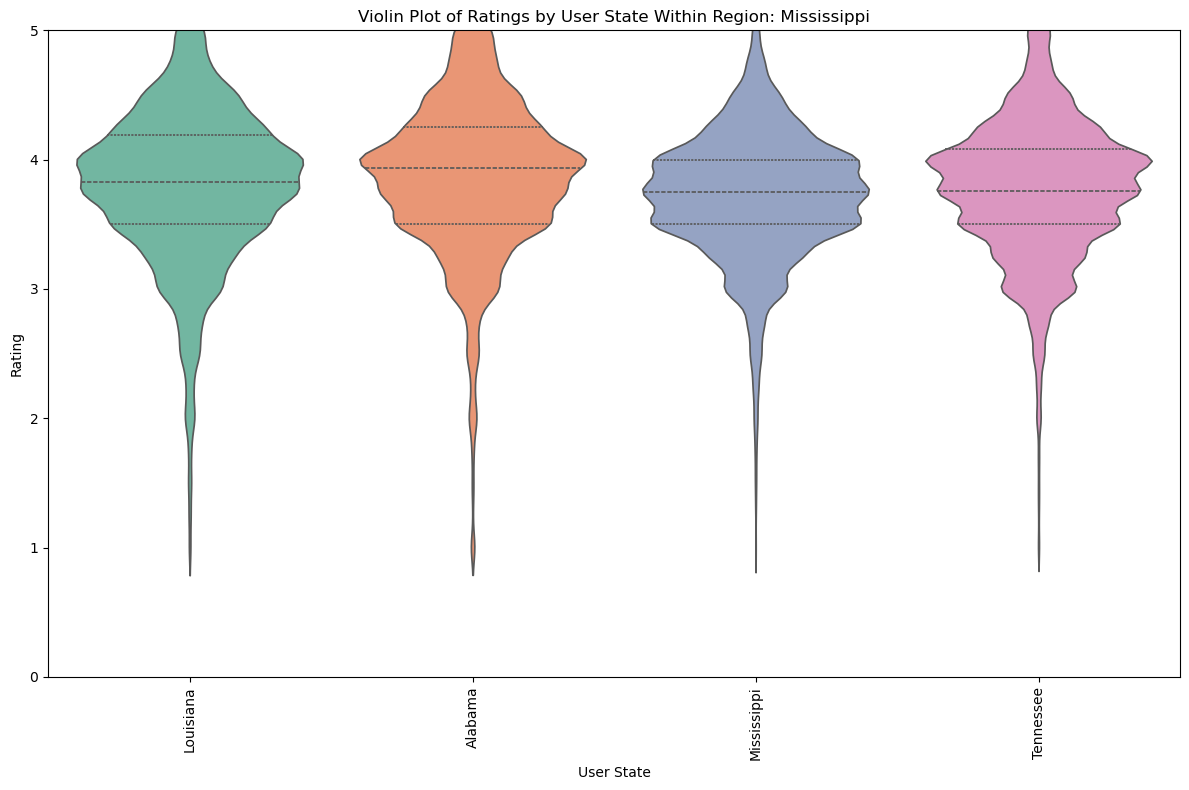

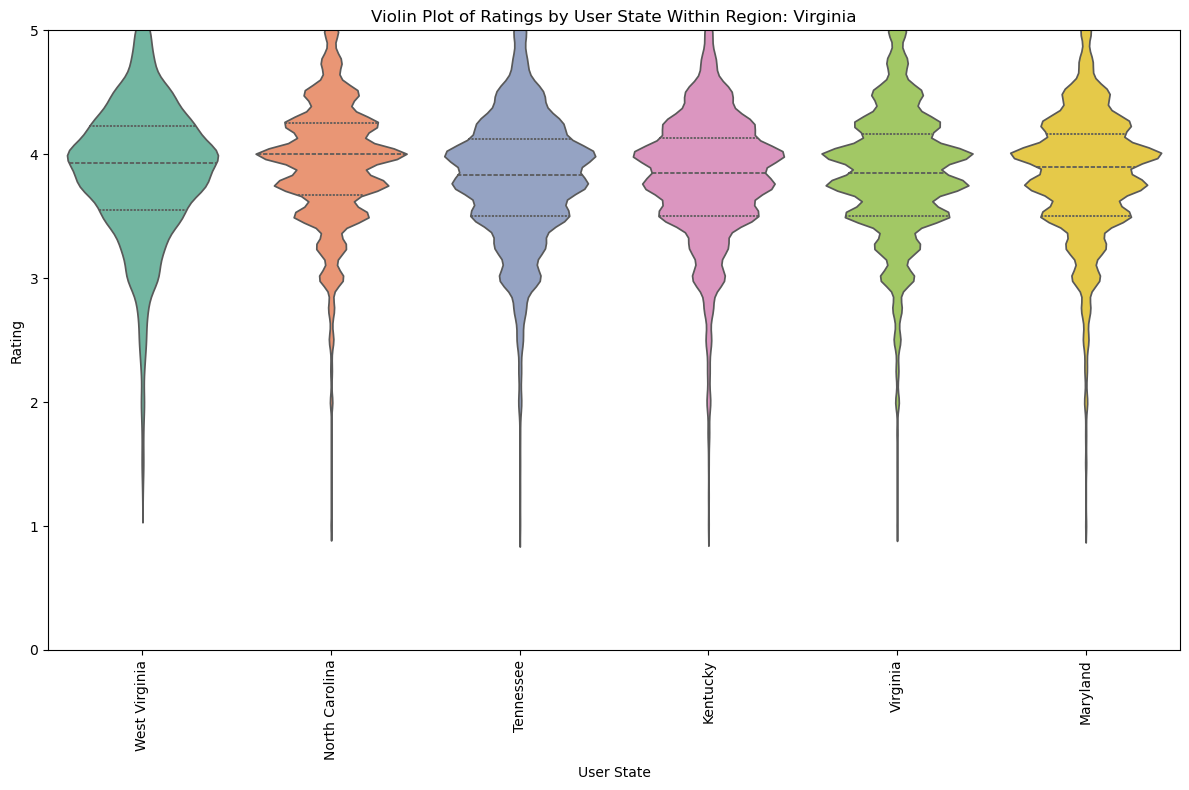

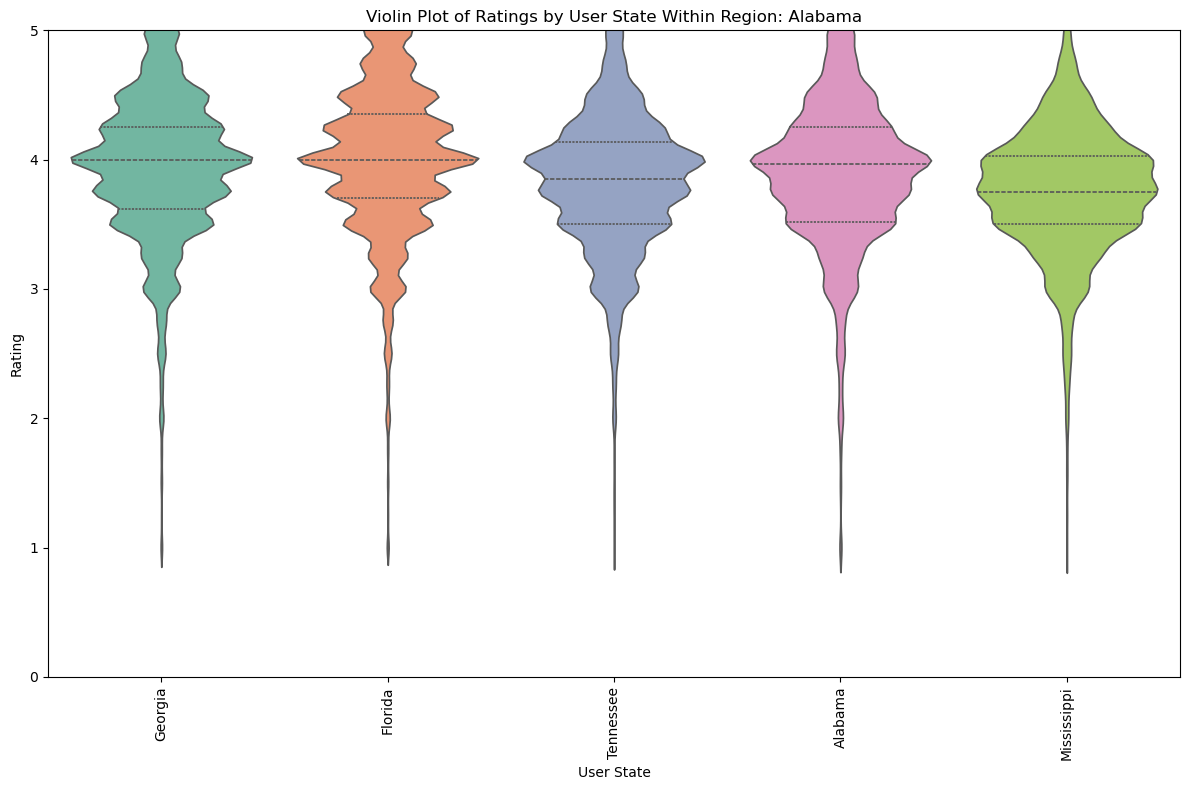

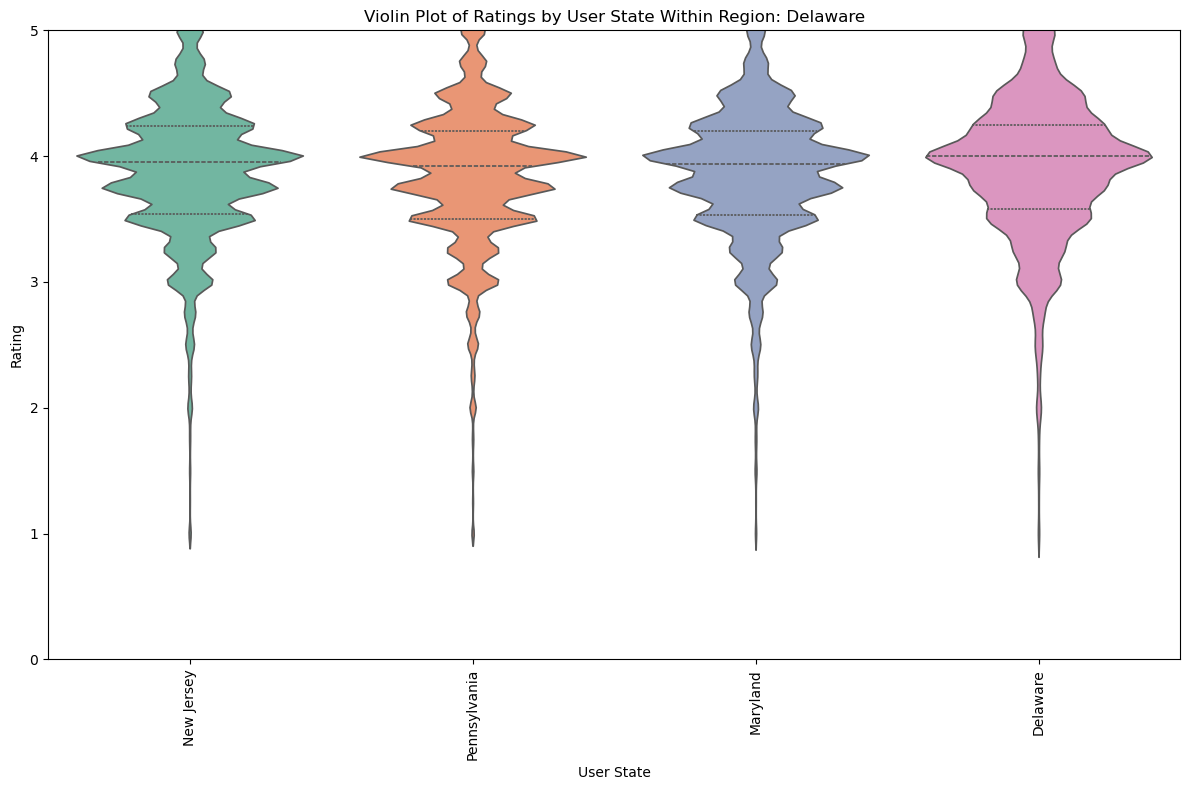

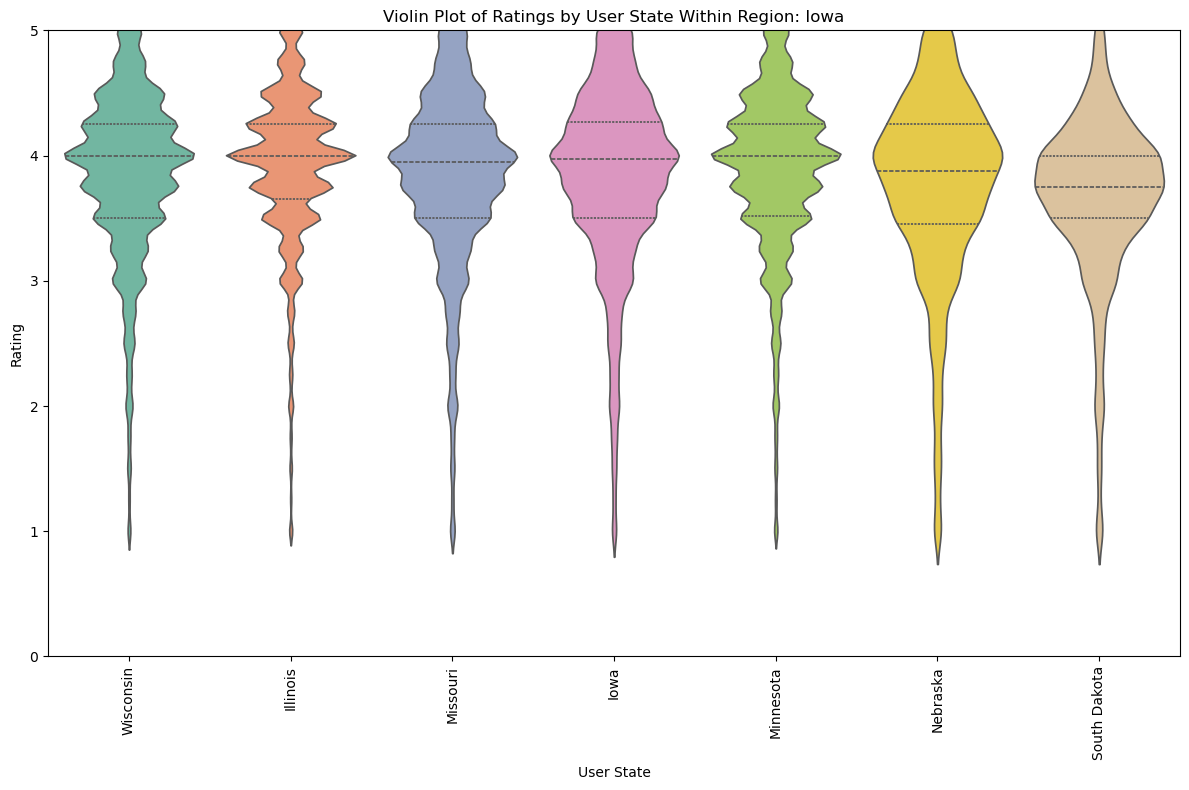

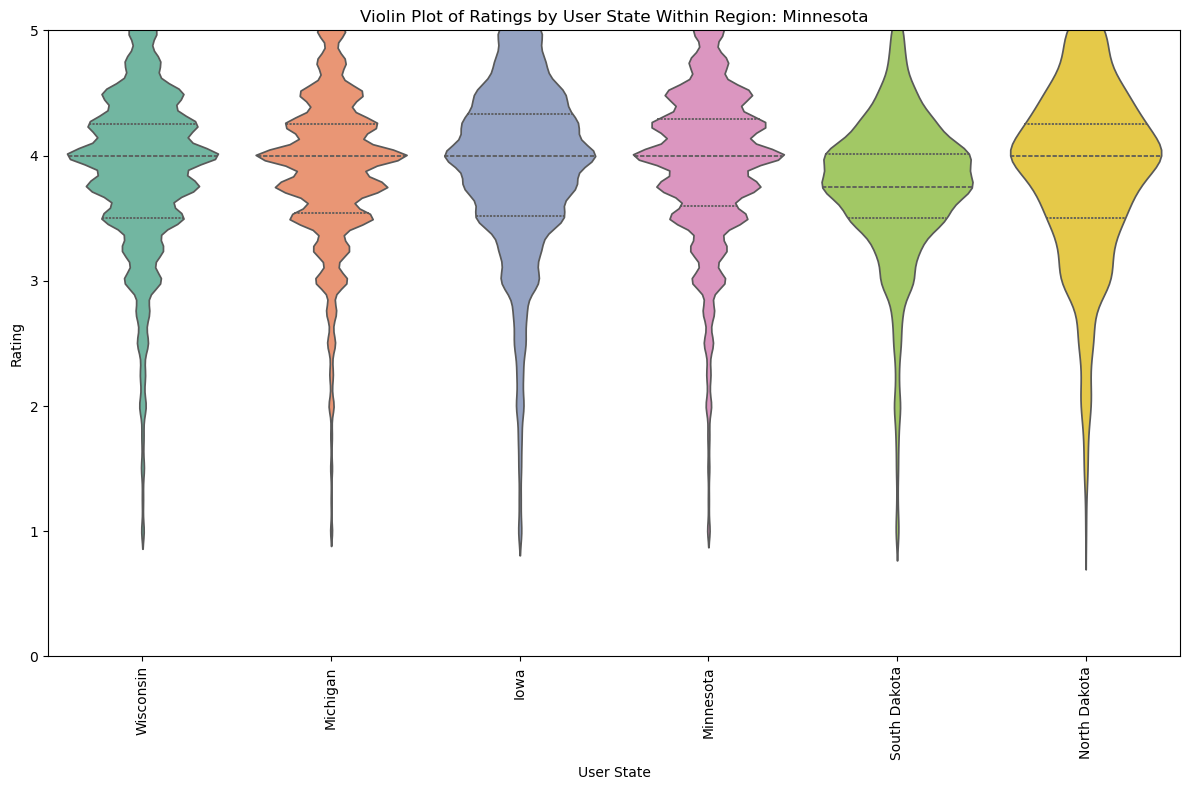

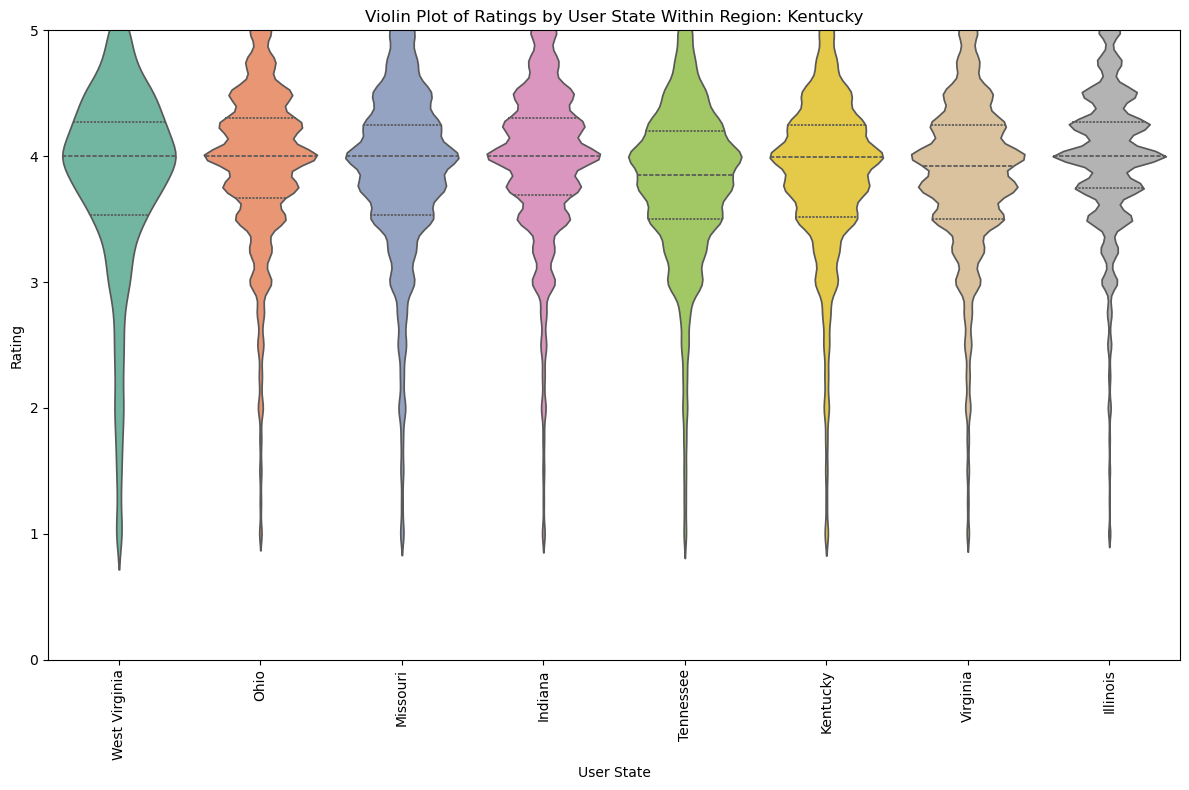

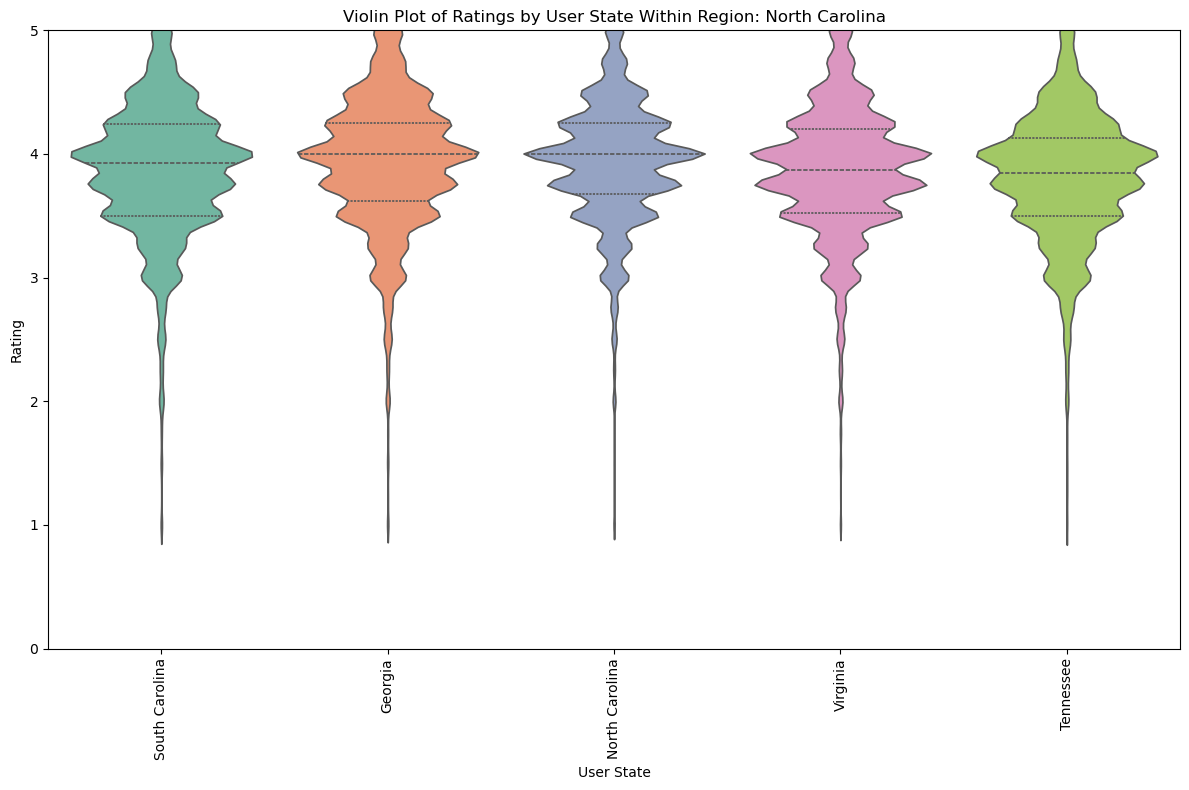

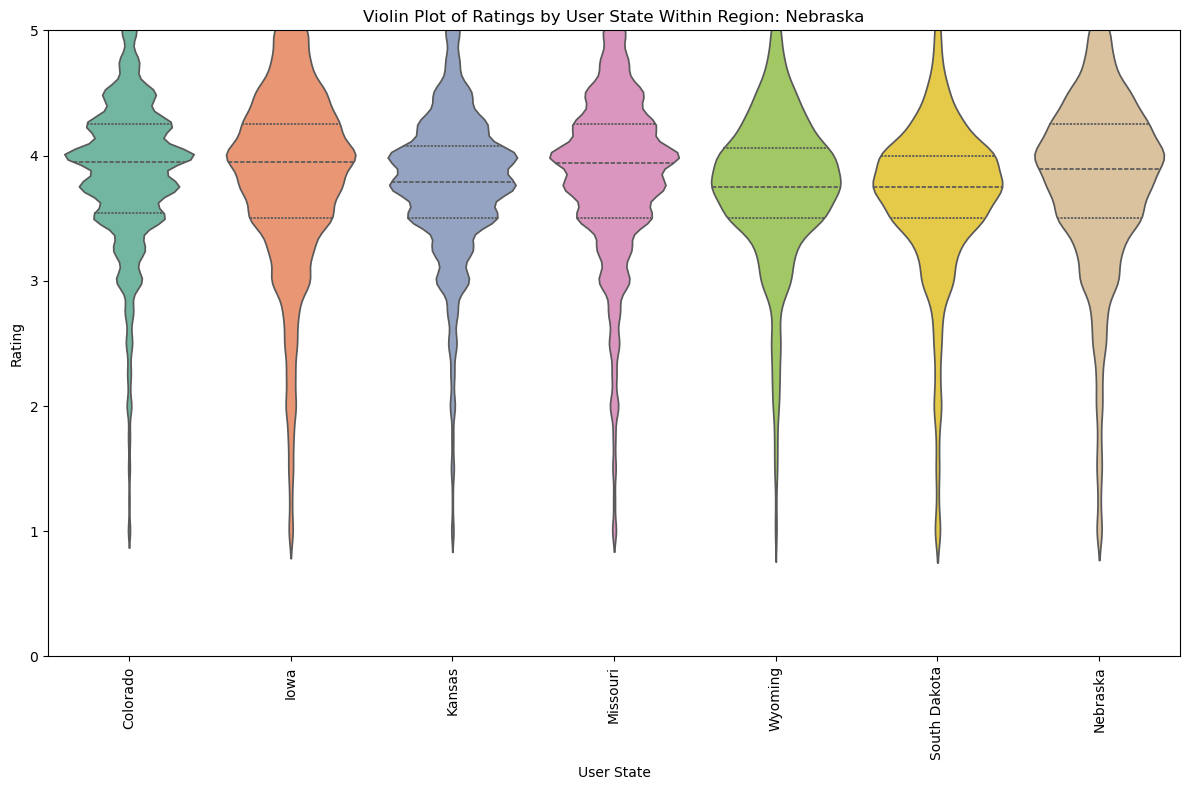

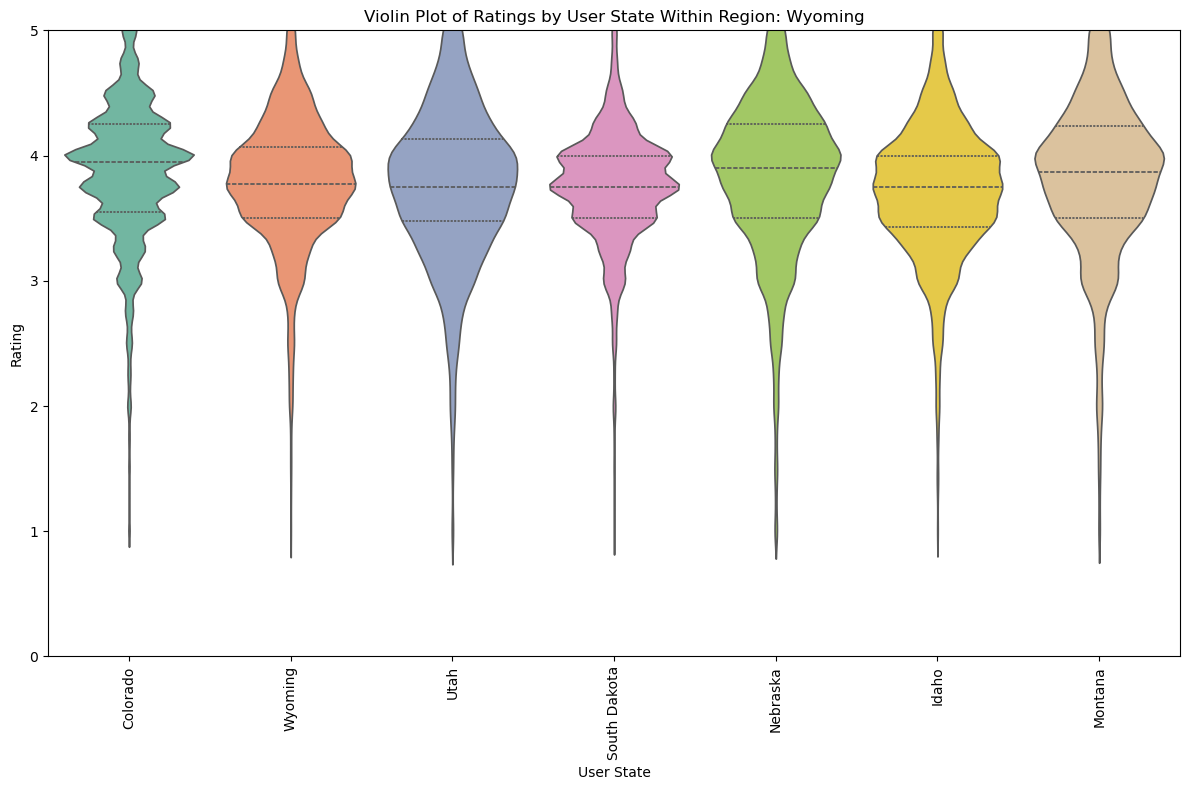

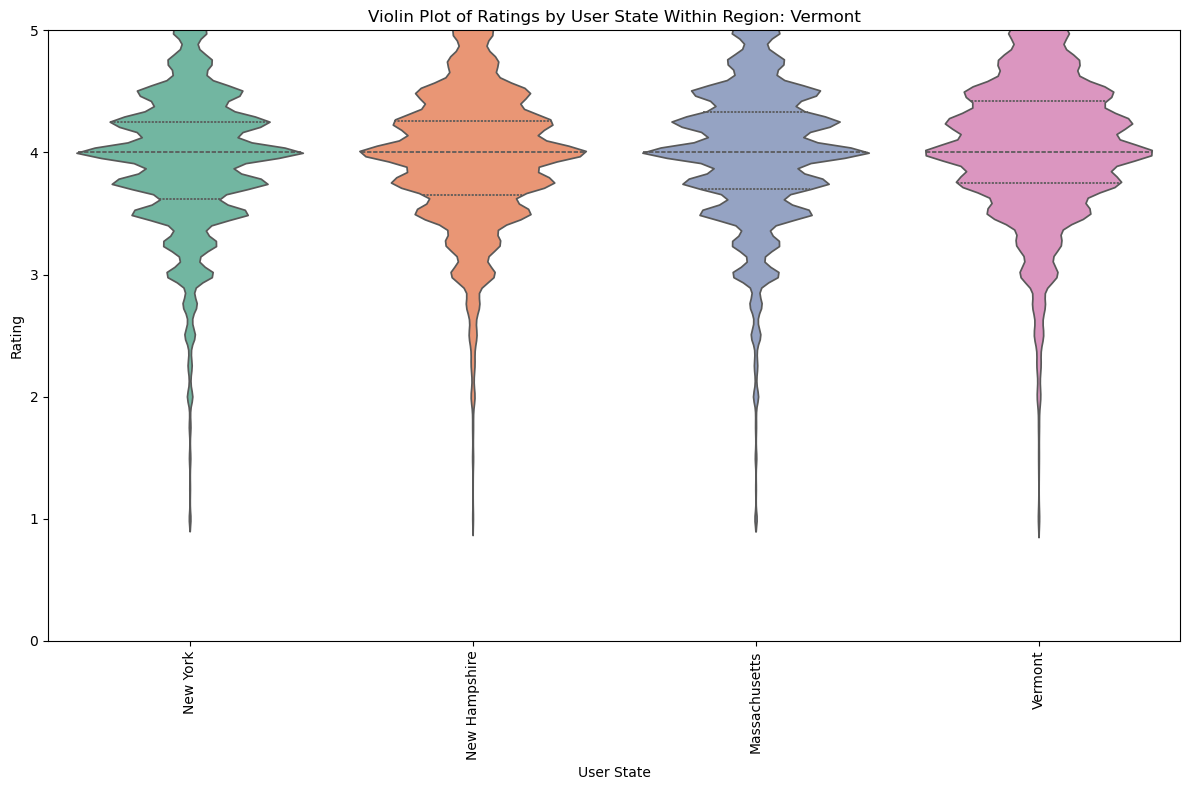

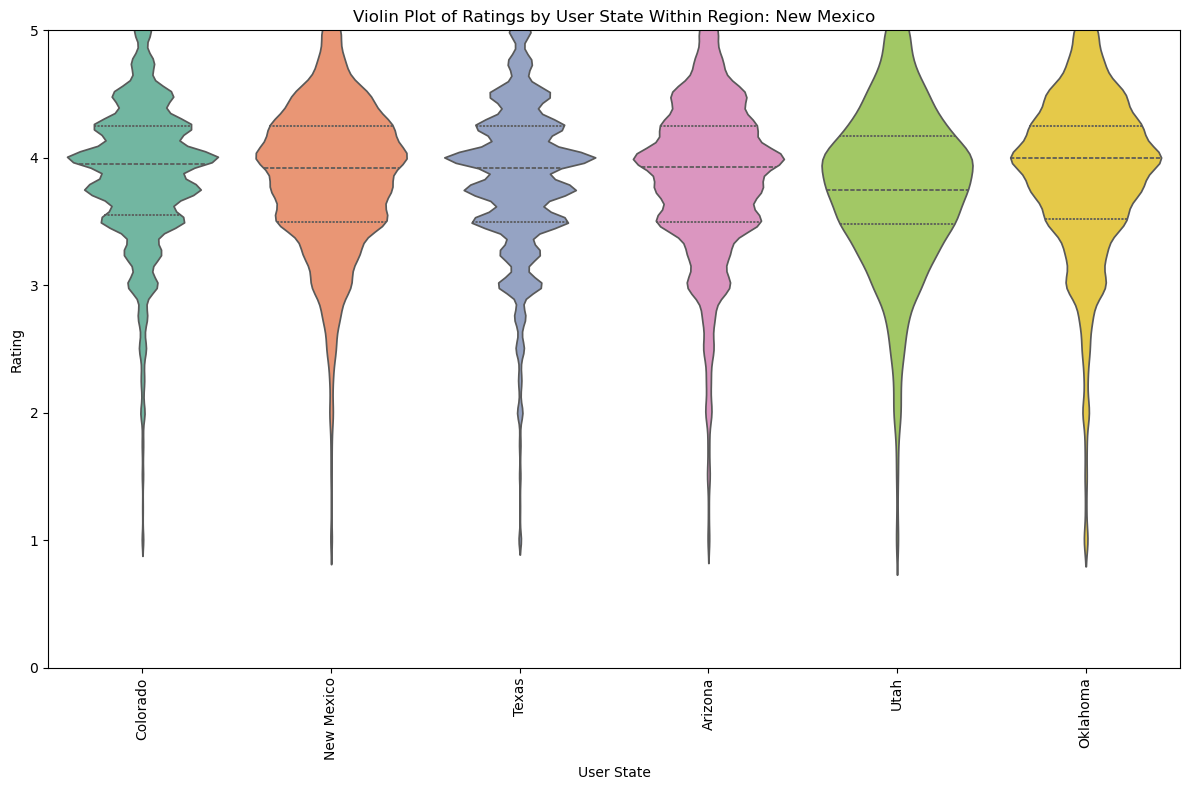

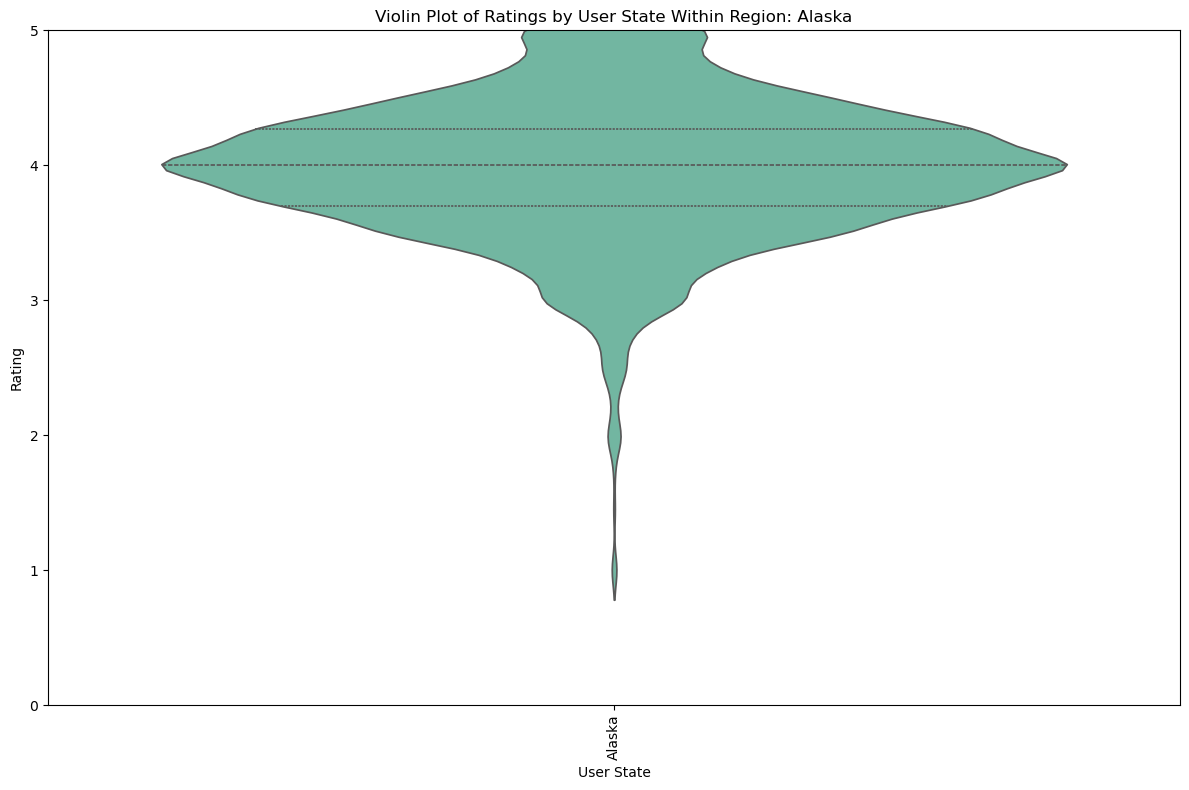

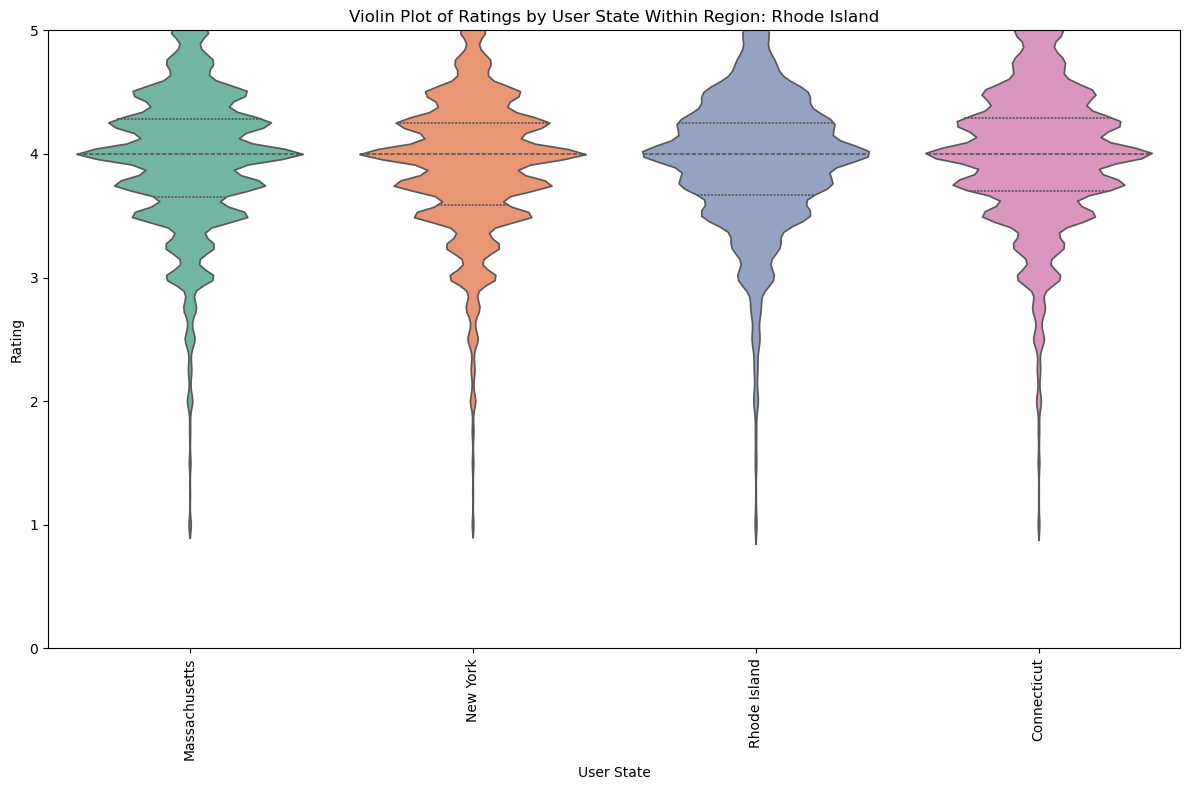

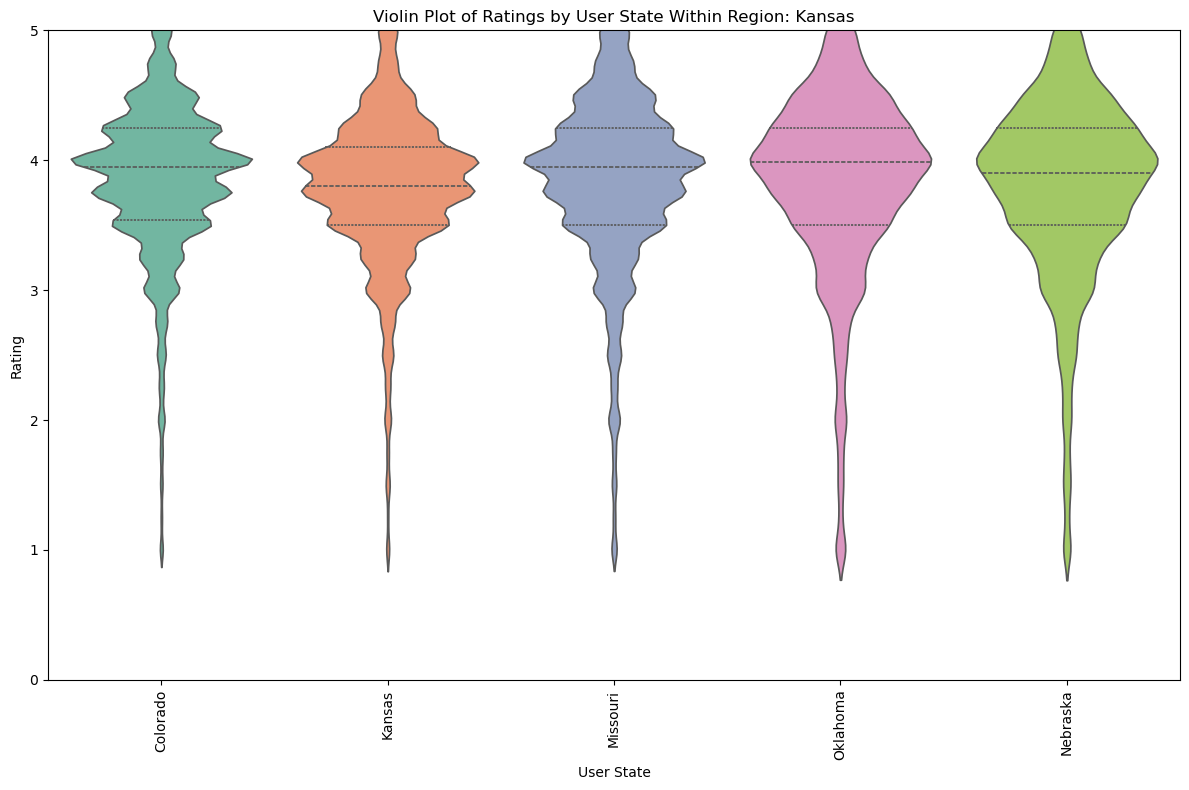

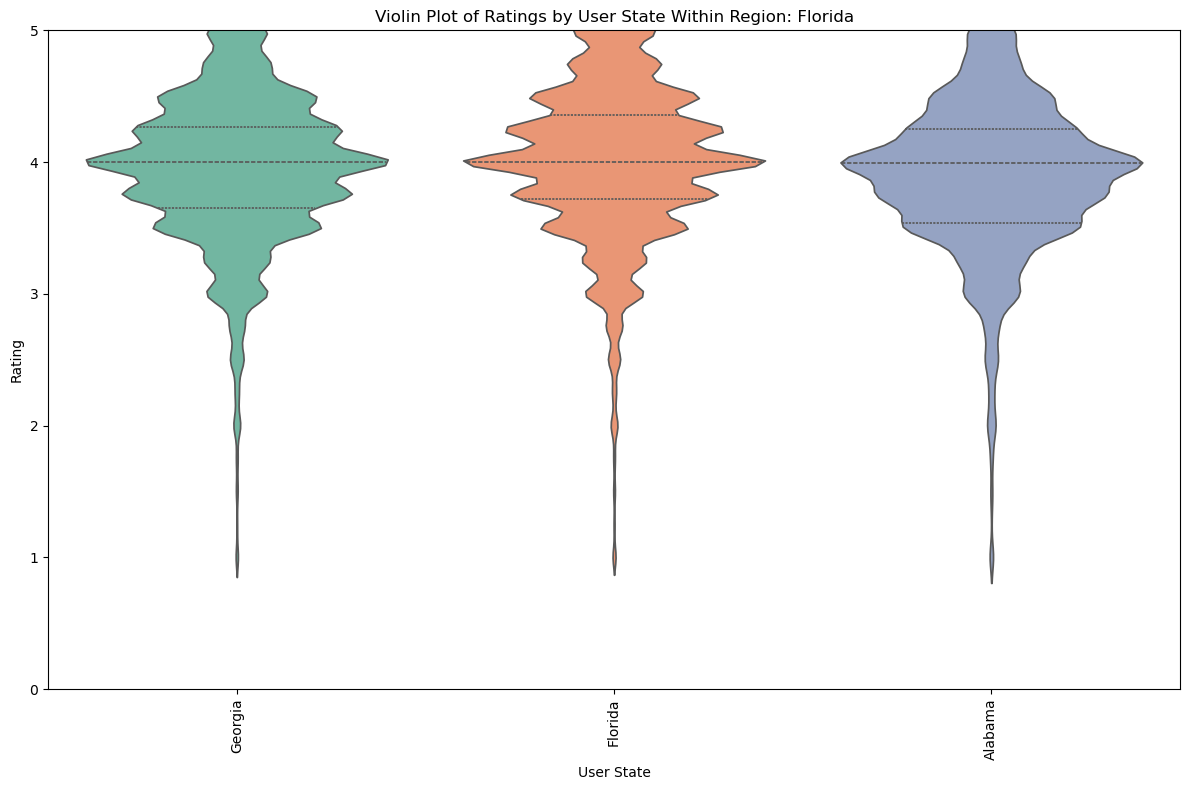

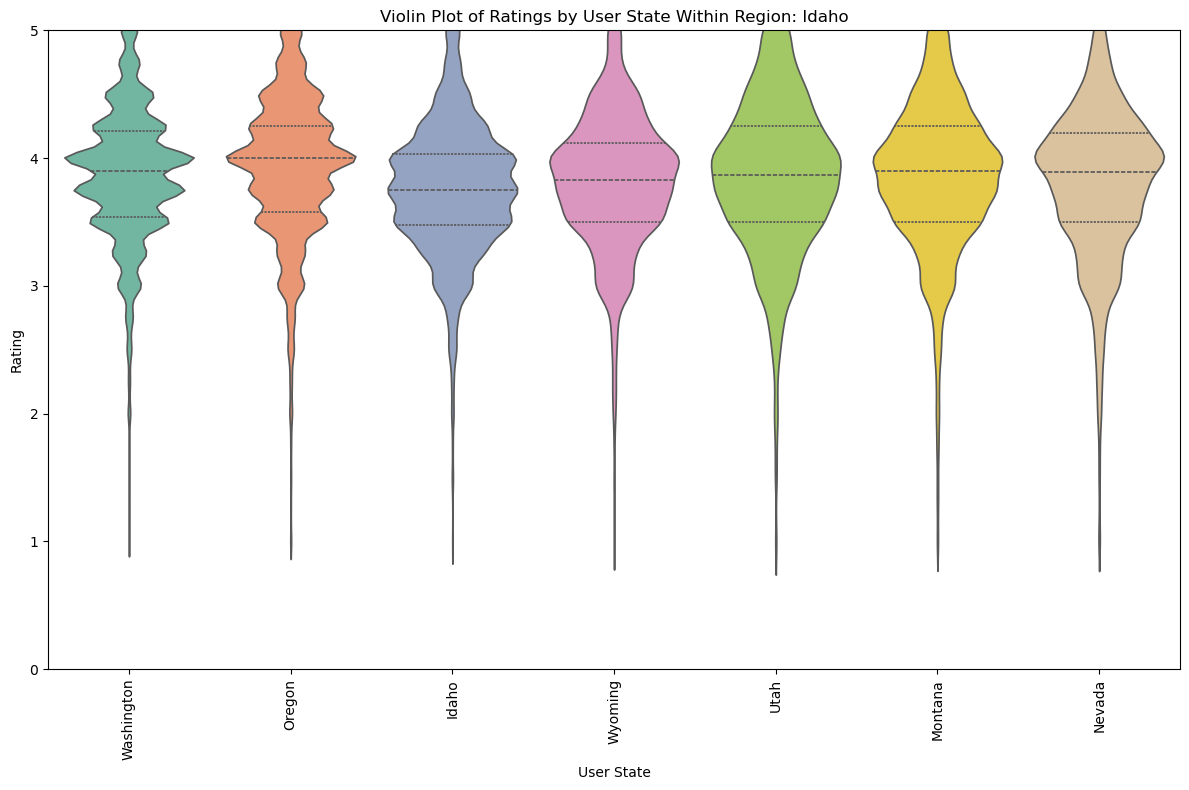

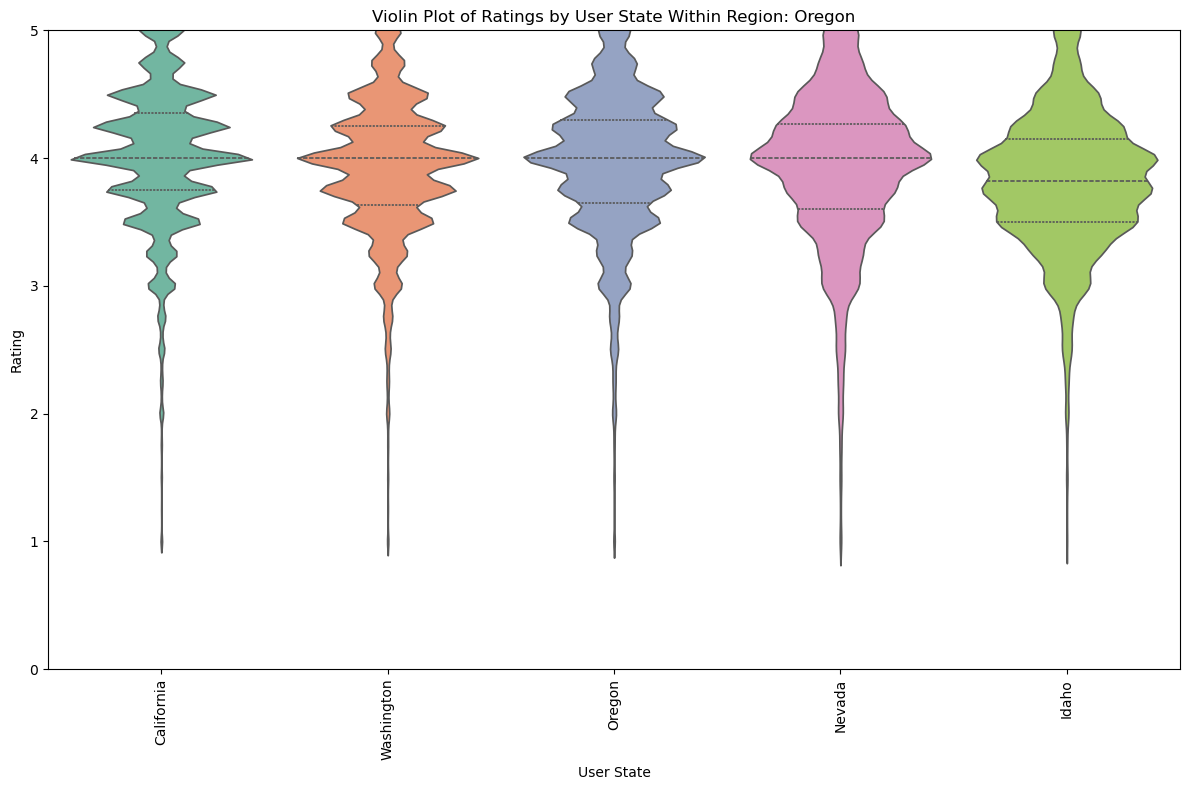

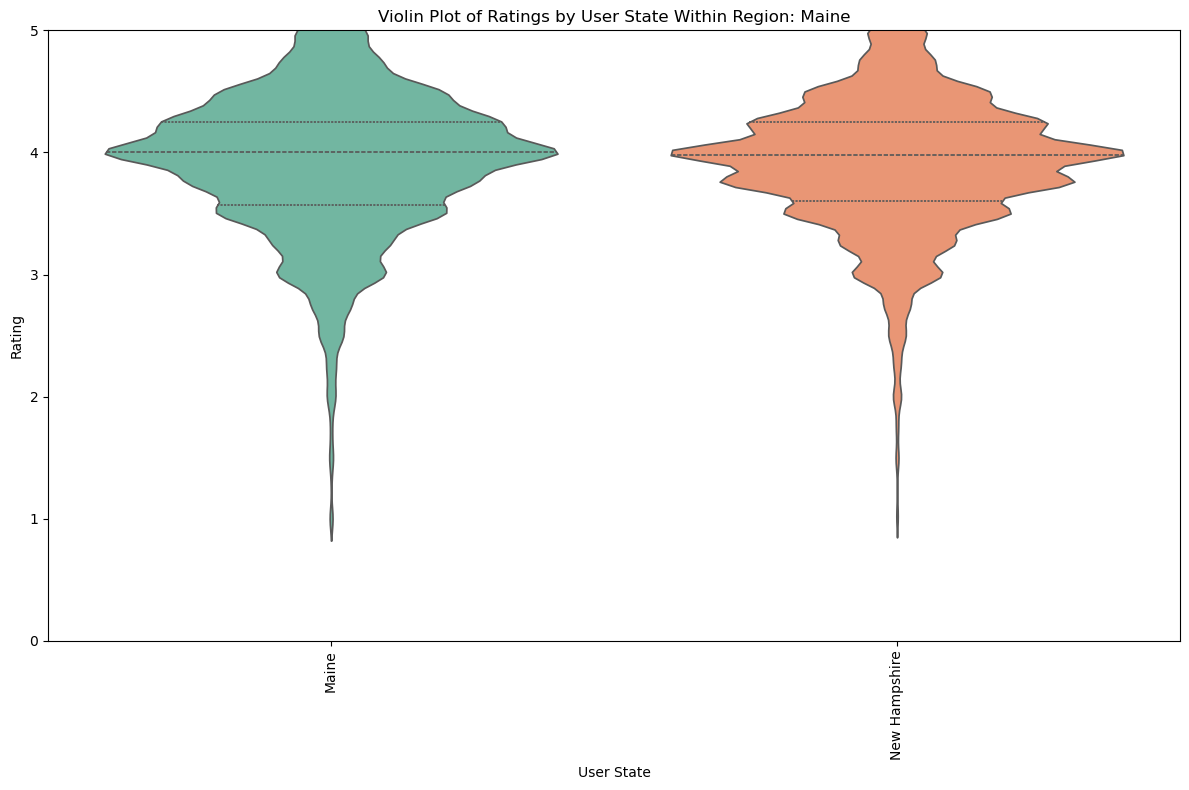

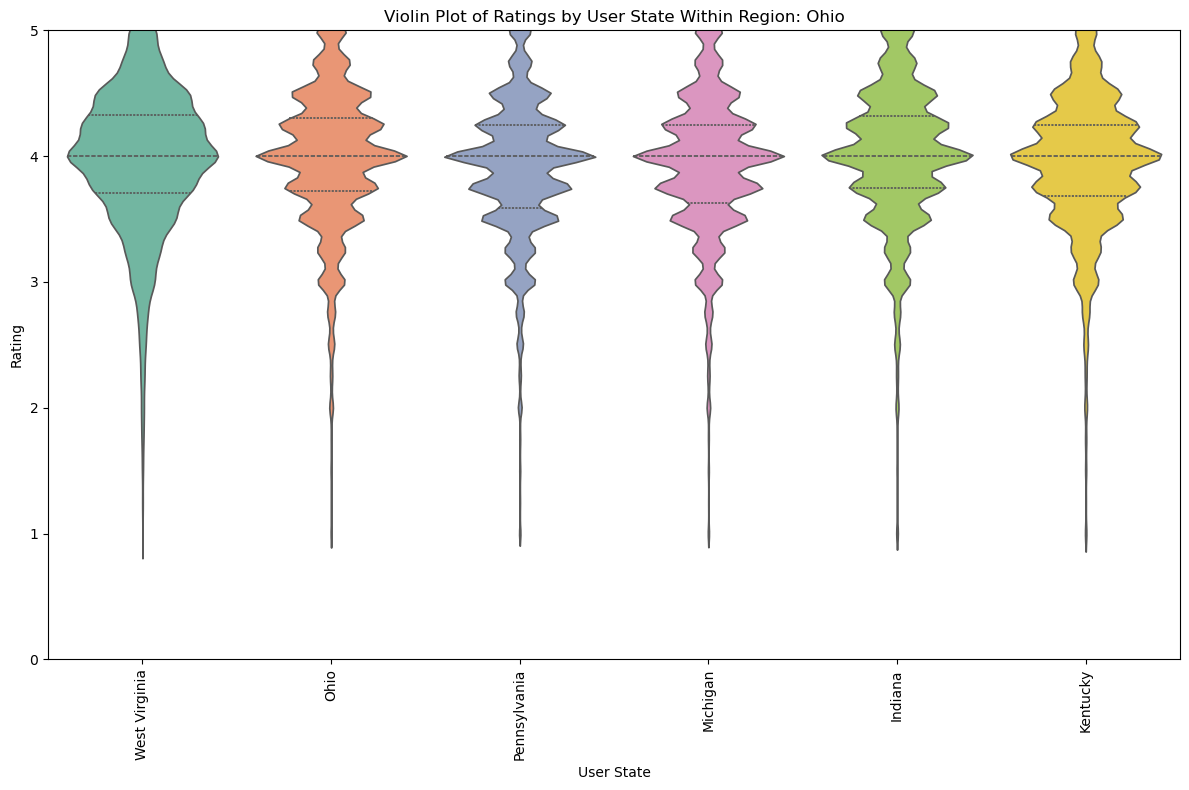

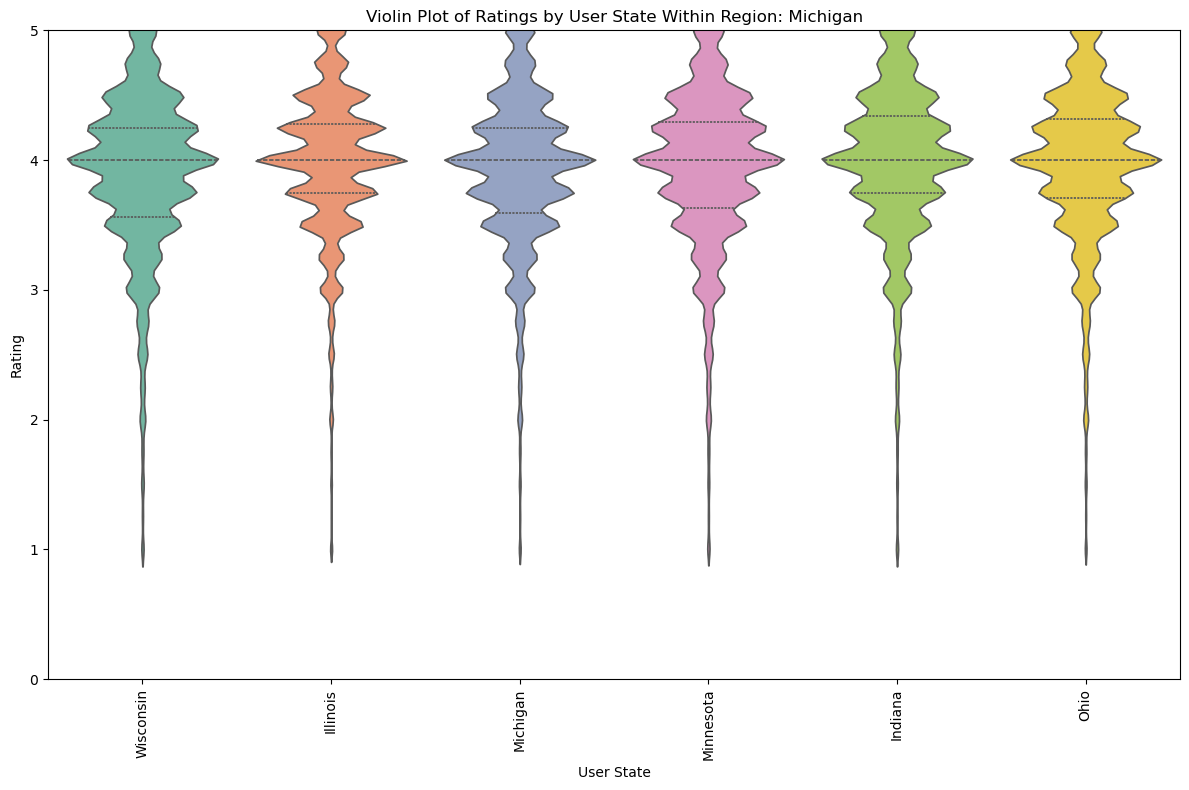

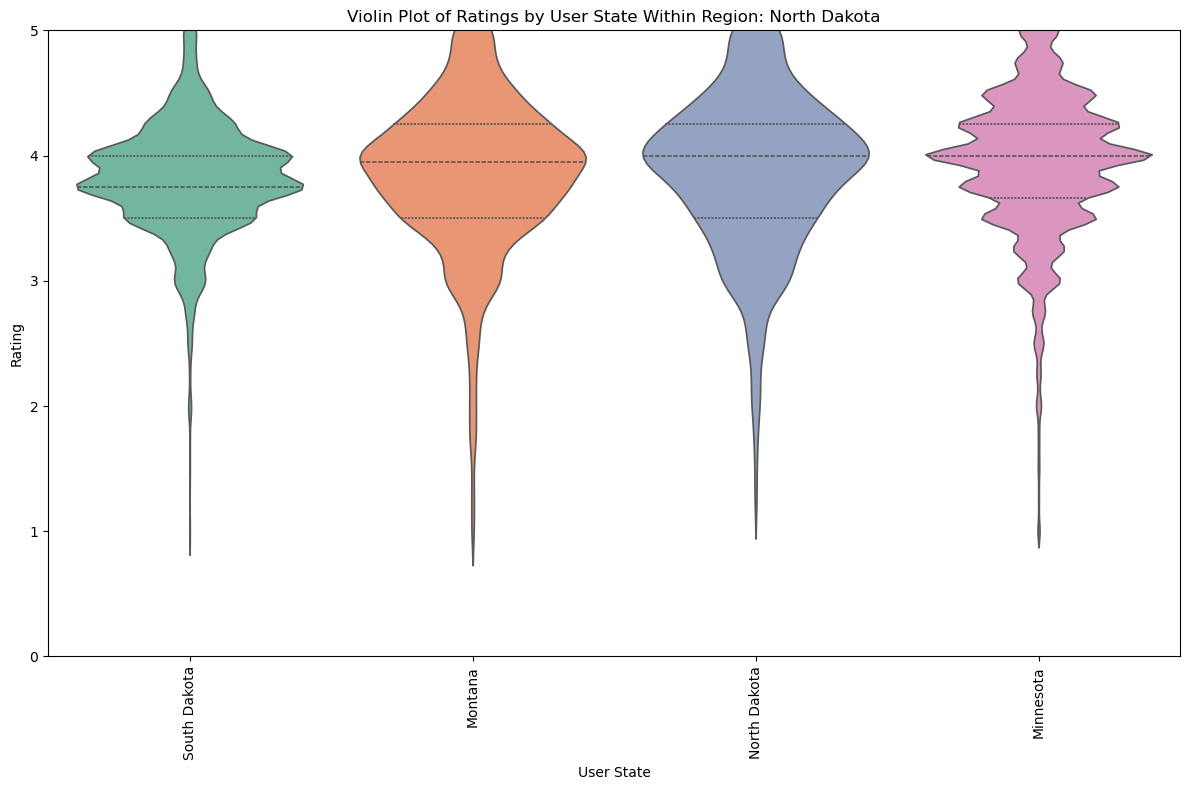

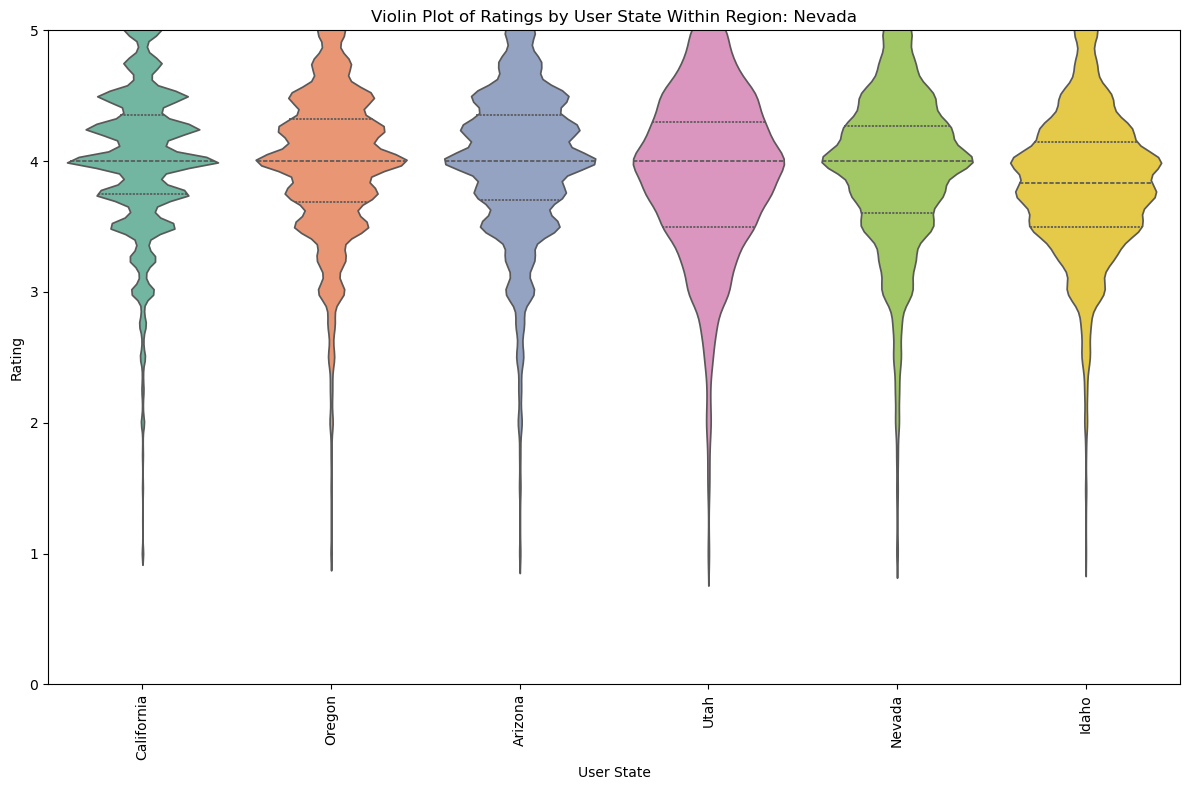

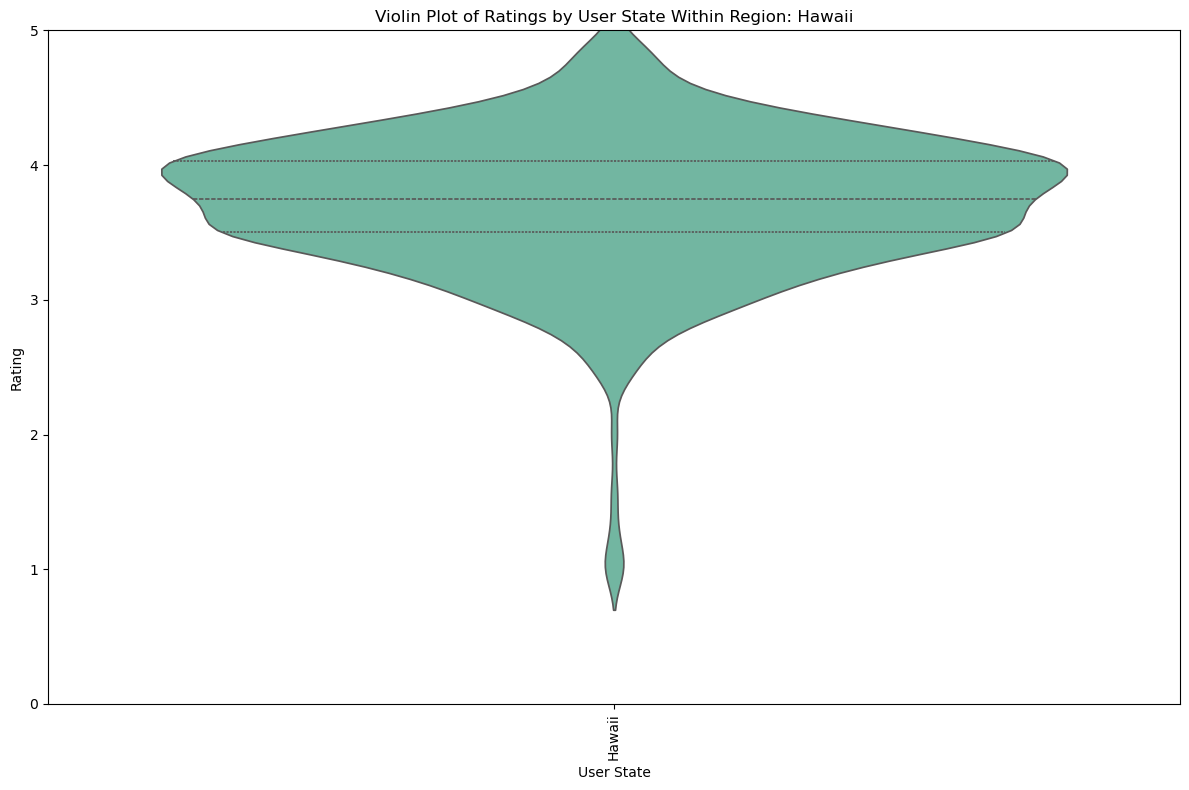

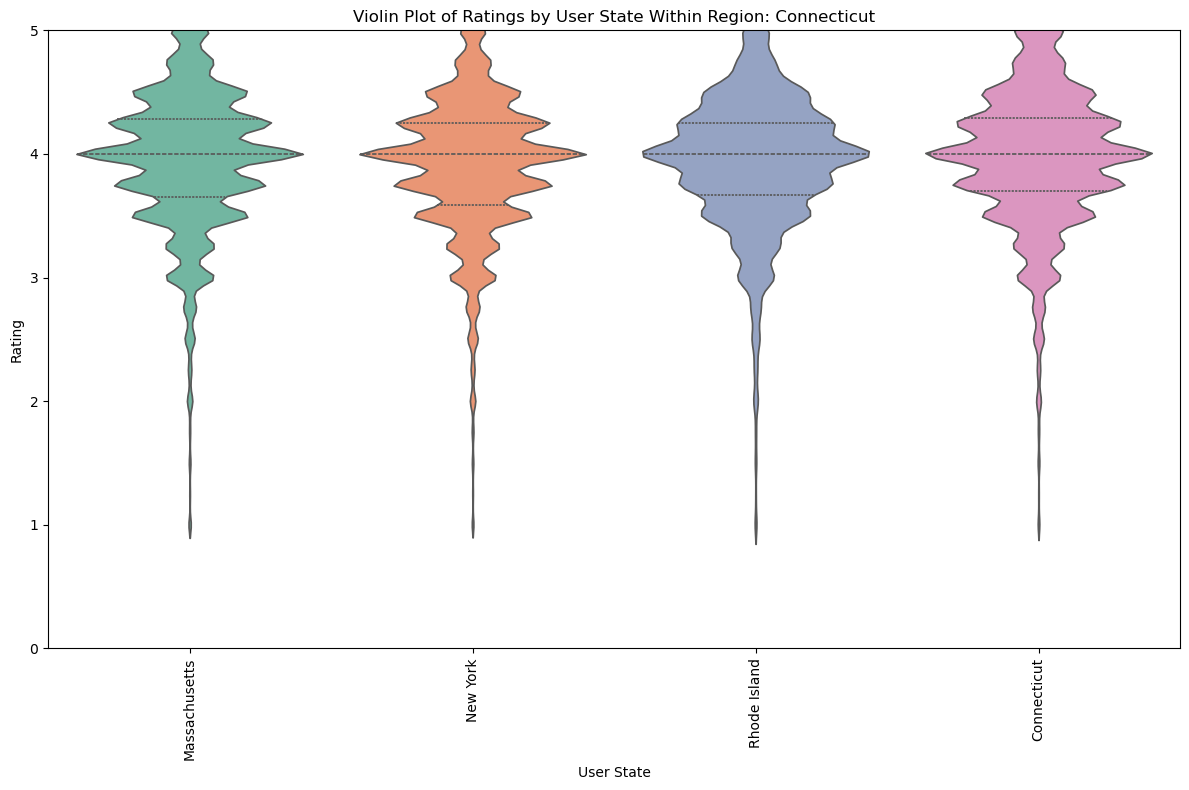

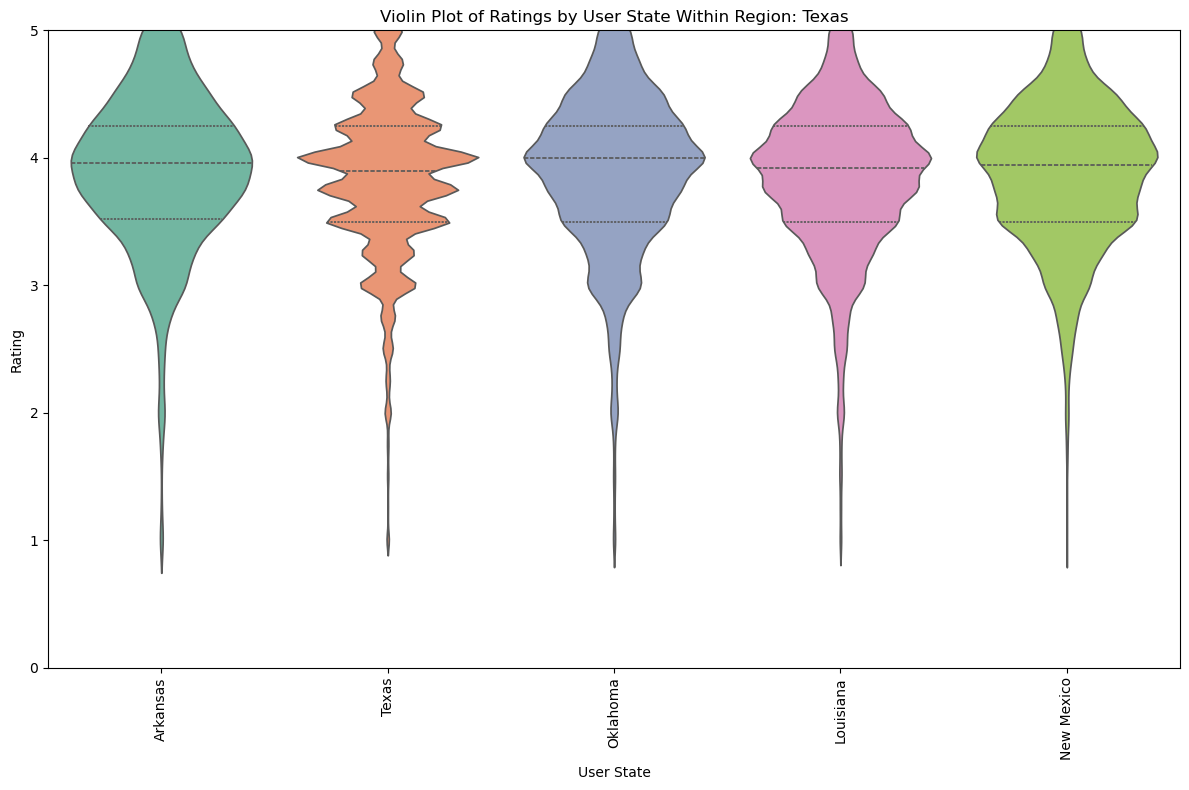

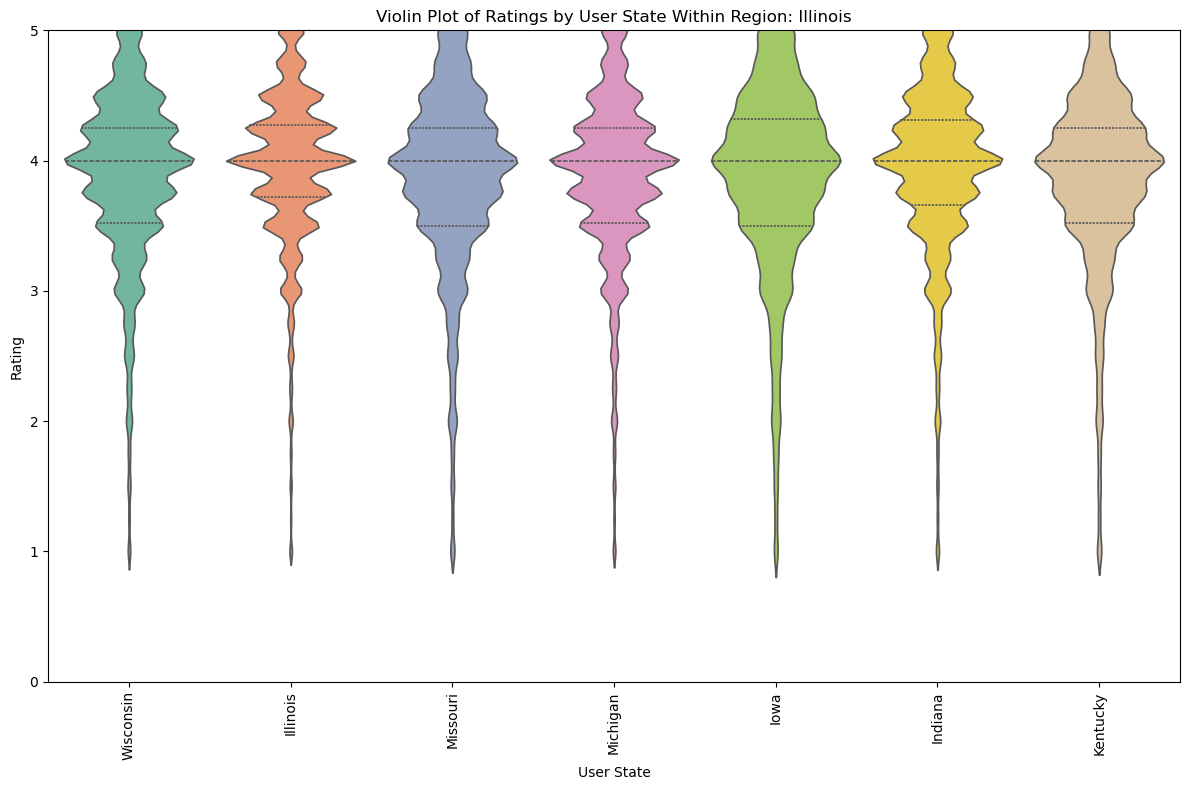

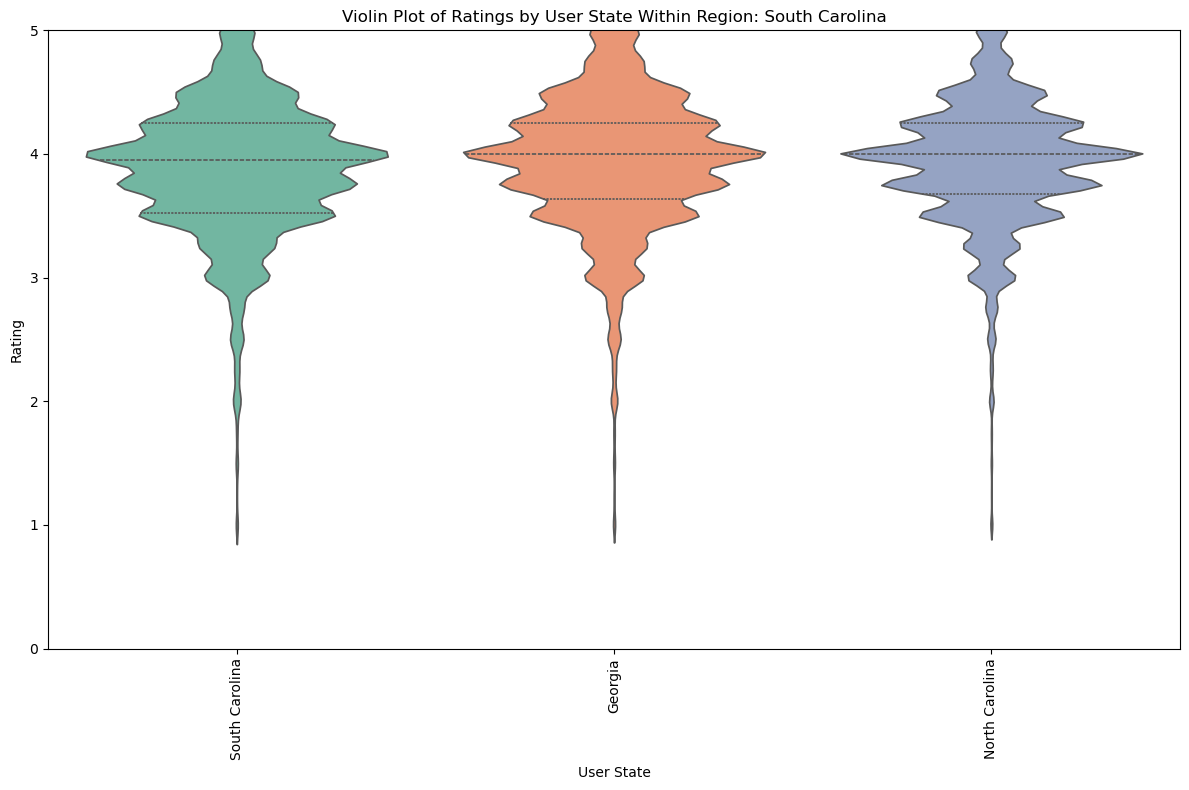

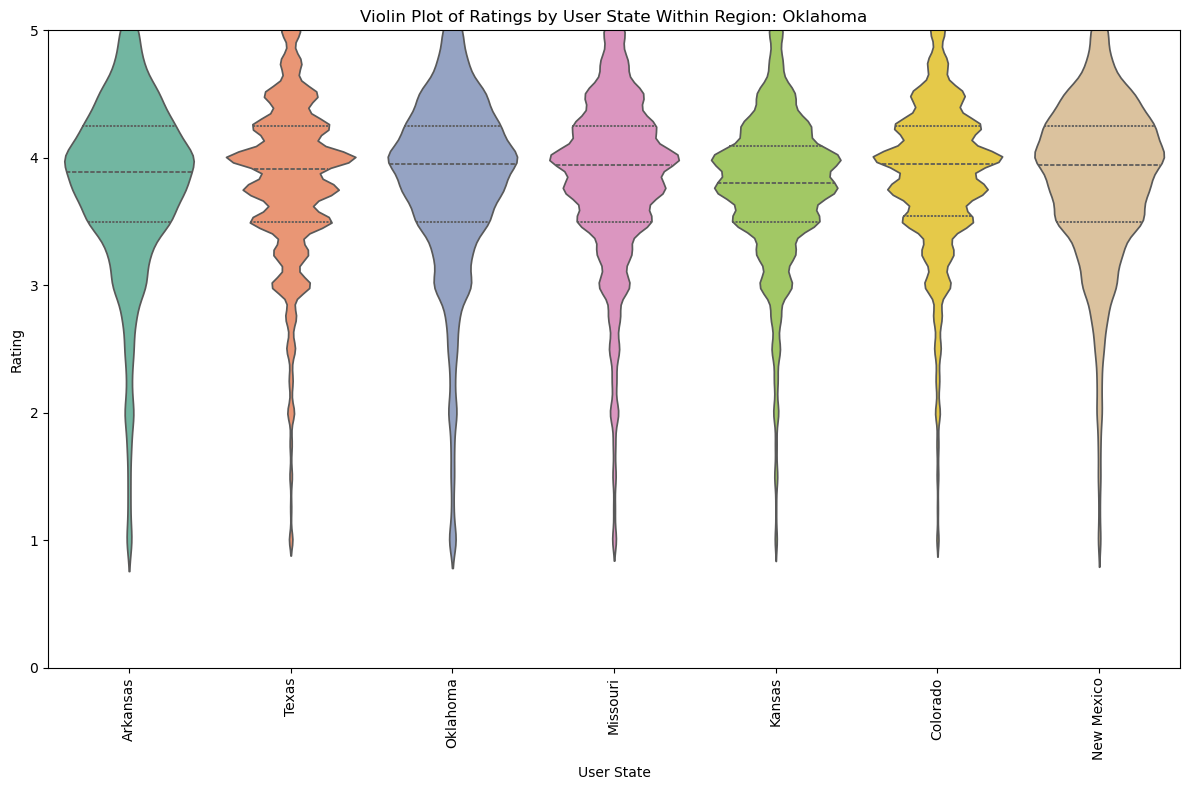

In [10]:
# Creating violin plot for each region displaying rating distributions for each user state in the region
unique_regions = ratings_df['region'].unique()

for region in unique_regions:
    subset_data = ratings_df[ratings_df['region'] == region]
    
    plt.figure(figsize=(12, 8))
    sns.violinplot(
        x='user_state',
        y='rating',
        data=subset_data,
        inner='quartile',
        palette='Set2',
        hue='user_state'
    )
    
    plt.title(f"Violin Plot of Ratings by User State Within Region: {region}")
    plt.xlabel("User State")
    plt.ylabel("Rating")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.ylim(0,5)
    plt.show()


In [11]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

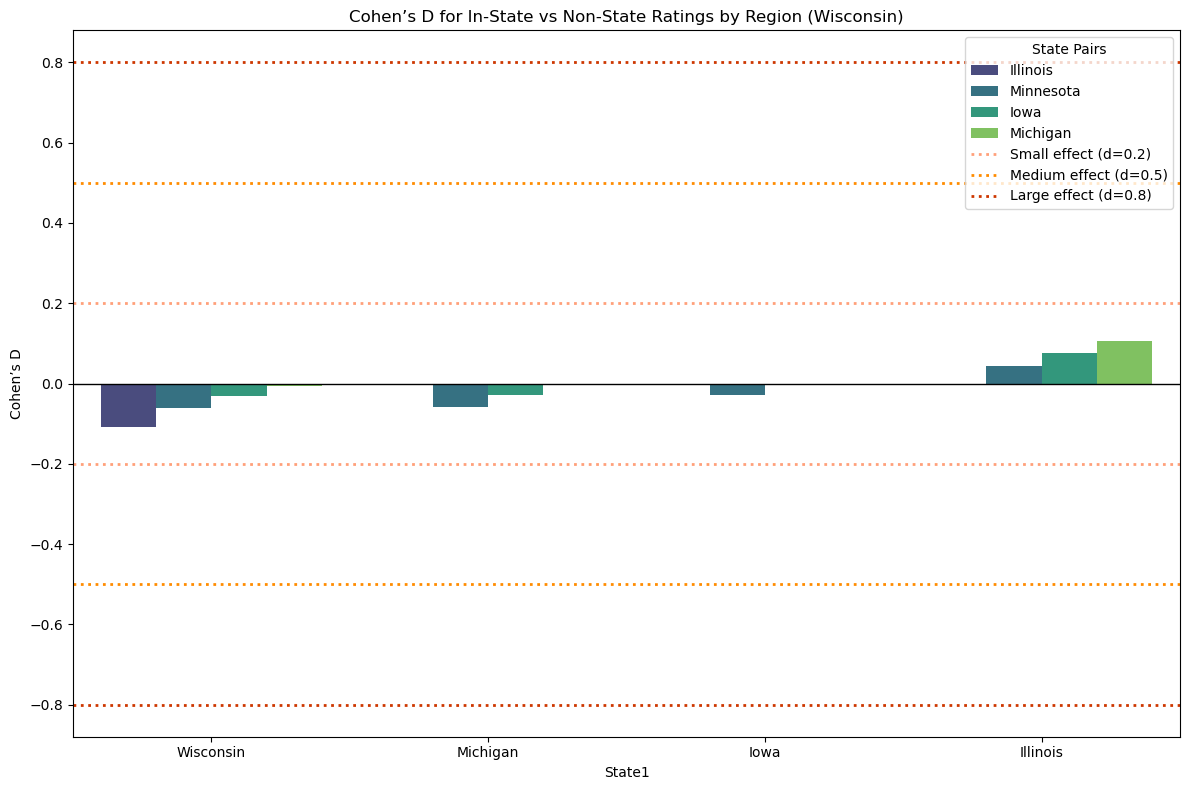

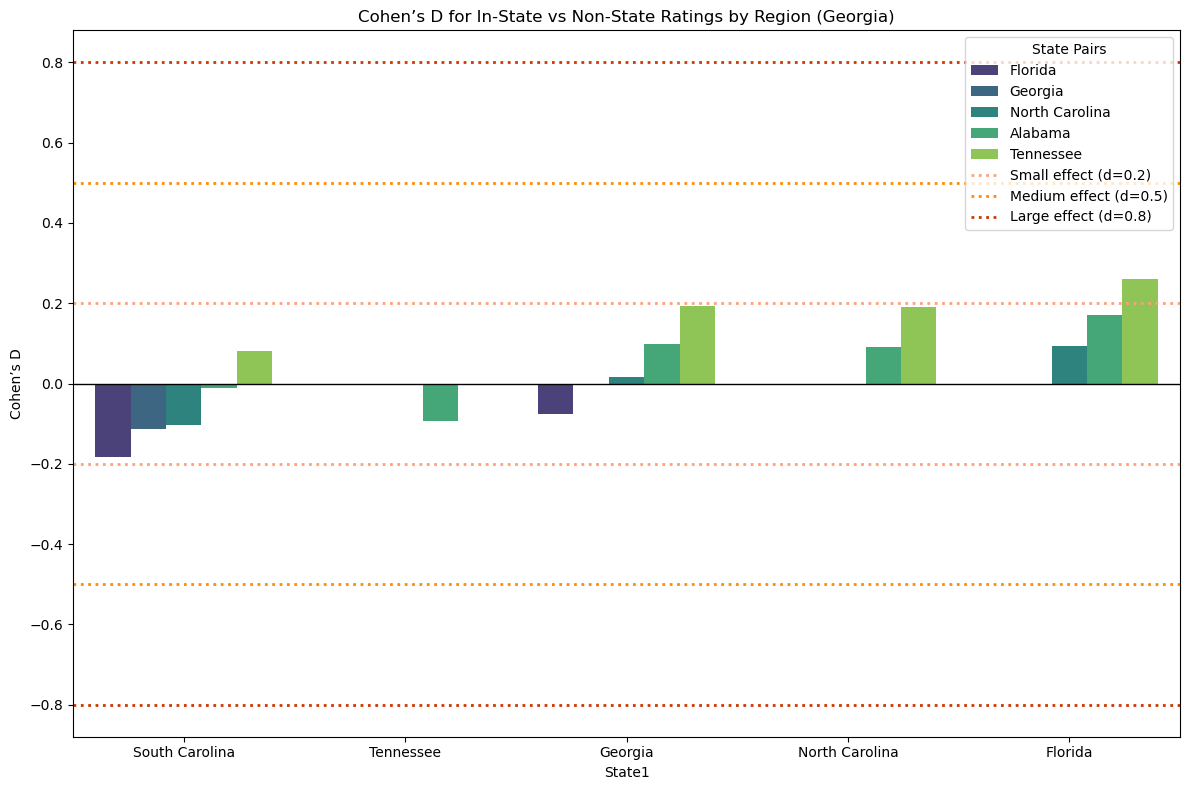

In [ ]:
# Creating a plot of the Cohen's D values between every user_state of a region without calculating it twice.
for region in ratings_df['region'].unique():
    subset = ratings_df[ratings_df['region'] == region]
    cohen_results = []
    processed_pairs = set()
    
    for state1 in subset['user_state'].unique():
        for state2 in subset['user_state'].unique():
            if state1 != state2:
                state_pair = tuple(sorted([state1, state2]))
                
                if state_pair in processed_pairs:
                    continue
                
                ratings_state1 = subset[subset['user_state'] == state1]['rating']
                ratings_state2 = subset[subset['user_state'] == state2]['rating']
                
                if len(ratings_state1) == 0 or len(ratings_state2) == 0:
                    continue
                
                d_value = cohen_d(ratings_state1, ratings_state2)
                cohen_results.append((state1, state2, d_value))
                processed_pairs.add(state_pair)
    
    cohen_df_region = pd.DataFrame(cohen_results, columns=['State1', 'State2', 'Cohen_d'])
    
    cohen_df_region = cohen_df_region.sort_values(by='Cohen_d')
    
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='State1', 
        y='Cohen_d', 
        data=cohen_df_region, 
        palette='viridis', 
        hue='State2'
    )

    plt.axhline(y=0, color='black', linewidth=1)
    plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
    plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
    plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
    plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
    plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
    plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)
    
    plt.xlabel('State1')
    plt.ylabel('Cohen’s D')
    plt.title(f'Cohen’s D for In-State vs Non-State Ratings by Region ({region})')
    plt.xticks(rotation=0)
    plt.legend(title='State Pairs', loc='upper right')
    plt.tight_layout()
    
    plt.show()